In [4]:
import pandas as pd
import numpy as np
from scipy import stats
from IPython.display import display, HTML
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import plotly.graph_objects as go

In [5]:
ace_data = pd.read_pickle("../data/../data/ace_data_prepped.pkl")
ace_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   499 non-null    int64   
 1   hospital_reqd        499 non-null    int64   
 2   referral_from        498 non-null    category
 3   age                  499 non-null    int64   
 4   address              499 non-null    category
 5   ethnicity            497 non-null    category
 6   gender               499 non-null    category
 7   allergies            499 non-null    object  
 8   referral_date        499 non-null    category
 9   referral_time        499 non-null    category
 10  illness_severity     497 non-null    category
 11  activity_level       496 non-null    category
 12  gut_feeling          494 non-null    category
 13  ox_sat               489 non-null    float64 
 14  resp_rate            488 non-null    float64 
 15  heart_rate           49

In [7]:
skip_features = ["id", "hospital_reqd", "age", "heart_rate", "resp_rate",
                 "ox_sat", "temp", "ethnicity", "address", "allergies"]

cat_feature_stats = pd.DataFrame()
chi2_stats = pd.DataFrame()
for feature in ace_data.columns:

    if feature in skip_features:
        continue

    feature_df = (ace_data[["hospital_reqd", feature]]
                  .groupby(feature)
                  .agg(["mean", np.std, stats.sem, "count"])).hospital_reqd

    idx_tuples = [(feature_df.index.name, cat)
                  for cat in feature_df.index.categories]

    new_idx = pd.MultiIndex.from_tuples(idx_tuples, names=["feature", "values"])

    feature_df.set_index(new_idx, inplace=True)
    cat_feature_stats = pd.concat([cat_feature_stats, feature_df])

    hospital_required_counts = (ace_data[[feature, "hospital_reqd"]]
                                .groupby([feature, "hospital_reqd"],
                                         as_index=False)
                                .size()
                                .pivot(index=feature,
                                       columns="hospital_reqd",
                                       values="size").fillna(0))

    chi2, p, dof, expected = chi2_contingency(hospital_required_counts.values)
    chi2_results = pd.DataFrame({ "chi2": chi2, "p": p, "dof": dof },
                                index=[feature])

    chi2_stats = pd.concat([chi2_stats, chi2_results])


norm = mpl.colors.Normalize(vmin=0.0,vmax=0.15)
red_cmap = sns.color_palette("Reds", as_cmap=True)
red_m = cm.ScalarMappable(norm=norm, cmap=red_cmap)

blue_cmap = sns.color_palette("Greens", as_cmap=True)
blue_m = cm.ScalarMappable(norm=norm, cmap=blue_cmap)

def highlight_low_high(df):
    if df["mean"] < ace_data.hospital_reqd.mean():
        mean_diff = ace_data.hospital_reqd.mean() - df["mean"]
        rgba_value = tuple(np.array(blue_m.to_rgba(mean_diff))*255)
        return [f"color: rgba{rgba_value}"] * 4
    else:
        mean_diff = df["mean"] - ace_data.hospital_reqd.mean()
        rgba_value = tuple(np.array(red_m.to_rgba(mean_diff))*255)
        return [f"color: rgba{rgba_value}"] * 4

cat_feature_stats.style.apply(highlight_low_high,
                              axis=1)

In [8]:
def highlight_significant(df):
    if df.p < 0.05:
        return ["color: green"]*3
    else:
        return ["color: red"]*3

chi2_stats.style.apply(highlight_significant, axis=1)

,chi2,p,dof
referral_from,10.675960,0.013614,3
gender,0.439708,0.507263,1
referral_date,1.711824,0.634308,3
referral_time,3.931710,0.140036,2
illness_severity,4.273838,0.038703,1
activity_level,1.267564,0.260224,1
gut_feeling,10.201133,0.006093,2
sepsis,0.374771,0.540415,1
safeguarding,0.003187,0.954978,1
food_allergy,1.101011,0.294044,1


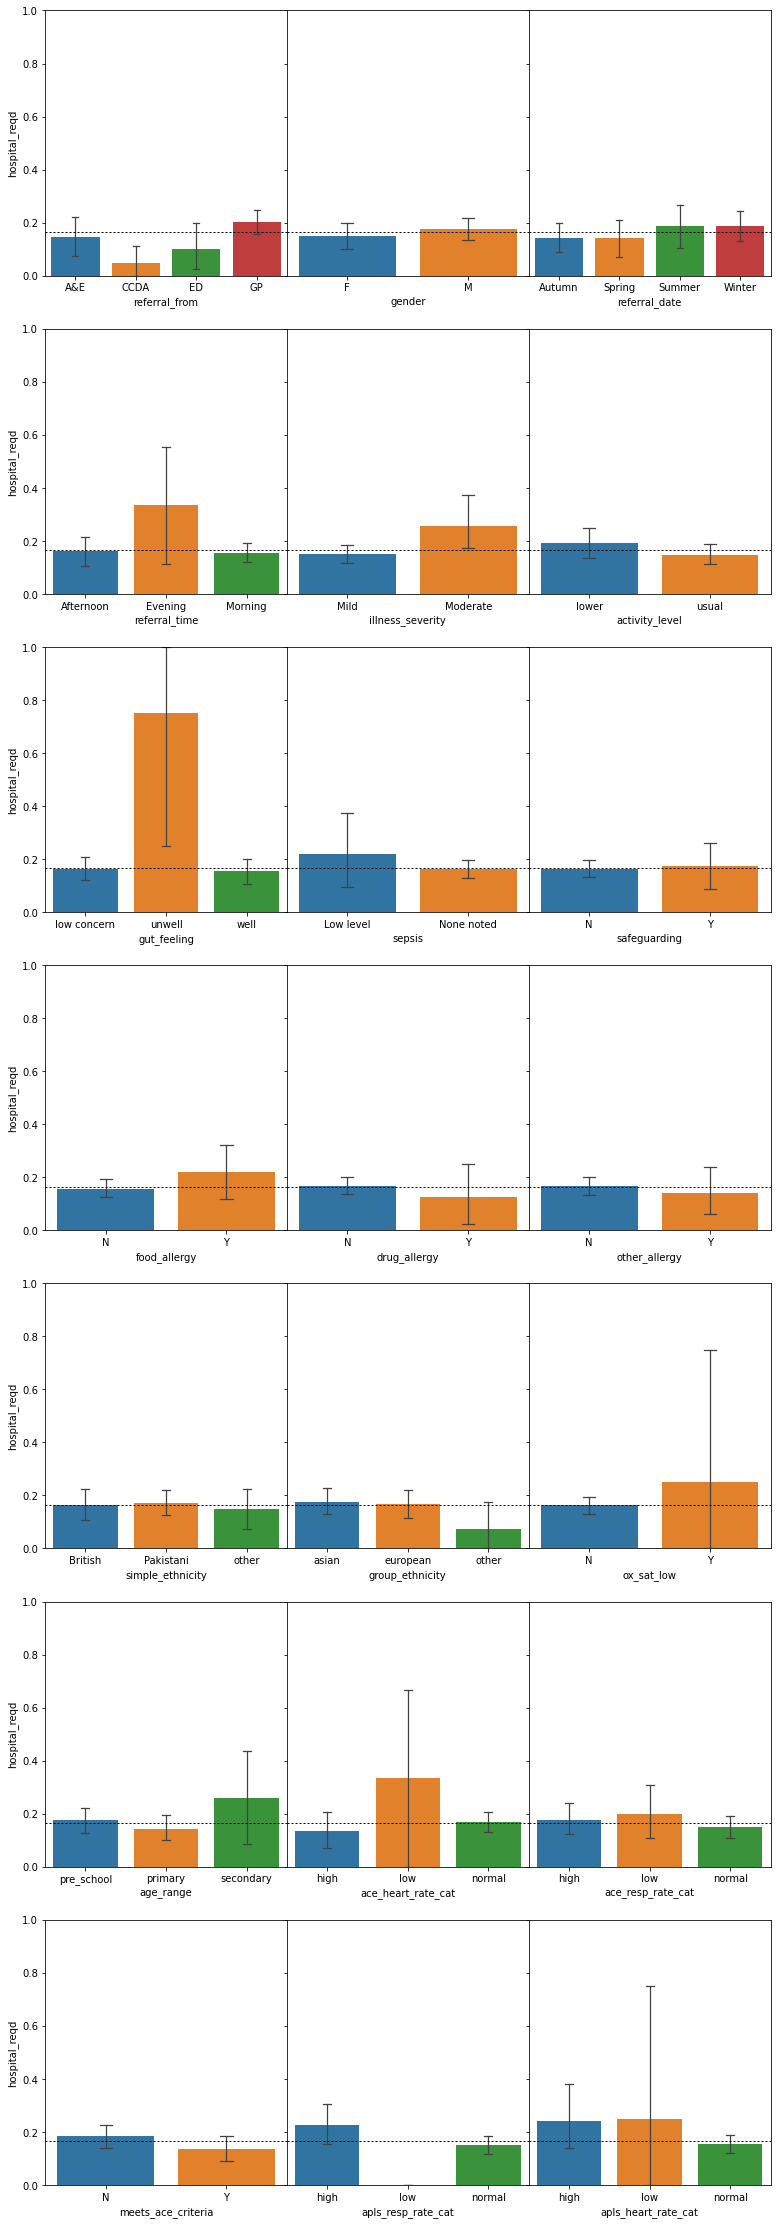

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
bar_plot_features = ['referral_from', 'gender', 'referral_date', 'referral_time',
                     'illness_severity', 'activity_level', 'gut_feeling',
                     'sepsis', 'safeguarding', 'food_allergy', 'drug_allergy',
                     'other_allergy', 'simple_ethnicity', 'group_ethnicity',
                     'ox_sat_low', 'age_range', 'ace_heart_rate_cat',
                     'ace_resp_rate_cat', 'meets_ace_criteria',
                     'apls_resp_rate_cat', 'apls_heart_rate_cat']

fig, axs = plt.subplots(ncols=3, nrows=7, figsize=(13,40))
plt.subplots_adjust(wspace=0)
for n, feature in enumerate(bar_plot_features):
    row, col = int(np.floor(n/3)), n%3
    ax = sns.barplot(data=ace_data,
                     x=feature,
                     y="hospital_reqd",
                     errwidth=1.25,
                     capsize=.1,
                     ax=axs[row, col])
    # draw line of overall mean hospital admissions
    ax.axhline(ace_data.hospital_reqd.mean(),
               color="black",
               linewidth=1,
               dashes=(2,2))
    # set y axis range to 0-1 for all subplots
    ax.set(ylim=(0,1))
    if col != 0:
        ax.set(yticklabels=[],
               ylabel="")

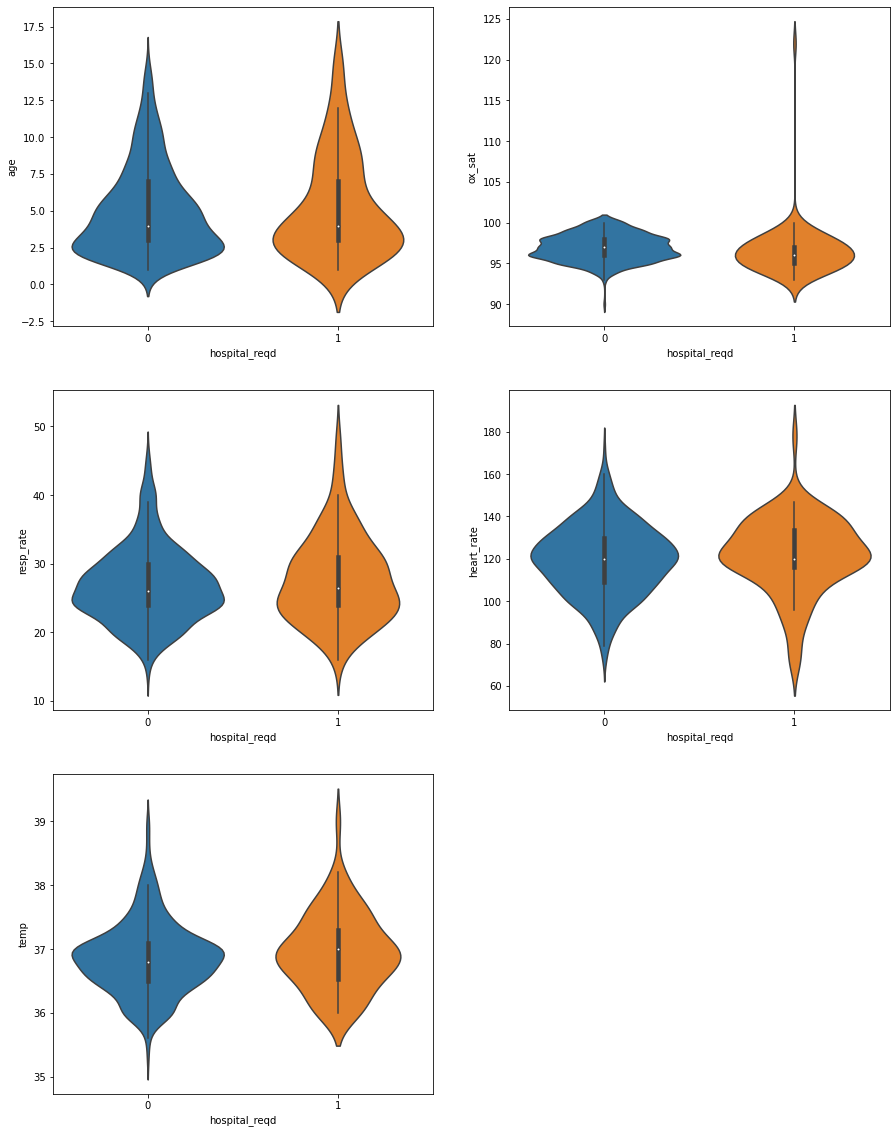

In [7]:
violin_features = ['age', 'ox_sat', 'resp_rate', 'heart_rate', 'temp']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15,20))
for n, feature in enumerate(violin_features):
    sns.violinplot(data=ace_data,
                   x="hospital_reqd",
                   y=feature,
                   ax=axs[int(np.floor(n/2)), n%2])

axs[2,1].axis("off")

for feature in violin_features:
    display(HTML(f"<h2>{feature}:</h2>"))
    data = ace_data[[feature, "hospital_reqd"]].dropna()
    r, p = stats.pearsonr(data[feature],
                          data.hospital_reqd)
    display(HTML(f"<h3>r: {r}, p: {p}"))
    if p < 0.05:
        display(HTML("<p style='color:green'>significant</p"))
    else:
        display(HTML("<p style='color:red'>not significant</p"))

hospital_reqd                          
                       mean       std       sem count
referral_from                                        
A&E                0.147368  0.356353  0.036561    95
CCDA               0.048387  0.216335  0.027475    62
ED                 0.100000  0.303822  0.048038    40
GP                 0.202658  0.402649  0.023208   301

,chi2,p,dof
0,10.67596,0.013614,3


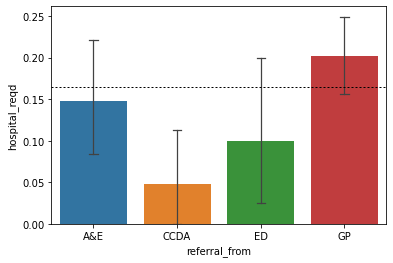

In [48]:
display(HTML(f"<h2>referral_from</h2>"))

temp_df = ace_data[["hospital_reqd" , "referral_from"]]
count_df = temp_df.groupby("referral_from").agg(["mean", np.std, stats.sem, "count"])
display(count_df)

size_data = (temp_df.groupby(["referral_from", "hospital_reqd"], as_index=False)
             .size()
             .pivot(index="referral_from", columns="hospital_reqd", values="size")
             .fillna(0))

chi2, p, dof, expected = chi2_contingency(size_data.values)
display(HTML("<h4>Chi<sup>2</sup> Results:</h4>"))
display(pd.DataFrame({ "chi2": chi2, "p": p, "dof": dof },
                         index=[0]))
if p < 0.05:
    display(HTML("<p style='color:green'>significant</p"))
else:
    display(HTML("<p style='color:red'>not significant</p"))


ax = sns.barplot(data=ace_data,
                 x="referral_from",
                 y="hospital_reqd",
                 errwidth=1.25,
                 capsize=.1)
# draw line of overall mean hospital admissions
ax.axhline(ace_data.hospital_reqd.mean(),
           color="black",
           linewidth=1,
           dashes=(2,2))

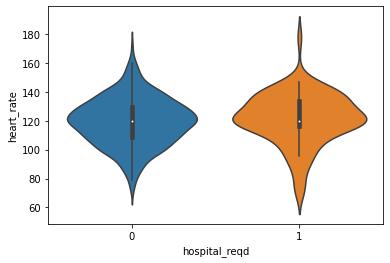

In [49]:
sns.violinplot(data=ace_data,
               x="hospital_reqd",
               y="heart_rate")

display(HTML(f"<h2>heart_rate</h2>"))
data = ace_data[["heart_rate", "hospital_reqd"]].dropna()
r, p = stats.pearsonr(data["heart_rate"],
                      data.hospital_reqd)
display(HTML(f"<h3>r: {r}, p: {p}"))
if p < 0.05:
    display(HTML("<p style='color:green'>significant</p"))
else:
    display(HTML("<p style='color:red'>not significant</p"))

In [63]:
import ipywidgets as widgets

out1 = widgets.Output()
out2 = widgets.Output()

tab = widgets.Accordion(children=[out1, out2])
tab.set_title(0, "referral_from")
tab.set_title(1, "heart_rate")
display(tab)

with out1:
    display(HTML(f"<h2>referral_from</h2>"))

    temp_df = ace_data[["hospital_reqd" , "referral_from"]]
    count_df = temp_df.groupby("referral_from").agg(["mean", np.std, stats.sem, "count"])
    display(count_df)

    size_data = (temp_df.groupby(["referral_from", "hospital_reqd"], as_index=False)
                 .size()
                 .pivot(index="referral_from", columns="hospital_reqd", values="size")
                 .fillna(0))

    chi2, p, dof, expected = chi2_contingency(size_data.values)
    display(HTML("<h4>Chi<sup>2</sup> Results:</h4>"))
    display(pd.DataFrame({ "chi2": chi2, "p": p, "dof": dof },data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAwkAAAiwCAYAAAB3WWzLAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOzdeZxkdX3v/9d7GhgQZJNWCDBCvETFqCitxB2NCxgjLlwVUSOJmUuuG4kSzf0lAuYmakgUcSNzvQQxEzHGDQ2KXhPFDWVQFsFgEEFGMPY4iKI4yMzn98c5DXV6ep3p6url9Xw86tF1ljr1qao+p+p9vt9zTqoKSZIkSRqzYtAFSJIkSVpYDAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjr6GhKSnJ3kR0m+Ncn0JDkzybVJrkjy8H7WI0mSJGl6/W5JOAc4aorpRwOHtLfVwHv6XI8kSZKkafQ1JFTVRcDGKWY5Bji3GhcDeybZr581SZIkSZraDgN+/v2BG3uG17fjbh4/Y5LVNK0N7Lrrroc/4AEPmJcCJc2d0dFRNmzYAEASXI+lxcf1WFpaLr300g1VNTx+/KBDQiYYVxPNWFVrgDUAIyMjtW7dun7WJanPRkZGcD2WFjfXY2nxS3LDROMHfXaj9cCBPcMHADcNqBZJkiRJDD4knA+8pD3L0W8Bt1bVVl2NJEmSJM2fvnY3SvIB4EhgnyTrgVOAHQGq6izgAuDpwLXAL4AT+lmPJEmSpOn1NSRU1XHTTC/g5f2sQZIkSdLsDLq7kSRJkqQFxpAgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqaPvISHJUUmuSXJtktdPMH2PJJ9IcnmSq5Kc0O+aJEmSJE2uryEhyRDwLuBo4FDguCSHjpvt5cDVVfVQ4Ejg75Ls1M+6JEmSJE2u3y0JjwSurarrquoO4DzgmHHzFHDPJAF2AzYCd/a5LkmSJEmT6HdI2B+4sWd4fTuu1zuBBwI3AVcCr66qLX2uS5IkSdIk+h0SMsG4Gjf8NOAy4NeAw4B3Jtl9qwUlq5OsS7JudHR0ruuUNA/WrFnDyMgIIyMjuB5Li5PrsbQ89DskrAcO7Bk+gKbFoNcJwEeqcS3wPeAB4xdUVWuqaqSqRoaHh/tWsKT+Wb16NevWrWPdunW4HkuLk+uxtDz0OyRcAhyS5OD2YOQXAOePm+f7wG8DJLkPcH/guj7XJUmSJGkSO/Rz4VV1Z5JXABcCQ8DZVXVVkhPb6WcBfwmck+RKmu5Jr6uqDf2sS5IkSdLk+hoSAKrqAuCCcePO6rl/E/DUftchSZIkaWa84rIkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkjh2mmyHJn0w1vareOnflSJIkSRq0mbQk3LO9jQB/BOzf3k4EDp3uwUmOSnJNkmuTvH6SeY5MclmSq5J8YeblS5IkSZpr07YkVNVpAEk+Azy8qn7WDp8KfGiqxyYZAt4FPAVYD1yS5Pyqurpnnj2BdwNHVdX3k9x7216KJEmSpLkwm2MSVgF39AzfARw0zWMeCVxbVddV1R3AecAx4+Z5IfCRqvo+QFX9aBY1SZIkSZpj07Yk9Hg/8PUkHwUKeDZw7jSP2R+4sWd4PXDEuHl+A9gxyedpujW9vaqmW64kSZKkPplxSKiqv0ryKeBx7agTquqb0zwsEy1qghoOB34b2AX4apKLq+o7nQUlq4HVAKtWrZpp2ZIWkDVr1rBmzRoARkdHB1yNpG3heiwtD6ka/5t9khmTvaeaXlUbJ3jMo4BTq+pp7fCftfO+qWee1wM7V9Wp7fD/BT5dVZMe7zAyMlLr1q2bUd2SFqaRkRFcj6XFzfVYWvySXFpVI+PHz6a70TeAA4FbaFoI9gS+304r4NcneMwlwCFJDgZ+ALyA5hiEXh8H3plkB2Anmu5Ib5tFXZIkSZLm0GxCwqeB86vqAoAkRwNPrqrXTPaAqrozySuAC4Eh4OyquirJie30s6rq20k+DVwBbAHeW1Xf2sbXI0mSJGk7zSYkPKKqThwbqKpPJfnL6R7UhooLxo07a9zw6cDps6hFkiRJUp/MJiRsSPLnwD/SdC96EfDjvlQlSZIkaWBmc52E44Bh4KPtbbgdJ0mSJGkJmc0pUDcCr06yW1Xd1seaJEmSJA3QjFsSkjw6ydXA1e3wQ5O8u2+VSZIkSRqI2XQ3ehvwNNrjEKrqcuDx/ShKkiRJ0uDMJiRQVTeOG7V5DmuRJEmStADM5uxGNyZ5NFBJdgJeBXy7P2VJkiRJGpTZtCScCLwc2B9YDxzWDkuSJElaQmbUkpBkCDijqo7vcz2SJEmSBmxGLQlVtRkYbrsZSZIkSVrCZnNMwvXAl5OcD/x8bGRVvXWui5IkSZI0OLMJCTe1txXAPftTjiRJkqRBm80Vl0+banqSd1TVK7e/JEmSJEmDNKvrJEzjMXO4LEmSJEkDMpchQZIkSdISYEiQJEmS1DGXISFzuCxJkiRJAzKXIeHtc7gsSZIkSQMy7dmNknwCqMmmV9Uz27/nzF1ZkiRJkgZlJqdA/du+VyFJkiRpwZg2JFTVF+ajEEmSJEkLw4wvppbkEOBNwKHAzmPjq+rX+1CXJEmSpAGZzYHL/wC8B7gTeCJwLvD+fhQlSZIkaXBmExJ2qarPAamqG6rqVOBJ/SlLkiRJ0qDMuLsR8MskK4D/TPIK4AfAvftTliRJkqRBmU1LwknAPYBXAYcDLwJe0oeaJEmSJA3QbELCQVV1W1Wtr6oTquq5wKp+FSZJkiRpMGYTEv5shuMkSZIkLWIzueLy0cDTgf2TnNkzaXeaMx1JkiRJWkJmcuDyTcA64JnApT3jfwb8cT+KkiRJkjQ4M7ni8uXA5UnWVpUtB5IkSdISN5PuRv9cVc8Dvpmkxk+vqof0pTJJkiRJAzGT7kavbv8+o5+FSJIkSVoYpj27UVXd3P69AdgEPBR4CLCpHSdJkiRpCZnxKVCTvAz4OvAc4Fjg4iS/36/CJEmSJA3GTLobjTkZeFhV/Rggyb2ArwBn96MwSZIkSYMxm4uprac57emYnwE3zm05kiRJkgZtNi0JPwC+luTjQAHHAF9P8icAVfXWPtQnSZIkaZ7NJiR8t72N+Xj7955zV44kSZKkQZtxSKiq08buJ1kB7FZVP+1LVZIkSZIGZjZnN/qnJLsn2RW4Grgmycn9K02SJEnSIMzmwOVD25aDZwEXAKuAF/ejKEmSJEmDM5uQsGOSHWlCwser6lc0BzBLkiRJWkJmExL+Hrge2BW4KMl9AY9JkCRJkpaYGYeEqjqzqvavqqdX4wbgidM9LslRSa5Jcm2S108x3yOSbE5y7ExrkiRJkjT3ZnPg8h5J3ppkXXv7O5pWhakeMwS8CzgaOBQ4Lsmhk8z3FuDCWVUvSZIkac7NprvR2TRXWX5ee/sp8A/TPOaRwLVVdV1V3QGcR3MRtvFeCXwY+NEs6pEkSZLUB7O5mNr9quq5PcOnJblsmsfsD9zYM7weOKJ3hiT7A88GngQ8Yhb1SJIkSeqD2bQk3J7ksWMDSR4D3D7NYzLBuPFnRDoDeF1VbZ5yQcnqsa5Oo6OjM6lX0gKzZs0aRkZGGBkZwfVYWpxcj6XlIVUzO4tpksOA9wF7tKNuAX6vqq6Y4jGPAk6tqqe1w38GUFVv6pnne9wdJvYBfgGsrqqPTbbckZGRWrdu3YzqlrQwjYyM4HosLW6ux9Lil+TSqhoZP3423Y2+DfwNcD9gT+BWmmsmTBoSgEuAQ5IcDPwAeAHwwt4ZqurgniLPAT45VUCQJEmS1F+zCQkfB34CfIPmB/+0qurOJK+gOWvREHB2VV2V5MR2+lmzK1eSJElSv80mJBxQVUfN9gmq6gLggnHjJgwHVfXS2S5fkiRJ0tyazYHLX0ny4L5VIkmSJGlBmLYlIcmVNGck2gE4Icl1wCaag42rqh7S3xIlSZIkzaeZdDd6Rt+rkCRJkrRgTBsSquqG+ShEkiRJ0sIwm2MSJEmSJC0DhgRJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdOwy6AEmSJC1vmzdvZnR09K77GzduZO+992ZoaAiA4eHhu+5rfhgSJEmSNFCjo6Mcf/zxk05fu3Yt++677zxWJEOCJEmSBmp4eJi1a9cCTWA46aSTOOOMMxgeHr5ruuaXIUGSJEkDNTQ0tFVLwfDwsK0HA+SBy5IkSZI6bEmQlhkPDpMkSdMxJEjLjAeHSZI0WIthh50hQVpmPDhMkqTBWgw77AwJ0jLjwWGSJA3WYthhZ0iQJEmS5tFi2GHn2Y0kSZIkdRgSJEmSJHXY3WgKi+HIc0mSJGmuGRKmsBiOPJckzZ/enUfjx4/fkdTLnUqSFhtDwhQWw5HnkqT5M93Oo8m4U0nSYtP3kJDkKODtwBDw3qp687jpxwOvawdvA/6oqi7vd10zsRiOPJckzZ/enUe9JtqRNP5x0kzZ3VkLQV9DQpIh4F3AU4D1wCVJzq+qq3tm+x7whKq6JcnRwBrgiH7WJUnStpho51EvdyRpLtjdWQtBv1sSHglcW1XXASQ5DzgGuCskVNVXeua/GDigzzVJkiQtWHZ31kLQ75CwP3Bjz/B6pm4l+APgU32tSOqxGJp0v/D4J/Rt2T8B2HEHvva857Nnn57jCRd9oU9LXng8qFXqj8WwrZ5LdnfWQtDvkJAJxtWEMyZPpAkJj51k+mpgNcCqVavmqj4tczbpzq81a9awZs0agAl/TC92HtSq5WAQ67Hbamn+9TskrAcO7Bk+ALhp/ExJHgK8Fzi6qn480YKqag3N8QqMjIxMGDSk2bJJd36tXr2a1atXAzAyMjLgauaeB7VqORjEeuy2Wpp//Q4JlwCHJDkY+AHwAuCFvTMkWQV8BHhxVX2nz/VIHTbpai55UKvUH26rpfnX15BQVXcmeQVwIc0pUM+uqquSnNhOPwt4A3Av4N1JAO6sqqW3i1GSJGmJeMw7HtO3ZefnYSUrOfacY6ld+9N55Muv/PKs5l+Oxwf2/ToJVXUBcMG4cWf13H8Z8LJ+1yFJkiRpZlYMugBJkiRJC0vfWxIkSZqJ77/xwYMuYZtt+OUKYB9uOvNp3LHzlkGXs81WveHKQZcgaYGwJUGSJElShyFBkiRJUldVLbrbfvvtV0CdcsopVVV1yimnzMvwQQcdVDfffPO8PZ/D8zv8mte8pp70pCfVa17zmgVRz9jw761aVUD93qpV9fnHPX5Ohz/2uMfXQQcd1Lflf/5xj5/09Q1qPR7E8M0333zX+7wQ6lnIwycdOVw3nPabddKRw4tqePVj711ArX7svRdEPds6PNvPy+/j5ft6H33mo+uAow4ooA446oA5HT7wtw+sJz3pSXXgbx/Yl+UfcNQBs369/fh+HBt+/qpV9aQnPame38fv+6leH7CuJvi9napisRkZGal169bN63P+8Ic/5Pjjj/eqjkvYQv2M5/q0a1uAn7b3fwqcs+MOvPRXd7J7O2535raJcbLTro2MjDDf6/GgLNT/rYVmsR+TcPLX9uH0IzawzzI6JmEQ6/FyW58W6uvt+ylQP7uSTU/ZtGxOgXrmjjvwql/dOZBToCa5tCa4/IAHLkvLzE9pNka9zukZ7udGSpIkLQ6GBGmZ2Z0mCEDTqnAbsBt3tx7sPvHDJEnSMmJIkJaZFdBpKdh7QHXM1uEnnzvoErbZik23sTvwu3/9Ebas3G3Q5WyzS09/yaBLkCTNkyUVEvr5I2K+vuT9EpYkSdKgLamQIEmSBm+x77Sb7Q67fh50P18X6vNCehrPkCBJ0gxtLrhl09bn/9rYjts4wTSAvVZuYSh9LU2S5pQhQZKkGbplU3Oq08m86bKJj/JZ7KdGlTS3xp+OvPcvzP3pyLeFIUGSpBnaa+UWTj9iw1bjNxfcescK9thp4haDvVYaECTdbTGcjtyQIEnSDA2FSVsE7rOLQUDSzCyG05EbEiRJkqR5tBhORz7o7k6SJEmSFhhbEtSxefNmRkdH77q/ceNG9t57b4aGhgAYHh6+674kSZKWJkOCOkZHRzn++OMnnb527Vr23XffeaxIkiRJ882QoI7h4WHWrl0LNIHhpJNO4owzzmB4ePiu6ZIkSXNqC+T29tRgt3PX39CMq13KTvLzzJCgjqGhoa1aCoaHh209kGaitrDijl9sNTp3/PyuvxN9x23Z6R4Qv/0kLV+5Paz87MrOuJVfunt401M2UbvWfJe1rBkStKg85h2P6duy8/OwkpUce86xfdsQffmVX+7LcrUwrLjjF+x+1YcnnX7P//z0hON/+qDnsmXlbv0qS5IWvNql2PSUTe0A8EtgZ2gbEpqWBM0rQ4IkzZEtO92Dnz7ouVtPqC3kV7dTO+4yYYvBlp3uMQ/VSdICtoLuDjr3mwycIUGS5kpWTN4isPNCuDSOtEj1dOWbqPueXfakuWdIkCRJC9pEXfl6u+/ZZU+ae4YESZK0oHW68k3Qfc8ue9LcMyRIkqSFbXxXPrvvSX1nSJiKfSAlSZK0DBkSpmAfSEmSNN82F9yyqdkJuXHcX4C9Vm5hKAMpTcuIIWEK9oGUJEnz7ZZNKzj5a/t0xr3psr3vun/6ERvYZ+ct812WlhlDwlTsAylJkubZXiu3cPoRG4CmVeHWO1awx053tx7stdKAoP4zJEiSJC0gQ6HTUnCfXQwFmn8edStJkiSpw5AgSZIkqcOQIEmSJKnDYxIWue+/8cF9W/aGX64A9uGmM5/GHX06i8KqN1zZl+VKkiRp29mSIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDA5e1vG2B3N5ewvJ27vobmnG1SxmlJUnSsmNI0LKW28PKz67sjFv5pbuHNz1lE7VrzXdZkiRJA2VI0LJWuxSbnrKpHQB+CewMbUNC05IgSZK0zBgStLytoNtSsNvgSpEkSVoo+t7bOslRSa5Jcm2S108wPUnObKdfkeTh/a5JkiRJ0uT6GhKSDAHvAo4GDgWOS3LouNmOBg5pb6uB9/SzJkmSJElT63dLwiOBa6vquqq6AzgPOGbcPMcA51bjYmDPJPv1uS5JkiRJk+j3MQn7Azf2DK8HjpjBPPsDN/e3NE1kc8Etm5rsuHHcX4C9Vm5hKAMpTZIkSfMkVf07e0uS/w48rape1g6/GHhkVb2yZ55/Bd5UVV9qhz8H/GlVXTpuWatpuiMB3B+4pm+FT24fYMMAnneQlttrXm6vF+b3Ne8DDLf3dwG+MU/PuxAsx/+t5Wa5fMYLYT1eLu/1mOX2emH5veZBvt77VtXw+JH9bklYDxzYM3wAcNM2zENVrQHWzHWBs5FkXVWNDLKG+bbcXvNye72wPF/zIPg+L31+xvNnub3Xy+31wvJ7zQvx9fb7mIRLgEOSHJxkJ+AFwPnj5jkfeEl7lqPfAm6tKrsaSZIkSQPS15aEqrozySuAC4Eh4OyquirJie30s4ALgKcD1wK/AE7oZ02SJEmSptb3i6lV1QU0QaB33Fk99wt4eb/rmCMD7e40IMvtNS+31wvL8zUPgu/z0udnPH+W23u93F4vLL/XvOBeb18PXJYkSZK0+PT9isuSJEmSFhdDQo8kz05SSR7QM+6QJF9PckWS/zdu/iOT3Jrksp7bk+e/8plJsm+S85J8N8nVSS5I8hvt7YIk1yb5dpJ/TnKfntf3zSTXJLkoyTPGLXOHJBuSvGlQr2tbJNk87nN7fTv+8+1rvSLJfyR5Z5I9B1zunGg/039Kcl2SS5N8tf2f7/2cv53klEHXupRM8L920KBr0txpvzPe3zO8Q5LRJJ8cZF0L1UTfs1PMe1KSe8xHXfMlyf+X5Kr2O+ayJOOvHTXVY5859l21EG3Pa1sKkrwtyUk9wxcmeW/P8N8lecN0n2GSg5K8sI+lzljfj0lYZI4DvkRzFqZT23GvB95TVf+Q5OAJHvPFqnrGBOMXlCQBPgq8r6pe0I47DLgPcDbwJ1X1iXb8E7n7HNh3vb52/o8lub2qPtdOfyrNNSuel+R/1eLpv3Z7VR02ybTjq2pde0auNwEfB54wb5X1Qfv5f4zm839hO+6+wDOBW2g/5yS7Apcl+eT4a5Vom031v6bF7+fAbybZpapuB54C/GDANS1kE33PTuYk4B9pTmqy6CV5FPAM4OFVtSnJPsBOM3zsDlV1PlufIXJB2J7XNh/a78BU1ZY+Ps1XgP8OnJFkBc11D3bvmf5o4KSq+to0yzkIeCHwTzN94iRDVbV5duVOz5aEVpLdgMcAf0Cz8RpzB821G6iq7w2gtLnyROBX4w4avww4BPjqWEBox/97VX1r/ALa+d8IvKJn9HHA24HvA7/Vl8oHpKruAP4UWJXkoYOuZzs9Cbhj3Od/Q1W9o3emqvo5cClwv3muT1rMPgX8Tnv/OOADA6xlwZroe7ZtyfxkzzzvTPLSJK8Cfg349yT/3k67rWe+Y5Oc094/J8l7kvx721L6hCRnty2j5/Q85rYkf5Xk8iQXJ7nPPLzsXvsBG6pqE0BVbaiqm5Jcn+QtaXotfD3Jf+t5XW9tX/9b2vflnT3TzkzylfY1H9uOX5Hk3e0e/U+m6SVw7IBf2z5tbSNJPt/ePzXJ+5J8pp3nOUn+JsmVST6dZMd2vuuT/HWalu91SR7e7qH/btozZbbznZzkkrYV47R23EHt/8C7aS74dyD99WWaIADwIOBbwM+S7JVkJfBA4KHTfYbAm4HHta0xf5xkKMnpPa/vf7SPP7L9n/8n4Mp+vCBDwt2eBXy6qr4DbEzy8Hb8d4FXZ1w3mx5jH+TYbaH+uPpNmh9/Mx0/mW8ADwBIsgvw28Anab4Uj9vOGufTLuM+t+dPNFObzC+nfc2L2IOYwVVRk9yLJuxd1feKlo/e/7WPDroY9cV5wAuS7Aw8BJhuT+Fy9Swm/p7dSlWdSXNh1SdW1RNnsOy9aHaG/DHwCeBtNNu9B6dpBQfYFbi4qh4KXAT84Ta+jm31GeDAJN9pf8j3tlD/tKoeCbwTOKNn/G8AT66q10ywvP2Ax9LswX9zO+45NHuiHwy8DHjUnL6CyU312iZzP5pwfQxNi9G/V9WDgdu5O3QD3FhVjwK+CJwDHEvzPfVGgCRPpdnh+UjgMODwJI9vH3t/4NyqelhV3bB9L3FqVXUTcGeSVTRh4as024JHASPAFTQ7nntN9Bm+nqZ1/7CqehtNqL61qh4BPAL4w9zds+WRwP9XVYf24zXZ3ehux3H3inkecFzTOsXTgYcBn0mykeZD/y5372ldFN2N5lB67j+DZqX+RZIPA3+R5I/70eTVB7PpApLpZ1lckryLZsN0B3AyTdj9JrAFeHNVGRLmjt2NlriquiLNsSbHMe6U3+rY6nsW+Nc5WvYnqqqSXAn8V1VdCZDkKpofzZfRbO/GWi0upekaNm+q6rYkhwOPo2nd/2Du7p/+gZ6/b+t52Iem+E79WNt95uqeVpHHto/ZAvxwrBWm36Z5bZP5VFX9qv3MhoBPt+OvpPnMxpzfM363qvoZzR76X6Y5ZvCp7e2b7Xy70YSG7wM3VNXF2/XiZmesNeHRwFuB/dv7t9J0Rxpvos9wvKcCD+lpadiD5vXdAXy9n71cDAnctff0STT9Sovmn7WADcBFVXVjkmfT/KOeBVzQbowGVvM2uIomfU80fjb97R8GfLu9fxzwmCTXt8P3otk4/L8JHrcoJRmi2SPz7enmXeCuAp47NlBVL2+bgNe1o5Zb2JXm2vnA3wJH0mwL1WOK79nz6fZq2HmKxfQe8zZ+vk3t3y0998eGx37r/KrnuLnNDOA3UPuD//PA59sfx783Nql3tp77P59icb2vM+P+zrtJXtud3P35TviZVdWWJL2fTe9ndtd8TP7ZBnhTVf1978Lb4D7V+9cPX6EJBQ+m6W50I/Aa4Kc0x3+O3zZM9BmOF+CVVXVhZ2RyJH1+fXY3ahxL0xx136o6qKoOBL5Hc9DNMUn2qKr/AE4H/o6mWWyx+TdgZZK7mleTPILmStePTvI7PeOPSvLg8QtI8hDgL4B3JdmdZo/FqvY9O4jmoniLqcvRlNo+kW+iaeq8YtD1bKd/A3ZO8kc945bUWUOkATsbeOPYHmxtZbLvWYBDk6xMsgdNF9YxPwPu2TP8X0kemOag0GfPT9lzJ8n9kxzSM+owYKwLzPN7/n51O57mS8Bz0xybcB+a0Np3U7y264HD23HPpT8uBH4/zTEvJNk/yb379FzT+TJNL4uNVbW5qjYCe9J0OZrp5zr+//5C4I96jtP4jTQnGek7WxIax3F3X7AxH6Y5yOQfgYuT/IJmg3YCcE6Sx7XzPS7JZT2P+99V9S99rnfW2paPZ9Mcdf964Jc0K+9JNP/QZyQ5A/gVTb+5V9Mk3rFuKPcAfgS8qqo+l+SlwL+NHaTU+jjwN0lWjhu/EO0y7nP7dFWNNY2uTbIJWEnTKnLMfBc319rP/1nA25L8KTBKswfidQMtTFoiqmo9zUkcNLHJvmdfCPwzzffOf3J3lxForkD7qSQ3t8clvJ6mu9CNNHtpd+t30XNsN+AdbReZO2l20q2m+Q5emeRrNDtvt2dn24dpgta3gO/Q9Im/dTuWN1OTvbYHAv83yf+iT8fqVNVnkjwQ+Grbw+M24EU0rUXz7Uqasxr907hxu1XVhhn2QLmC5tiGy2mOwXg7Tferb6RZwCjN8T195xWXJUmSBqTtsjtSVRvmaHm7tccI3Av4OvCYqvrhXCxby4stCZIkSUvHJ9s9+jsBf2lA0LayJUGSJElShwcuS5IkSeowJEiSJEnqMCRIkiRJ6jAkSJLmTZJzeq4cKklaoAwJ2i5JXpXk20nW9mn5t00z/fQkVyU5vR/PL2mwkngWPmkGBv19PG7eaXcGJHlpkl/b/srUL258Na324h2pqi0TTP6fwNFV9b0Jpk20rB2q6s7JhrfB/wCGx1+8bQ6WKy17Sf4COJ7m4lUbgEuBjwLvAoaBXwB/WFX/keQc4KfACLAv8KdV9S/t9uMdwJNoLkiZnuUfDryV5kJMG4CXVtXNST4PfAV4DHA+zZXupWVvgX8fz9ZLaS76dtM8PqdmwZCgCSU5CPgU8O80lxP/WJJn0FyF+KNVdUqSs4BfB85PcjbN1THfATyY5n/r1Kr6eHt15t8BdgZ2TXLuuOFn0lyteS9gR+DPq+rjM6jxfGBX4GtJ3gQcDWwEHkZzZcL3A2fRXC36u8DvV9Ut7Q+Qb9JcKn4YeAnwZ23dH6yqP9/mN05aIpKMAM+lWZ92AL5BExLWACdW1X8mOQJ4N00AANgPeCzwAJof9/8CPBu4P836dR/gauDsJDvSbC+OqarRJM8H/gr4/XZZe1bVE/r+QqUFbpF8H0+1M+ANwO8Cu9CE//9Bs20ZAdYmub19XYcywU6DbXnPNEeqypu3rW40lwDfAvwW8FSaDU5ouqh9Enh8O9/1wD7t/b8GXtTe35PmkvC70uwtWA/s3U4bP7wDsHt7fx+ay7mPXcPjtmnqvK3n/jltbUPt8BXAE9r7bwTOaO9/HnhLe//VNHsx9qPZ4K4H7jXo99+bt0HfgJOA03qG3wr8OXA7cFnP7dvt9HOA43vm/1n79wyagD42/iPAscBv0rQ8jC3nSuAz7TyfH1t3vXlb7rfF8H0MPAf4LDAE/BrwE+DYdtrePfO9H/jd9v7naa40DU0g+QpNzwCA5wNnD/q9X+43WxI0lRuq6uIkf0uzYfpmO3434BDgonHzPxV4ZpLXtsM7A6va+5+tqo098/YOB/jrJI+n2RDuT7PHcVuuEvmhqtqcZA+aPZFfaMe/D/hQz3znt3+vBK6qdm9FkuuAA4Efb8NzS0tJJhi3AvhJVR02yWN6u/31Pn6iq3aGZt171CTL+vm0FUrLx0L/Pn488IGq2gzclOTfeqY9Mcmf0rTq7w1cBXxi3OPvT7Pj4LNNowRDgK0IA2ZI0FTGvqQDvKmq/n6a+QM8t6qu6YxsuiSM/8LvHT6eptvP4VX1qyTX02zQtqfm6Yz9mNlC94fNFlwvJIAvAX/fduXbgaZLwv8Bvpfkv1fVh9ouBg+pqsunWM5FwP9ouzXcG3gi8E/ANcBwkkdV1Vfb7ke/UVVX9fNFSYvUYvg+3mpnQJKdabokjlTVjUlOnWR50+000AB4diPNxIXA7yfZDSDJ/knuPcl8r2x/OJDkYTNc/h7Aj9oN0hOB+25vwVV1K3BLkse1o14MfGGKh0jqUVWX0LS4XU7TRWgdcCvNj4g/SHI5zR7BY6ZZ1EeB/6RptXsP7XpYVXfQdDt6S7usy4BHz/kLkZaWhfp9fBHwgiRDSfaj2RkAdweCDW3NvWc8+hlwz/b+XTsN2np3TPKgGT63+sQ9pppWVX0myQOBr7bbm9uAFwE/GjfrX9L0P76i3TBdDzxjBk+xFvhEknU0PxT+Y04Kh98DzkpyD+A64IQ5Wq60XPxtVZ3arkMXAX9XzZlTjho/Y1W9dNzwbu3fAl4x0cKr6jKabgrjxx+5vYVLS9EC/j7+KM1By1fSHP8wtjPgJ0n+Tzv+euCSnsecQ/MdPXbg8rHAmW134R3a+m1ZHKCxg1EkSepI8k80ZxzZGXhfVb1pwCVJkuaJIUGSJElSh92NtOAleTDNadN6baqqIwZRjyRJy5Hfx8uLLQmSJEmSOjy7kSRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpI6+hoQkZyf5UZJvTTI9Sc5Mcm2SK5I8vJ/1SJIkSZpev1sSzgGOmmL60cAh7W018J4+1yNJkiRpGn0NCVV1EbBxilmOAc6txsXAnkn262dNkiRJkqY26GMS9gdu7Ble346TJEmSNCA7DPj5M8G4mnDGZDVNlyR23XXXwx/wgAf0sy5JfTA6OsqGDRsASILrsbT4uB5LS8ull166oaqGx48fdEhYDxzYM3wAcNNEM1bVGmANwMjISK1bt67/1Unqm5GREVyPpcXN9Vha/JLcMNH4QXc3Oh94SXuWo98Cbq2qmwdckyRJkrSs9bUlIckHgCOBfZKsB04BdgSoqrOAC4CnA9cCvwBO6Gc9kiRJkqbX15BQVcdNM72Al/ezBkmSJEmzM+juRpIkSZIWGEOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpI6+h4QkRyW5Jsm1SV4/wfQ9knwiyeVJrkpyQr9rkiRJkjS5voaEJEPAu4CjgUOB45IcOm62lwNXV9VDgSOBv0uyUz/rkiRJkjS5frckPBK4tqquq6o7gPOAY8bNU8A9kwTYDdgI3NnnuiRJkiRNot8hYX/gxp7h9e24Xu8EHgjcBFwJvLqqtvS5LkmSJEmT6HdIyATjatzw04DLgF8DDgPemWT3rRaUrE6yLsm60dHRua5T0jxYs2YNIyMjjIyM4HosLU6ux9Ly0O+QsB44sGf4AJoWg14nAB+pxrXA94AHjF9QVa2pqpGqGhkeHu5bwZL6Z/Xq1axbt45169bheiwtTq7H0vLQ75BwCXBIkoPbg5FfAJw/bp7vA78NkOQ+wP2B6/pclyRJkqRJ7NDPhVfVnUleAVwIDAFnV9VVSU5sp58F/CVwTpIrabonva6qNvSzLkmSJEmT62tIAKiqC4ALxo07q+f+TcBT+12HJEmSpJnxisuSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjp2mG6GJH8y1fSqeus0jz8KeDswBLy3qt48wTxHAmcAOwIbquoJ09UlSZIkqT+mDQnAPdu/9wceAZzfDv8ucNFUD0wyBLwLeAqwHrgkyflVdXXPPHsC7waOqqrvJ7n3rF6BJEmSpDk1bUioqtMAknwGeHhV/awdPhX40DQPfyRwbVVd1z7mPOAY4OqeeV4IfKSqvt8+349m+RokSZIkzaHZHJOwCrijZ/gO4KBpHrM/cGPP8Pp2XK/fAPZK8vkklyZ5ySxqkiRJkjTHZtLdaMz7ga8n+ShQwLOBc6d5TCYYVxPUcDjw28AuwFeTXFxV3+ksKFkNrAZYtWrVLMqWtFCsWbOGNWvWADA6OjrgaiRtC9djaXlI1fjf7FPMnDwceFw7eFFVfXOa+R8FnFpVT2uH/wygqt7UM8/rgZ2r6tR2+P8Cn66qSbsyjYyM1Lp162Zct6SFZ2RkBNdjaXFzPZYWvySXVtXI+PEzbklIsjdwfXvrHQdAVW2c4GGXAIckORj4AfACmmMQen0ceGeSHYCdgCOAt820LkmSJElzazbdjb4BHAjcQtONaE/g++20An59/AOq6s4krwAupDkF6tlVdVWSE9vpZ1XVt5N8GrgC2EJzmtRvbePrkSRJkrSdZhMSPg2cX1UXACQ5GnhyVb1mqge1818wbtxZ44ZPB06fRS2SJEmS+mQ2Zzd6xFhAAKiqTwFe9EySJElaYmbTkrAhyZ8D/0jTvehFwI/7UpUkSZKkgZlNS8JxwDDw0fY23I6TJEmStITMuCWhPXvRq5PsVlW39bEmSZIkSQM045aEJI9OcjVwdTv80CTv7ltlkiRJkgZiNt2N3gY8jfY4hKq6HHh8P4qSJEmSNDizOXCZqroxSe+ozXNbjpajzZs3Mzo62hneuHEje++9N0NDQ3eNHx4e7gxLkiSpP2YTEm5M8migkuwEvAr4dn/K0nIyOjrK8ccfP+18a9euZd99952HiiRJkpa32YSEE4G3A/sD64HPAC/vR1FaXoaHh1m7du1dw6Ojo5x00kmcccYZDA8Pd+aTJElS/80oJCQZAs6oqul390qzNDQ0NGELwfDwsC0HkiRJAzCjA5erajMw3HYzkiRJkrSEzaa70fXAl5OcD/x8bGRVvXWui5IkSZI0OLMJCTe1txXAPftTjiRJkqRBm80Vl0+banqSd1TVK7e/JEmSJEmDNJuLqU3nMXO4LEmSJEkDMpchQZIkSdISYEiQJEmS1DGXISFzuCxJkiRJAzKXIeHtc7gsSZIkSQMy7dmNknwCqMmmV9Uz27/nzF1ZkiRJkgZlJqdA/du+VyFJkiRpwZg2JFTVF+ajEEmSJEkLw4wvppbkEOBNwKHAzmPjq+rX+1CXJEmSpAGZzYHL/wC8B7gTeCJwLvD+fhQlSZIkaXBmExJ2qarPAamqG6rqVOBJ/SlLkiRJ0qDMuLsR8MskK4D/TPIK4AfAvftTliRJkqRBmU1LwknAPYBXAYcDLwJe0oeaJEmSJA3QbELCQVV1W1Wtr6oTquq5wKp+FSZJkiRpMGYTEv5shuMkSZIkLWIzueLy0cDTgf2TnNkzaXeaMx1JkiRJWkJmcuDyTcA64JnApT3jfwb8cT+KkiRJkjQ4M7ni8uXA5UnWVpUtB5IkSdISN5PuRv9cVc8Dvpmkxk+vqof0pTJJkiRJAzGT7kavbv8+o5+FSJIkSVoYpj27UVXd3P69AdgEPBR4CLCpHSdJkiRpCZnxKVCTvAz4OvAc4Fjg4iS/36/CJEmSJA3GTLobjTkZeFhV/Rggyb2ArwBn96MwSZIkSYMxm4uprac57emYnwE3zm05kiRJkgZtNi0JPwC+luTjQAHHAF9P8icAVfXWPtQnSZIkaZ7NJiR8t72N+Xj7955zV44kSZKkQZtxSKiq08buJ1kB7FZVP+1LVZIkSZIGZjZnN/qnJLsn2RW4Grgmycn9K02SJEnSIMzmwOVD25aDZwEXAKuAF/ejKEmSJEmDM5uQsGOSHWlCwser6lc0BzBLkiRJWkJmExL+Hrge2BW4KMl9AY9JkCRJkpaYGYeEqjqzqvavqqdX4wbgidM9LslRSa5Jcm2S108x3yOSbE5y7ExrkiRJkjT3ZnPg8h5J3ppkXXv7O5pWhakeMwS8CzgaOBQ4Lsmhk8z3FuDCWVUvSZIkac7NprvR2TRXWX5ee/sp8A/TPOaRwLVVdV1V3QGcR3MRtvFeCXwY+NEs6pEkSZLUB7O5mNr9quq5PcOnJblsmsfsD9zYM7weOKJ3hiT7A88GngQ8YrIFJVkNrAZYtWrVzKuWtGCsWbOGNWvWADA6OjrgaiRtC9djaXmYTUvC7UkeOzaQ5DHA7dM8JhOMG39GpDOA11XV5qkWVFVrqmqkqkaGh4dnUq+kBWb16tWsW7eOdevW4XosLU6ux9LyMJuWhD8C3pdkj3b4FuD3pnnMeuDAnuEDgJvGzTMCnJcEYB/g6UnurKqPzaI2SZIkSXNkNiHh28DfAPcD9gRupblmwhVTPOYS4JAkBwM/AF4AvLB3hqo6eOx+knOATxoQJEmSpMGZTUj4OPAT4Bs0P/inVVV3JnkFzVmLhoCzq+qqJCe208+aXbmSJEmS+m02IeGAqjpqtk9QVRcAF4wbN2E4qKqXznb5kiRJkubWbELCV5I8uKqu7Fs1kiQtYJs3b57wjD6bN29m48aN7L333gwNDW01fXh4eMLxkrRQTRsSklxJc0aiHYATklwHbKI5c1FV1UP6W6IkSQvD6Ogoxx9//Kwft3btWvbdd98+VCRJ/TGTloRn9L0KSZIWgeHhYdauXbvV+NHRUU466STOOOOMCU8L6qlCJS0204aEqrphPgqRJGmhGxoamrJFYHh42BYDSUvCbC6mJkmSJGkZMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqmMnF1LQMff+NDx7Yc2/45QpgH24682ncsfOWgdSw6g1XDuR5JUmSFgJbEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdeww6AIkSQL4/hsfPOgSttmGX64A9uGmM5/GHTtvGXQ522zVG64cdAmSFghDgiRJUmvz5s2Mjo5OOH7jxo3svffeDA0NbTV9eHh4wvHSYmVIkCRJao2OjnL88cfP+nFr165l33337UNF0mAYEiRJklrDw8OsXbt2q/Gjo6OcdNJJnHHGGQwPD0/4OGkpMSRIkiS1hoaGpmwRGB4etsVAy4JnN5IkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1OHZjbbT+IuuTHaxFS+yIkmSpMXCkLCdZnrRFS+yIkmSpMWi7yEhyVHA24Eh4L1V9eZx048HXtcO3gb8UVVd3u+65sr4i65MdrEVL7IiSZKkxaKvISHJEPAu4CnAeuCSJOdX1dU9s30PeEJV3ZLkaGANcEQ/65pLk110xYutSJIkabHq94HLjwSurarrquoO4DzgmN4ZquorVXVLO3gxcECfa5IkSZI0hX6HhP2BG3uG17fjJvMHwKcmmpBkdZJ1Sdb1HigsafFYs2YNIyMjjIyM4HosLU6ux9Ly0O9jEjLBuJpwxuSJNCHhsRNNr6o1NF2RGBkZmXAZ0nK1WM6ytXr1alavXg3AyMjIwOqQtO1cj6Xlod8hYT1wYM/wAcBN42dK8hDgvcDRVfXjPtckLTmeZUvSYnD4yecOuoRttmLTbewO/O5ff4QtK3cbdDnb7NLTXzLoEgZu/I613vET7WAbM+gdbfOt3yHhEuCQJAcDPwBeALywd4Ykq4CPAC+uqu/0uR5pSfIsWwuDXzyStPDNdMfaeMttR1tfQ0JV3ZnkFcCFNKdAPbuqrkpyYjv9LOANwL2AdycBuLOqbL+UZsGzbC0MfvFI0sI3fsfamMl2sPU+bjnp+3USquoC4IJx487quf8y4GX9rkOS+s0vHkla+CbbsTbGHWwNr7gsSXPEL56lb3PBLZu2PjHgxnbcxgmmAey1cgtDE53KQ5IWKEOCJEkzdMumFZz8tX0mnf6my/aecPzpR2xgn5239KssSZpzhgRJkmZor5VbOP2IDVuN31xw6x0r2GOniVsM9lppQJC0yFTVorvtt99+BdQpp5xSVVWnnHLKghm++eab66CDDlow9WzP8ElHDtcNp/1mnXTk8LwOr37svQuo1Y+990Cef2x40O//9g4fdNBBdfPNNy+YesYPL+T1eK6Hl9J2od/Dg9ruOLxt273Zrsf7PupZBdS+j3pWPfy171tUwyOvfNdd6/FCqGd7hge9ni/U4de85jUF1Gte85oFUc98DQPraoLf26kqFpuRkZFat27dpNMHeR7mFZtuY/erPsxPH/TcgZ5HeXvPg/z9Nz54jiqZvQ2/bJrzB9k8v+oNVw7keefKD3/4Q44//vgFfdackZERplqPl5LF8HksBIPc7qgx223fbNfjRX+dhAXw/b69vE7C5JbrtjrJpTXBmUUnPsJKkiRJ0rLlMQlSHzzmHY8Z6PPn52ElKzn2nGOpXQfTWvjlV355IM8rSZK2nyFB0qKw6LspAL/71x+xm4IkaVEwJEiSJGlOLOZjizb8cgWwDzed+TTuWKSnLJ7LYyo9JkGSJElShy0JkiRJY2oLK+74xVajc8fP7/o70R7WLTvdA+K+Vy0dhgRJkqTWijt+we5XfXjS6ff8z09POH6xnxpVGs+QIEmS1Nqy0z346YOeu/WE2kJ+dTu14y4Tthhs2eke81CdNH8MCZIkSWOyYvIWgZ13n99apAEyJEhLwRbI7bl7+Pa7/4a7x9cu5ekKJEnStAwJ0hKQ28PKz67cavzKL3XHbXrKpoFdXG1Z8IBHSdISYUjQwG0uuGXT3T+QNrb3N27q/mjaa+UWhoImULsUm56yqWcE8EtgZ+hpSGhaEtQ3HvAoSQvf+N8dYyb7/TFmuf0OMSRo4G7ZtIKTv7bPVuPfdNneneHTj9jAPov04iZ9t4KtWwj8zTnvPOBRkha+yX53jBn/+2PMcvsdYkjYXuO6F0zWrcDuBJPba+UWTj9iw13DmwtuvWMFe+zUTex7rVw+K6YWKQ94lKQFb/zvjjGT/f7ofdxyYkjYTpN1LxjfrcDuBJMbClsl8/vssrxWREmSND8m+t0xxt8fdzMkbKetuhdM0q3A7gSSJElaLAwJ22ui7gV2K5AkSdIiZid5SZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR19DwlJjkpyTZJrk7x+gulJcmY7/YokD+93TZIkSZIm19eQkGQIeBdwNHAocFySQ8fNdjRwSHtbDbynnzVJkiRJmlq/WxIeCVxbVddV1R3AecAx4+Y5Bji3GhcDeybZr891SZIkSZpEqqp/C0+OBY6qqpe1wy8GjqiqV/TM80ngzVX1pXb4c8DrqmrduGWtpmlpALg/cE3fCt9++wAbBl3EIud7uP0W4nu4DzDc3t8F+MYAa5lvC/Hz0NxaLp+x67GWsuX4Gd+3qobHj9yhz0+aCcaNTyUzmYeqWgOsmYui+i3JuqoaGXQdi5nv4fbzPVxY/DyWPj/jpc/PeOnzM75bv7sbrQcO7Bk+ALhpG+aRJEmSNE/6HRIuAQ5JcnCSnYAXAOePm+d84CXtWY5+C7i1qm7uc12SJEmSJtHX7kZVdWeSVwAXAkPA2VV1VZIT2+lnARcATweuBX4BnNDPmubJougWtcD5Hm4/38OFxc9j6fMzXvr8jJc+P+NWXw9cliRJkrT4eMVlSZIkSR2GBEmSJEkdyzokJHl2kkrygHZ4OMnXknwzyeOS/M9B17iYJNmc5LKe2+vnePnPnOtlLiTt/+L7e4Z3SDLaXktkrp7jK3O1LN1tus+u9383yalJXjvBMg5K8q35q3r5mqt1Lcn1SfaZo5pemuTX5mJZmrkktw26Bi1ec7kNWIiWdUgAjgO+RHPWJYDfBv6jqh4G3AjMKiS0Z2hazu/p7VV1WM/tzXO58Ko6f66XucD8HPjNJLu0w08BfjCbBSSZ8mQEVfXobaxNU5vys1sG/7uLzXava9siydAUk18KGBKWqGk+e2lBWrY/aJPsBjwG+APgBUkOA/4GeHqSy4C3APdr94if3j7m5CSXJLkiyWntuIOSfDvJu2muOvm4dvj/JLkqyWfGvoiSHJbk4vbxH02y1zTjP5/kLUm+nuQ7SR43r2/SHEhydJJ/7hk+Mskn2vtPTfLVJN9I8qH2MxlL5qe146/sael5aZJ3tvfPSXJmkq8kuS7N1b1JsiLJu9v3/pNJLhibtkh8Cvid9v5xwAfGJiTZO8nH2v+Ti5M8pB1/apI1ST4DnNsOn93+/1yX5FU9y7it/XtkO/1fkvxHkrVJ0k57ejvuS+17PGctGUvcVJ/dXf+7vZIcnuTyJF8FXj4/Zaq1Levavdpt+jeT/D09FwNN8qJ2W31Zkr8f+1GY5LYkb0zyNeBRSd7Qfo98q11v026jRoC17eN3af83vpDk0iQXJtlvnt6XZan9HE5vP5crkzy/Hf/uJM9s7380ydnt/T9I8r/b+zP67Af00pa1jGuhTfLa9jvyVUmubtfx89ppnVbe9n/hoPb+x9p18aokq+f9hQzIsg0JwLOAT1fVd4CNNO/FG4APVtVhwOuA77Z7xE9O8lTgEOCRwGHA4Uke3y7r/sC5bQvEDe1876qqBwE/AZ7bzncu8LqqeghwJXDKNOMBdqiqRwInjRu/EO2Sbnej5wOfBX4rya7tPM8HPpimee7PgSdX1cOBdcCf9CxrQzv+PcBWXTNa+wGPBZ4BjO2lfQ5wEPBg4GUsvg3zeTShdWfgIcDXeqadBnyz/T/5XzT/N2MOB46pqhe2ww8Ankbz/3pKkh0neK6H0fxfHQr8OvCY9nn/Hji6qh4LbHWZdk1qqs9uMv8AvKqqFtv/6VKwLevaKcCX2m39+cAqgCQPpNm2Pab9/tgMHN8+ZlfgW1V1RFV9CXhnVT2iqn4T2AV4RlX9C8028Pj28XcC7wCOrarDgbOBv+rDe6C7PYfmu/2hwJOB09tgdhEwtoNuf5rtJTTfPV+c5WevheP1wMPadfzEGcz/++26OAK8Ksm9+lrdAtHX6yQscMcBZ7T3z2uHr5pi/qe2t2+2w7vRhIHvAzdU1cU9836vqi5r718KHJRkD2DPqvpCO/59wIcmG9+zrI/0LmemL25Abm83kh1JPg38bpJ/odlz96fAE2g2tl9ud2DvBHy152G9r/s5kzzfx6pqC3B1kvu04x4LfKgd/8Mk/759L2l+VdUV7Z6L42iuIdLrsbSBs6r+rd2ruUc77fyqur1n3n+tqk3ApiQ/Au5Dc3XzXl+vqvUAaVrPDgJuA66rqu+183wAWDZ7TbbHNJ/dViZY998PHN2/CtVrG9e1x9Nuj6rqX5Pc0s7/2zRB/ZJ2e7YL8KN22mbgwz3LfmKSPwXuAexN873ziXHPf3/gN4HPtssbArzIaH89FvhAVW0G/ivJF4BHAF8ETkpyKHA1sFcbHh4FvAr4PWb+2WvhuIKm5e5jwMdmMP+rkjy7vX8gze+/H/entIVjWYaENgE+iaZPatFsgIup99QHeFNV/f24ZR1E07+116ae+5tpNhrbamxZm1m8n9cHabpSbAQuqaqfpdmafraqjpvkMTN53b3vc8b9XczOB/4WOBLo3Vsx0Wsbu9DJdP+DE72HE82zFN6/QZrss5tIuPvz02Bsy7o20WcW4H1V9WcTTPtl+8OTttXi3cBIVd2Y5FRg50mWd5UtTPNqwm1fVf0gTRfgo2haFfYGngfc1vNdNu1nr4G5k26vmbH17XdoQv8zgb9I8qDJ5k1yJE3r0qOq6hdJPs/E6+2Ss1y7Gx1L0z3ovlV1UFUdCHwPOKBnnp8B9+wZvhD4/dzdb37/JPee6RNW1a3ALbn7uIIXA1+YbPw2vaqF6/PAw4E/pAkMABfTdG/5bwBJ7pHkN+bgub4EPDfNsQn3ofnyX2zOBt5YVVeOG38RbTN2u9HaUFU/nePn/g/g18f6YdI0o2vmJvvstlJVPwFuTfLYdtTxU8yu/pjtutY7/mhgr3b+zwHHjn0npDmm4b4TPN/YD4sN7XdJ7/FSvd851wDDSR7VLm/H9keM+uci4PlJhpIM0/yA/Ho77as0XTMvomlZeG37F2b+2Wsw/gu4d9sauJKme/IK4MCq+neang170vQOuZ7mtwpJHg4c3C5jD+CWNiA8APiteX0FA7RY90xvr+O4uw/7mA/THKz8fwGq6sdJvtwe8PKp9riEBwJfbZsUbwNeRLMHdqZ+DzgryT2A64ATphm/2OzSdlsZ8+mqen1VbU5z8OtLaV4rVTWa5KXAB9oVF5pjFL6znTV8mKbp/1vtsr4G3Lqdy5xXbRegt08w6VTgH5JcAfyC9r2c4+e+Pc2pfz+dZAN3f0lqBqb47CZzAnB2kl/Q7IjQPNqGde00mm3WN2h25ny/Xc7VSf4c+EyaM9z9iqb19IZxz/eTJP+H5tiz64FLeiafQ/M9cDtNV5ZjgTPbbk470HSPnapLrLbPR2ne98tpWov+tKp+2E77IvDUqro2yQ00rQlfhJl/9hqMqvpVkjfS/Bb4Hs2OsCHgH9t1K8Db2nXzw8BL2t8xl3D375FPAye224NraHZyLgupsrVbS0uS3arqtrZb2ddpDij74XSPU6Pn/QvwLuA/q+ptg65LkiTNn+XakqCl7ZNJ9qQ5GPovDQiz9odJfo/m/fsmzdmOJEnSMmJLgiRJkqSO5XrgsiRJkqRJGBIkSZIkdRgSJEmSJHUYErTdkrwqybeTrO3T8m+bYtpBSV7YMzyS5Mx+1CEtVEm+0v49qD1tM0mObE89vOQluSDJnu3tfw66HmkQ2nX+0T3DJyZ5yTSPeW97NWmS/K9tfN67tjtzpR/L1OwZEjQjaUz2//I/gadX1YwuBpVkh6mGZ+kg4K6QUFXrqupV27E8adGpqkdPP9fSM7Zdqqqntxen25NmeyQtR0cCd20Lquqsqjp3qgdU1cuq6up2cJtCgpYuQ4Im1Sb5byd5N/ANmkuXX5LkiiSntfOcBfw6cH6SP06ya5Kz2/m+meSYdr6XJvlQkk/QXHRm/PBuST6X5BtJrhx73Ay8GXhcksva579r72mSU5O8L8lnklyf5DlJ/qZd/qeT7NjOd3iSLyS5NMmFSfab23dS6q+pWtva6ae26+Xnk1yX5FU9016U5OvtOvT3aa44O5TknCTfateXP27nfVWSq9ttwHlTPN8T2uVd1m4H7tmOP3mCbchbevf+t7W+Zor5x2+XDmzX731otgf3a5/39CTv792WJFmb5Jmzf4elwUnysfb76aokq9txR7Xfl5e3350HAScCf9z+/z+uXZdem+SBSb7es7yD0lwYjHabMJLkzbQXRG3Xk79M8uqex/xV73ZjilqH2nVvbL39H+34DyZ5es985yR57mTza4GoKm/eJrzR7KXfQnMJ8qcCa2iuTrgC+CTw+Ha+64F92vt/Dbyovb8nzRULd6W52vJ6YO922vjhHYDd2/v7ANdy9yl6b5uixiOBT040THPV1C8BOwIPpbly6tHttI8Cz2qnfQUYbsc/Hzh70O+9N2+zuY2tI+06+632/vh14SvAynb9+nH7v/9A4BPAju187wZeAhwOfLZn+Xu2f28CVvaOm6SeT9BcxBBgt3b9nnAbAjwM+ELPY68GVk0x/13bpZ7HXN++rrtefzv+CcDH2vt70FxxdYdBf17evM3m1vM9uQvwLeA+wI3AweOmnwq8tudxdw0DlwG/3t5/HfDn7f3PAyPt/dt6HnsQ8I32/grgu8C9Jqmvd7uzumfZK4F1wMHAs4H3teN3auvfZYr5O+uyt8HcvJiapnNDVV2c5G9pvrS/2Y7fDTgEuGjc/E8Fnpnkte3wzjRf+ND86NjYM2/vcIC/TvJ4mh8A+9NsCLf3Qmifquay7FfSXIr90+34K2k2QvcHfhP4bBLaeW7ezueUFqJ/rapNwKYkP6JZv36bJhBc0v7/7wL8iOZH/q8neQfwr8Bn2mVcAaxN8jHgY1M815eBt6Y5TukjVbU+yVOZYBtSVf83yb2T/BowDNxSVd9v91pOtM35Pu12aboXXFVfSPKuJPcGngN8uKrunO5x0gLzqiTPbu8fSPPD+qKq+h7AuO/Vyfwz8Dya1rbnt7dJVdX1SX6c5GE024pvVtWPZ/A8TwUekuTYdngPmvX2U8CZSVYCR7X1395uFyaa/zszeC71mSFB0/l5+zfAm6pquqvvBnhuVV3TGZkc0bOs8csGOJ7mB8Lh7Y/662kCxvbaBFBVW5L8qtrdFTRBZIe23quq6lFz8FzSQrap5/5m7v7/f19V/dn4mZM8FHga8HKaHxe/D/wOzd78Z9J0P3zQRD+6q+rNSf4VeDpwcZInM/U25F+AY4F9gbFuTBPO33arGL8tmcr7abYvL2hfg7RoJDkSeDLwqKr6RZLPA5fT7OCajQ8CH0ryEaCq6j9n8Jj30rT67wucPdOSgVdW1YVbTWhqfxpNQPnAVPO367kGzGMSNFMXAr+fZDeAJPu3e+cmmu+VaXdLtnshZmIP4EdtQHgicN8ZPu5nwD1nOO9ErgGGkzwKIMmOSR60HcuTFpPPAceOrctJ9k5y37Z//4qq+jDwF8DD05y44MCq+nfgT2m6E+420UKT3K+qrqyqt9B0H3gAU29DzqP5EX8sTWBgmvknM9H24BzgJICqumqax0sLzR40rWu/SPIAmu6/K4EnJDkYmvW2nXfS78Oq+i7NzoG/oAkME/lV2mP1Wh+l2ev/CJr1cSYuBP4odx/z9xtJdm2nnQecADyuZ3lTza8BsyVBM1JVn0nyQOCr7e//24AX0XRN6PWXwBnAFW1QuB54xgyeYi3wiSTraPpO/scMS7sCuDPJ5TQ/Br459exdVXVH28x5ZpI9aNaJMwB/TGjJq6qrk/w5zckDVgC/omk5uB34h9x9RrM/o+mK94/tehLgbdWcUWgiJ7VhfzPNMQafqqpNk21DquqqNAc3/6Cqbm5rm2ybs3mK1/PjJF9Oc+rET1XVyVX1X0m+zdTdo6SF6tPAie2BxtcAFwOjNF2OPtKuoz8CnkLTTfBf0hys/8oJlvVB4HSaPv8TWUPz3f2Nqjq+/X78d+AnVTXpejfOe2mPZ2h/A4zSHP8HTbfFc4Hzq+qOGcyvARs7MFSSpCUnyT1ojkF6eFXdOuh6pMWiDSDfAP77DLsnaYmxu5EkaUlqj4X4D+AdBgRp5tJcYO1a4HMGhOXLlgQtCkkeTHMAYq9NVXXEIOqRBElOAF49bvSXq+rlg6hHUv/4Pbz8GBIkSZIkddjdSJIkSVKHIUGSJElShyFBkiRJUochQZIkSVKHIUGSJElShyFBkiRJUochQZIkSVKHIUGSJElShyFBkiRJUochQZIkSVKHIUGSJElShyFBkiRJUochQZIkSVKHIUGSJElShyFBkiRJUochQZIkSVJHX0NCkrOT/CjJtyaZniRnJrk2yRVJHt7PeiRJkiRNr98tCecAR00x/WjgkPa2GnhPn+uRJEmSNI2+hoSqugjYOMUsxwDnVuNiYM8k+/WzJkmSJElT22HAz78/cGPP8Pp23M3jZ0yymqa1gV133fXwBzzgAfNSoPrvV7/6Fd/73vemne/ggw9mxx13nIeK1C+jo6Ns2LABgCS4HkuLj+uxtLRceumlG6pqePz4QYeETDCuJpqxqtYAawBGRkZq3bp1/axL82jz5s2Mjo7eNTw6OspJJ53EGWecwfDw3f+zw8PDDA0NDaJE9cHIyAiux9Li5nosLX5Jbpho/KBDwnrgwJ7hA4CbBlSLBmRoaIh99913q/HDw8MTjpckSVJ/DfoUqOcDL2nPcvRbwK1VtVVXI0mSJEnzp68tCUk+ABwJ7JNkPXAKsCNAVZ0FXAA8HbgW+AVwQj/rkSRJkjS9voaEqjpumukFvLyfNUiSJEmanUF3N5IkSZK0wBgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHX0PSQkOSrJNUmuTfL6CabvkeQTSS5PclWSE/pdkyRJkqTJ9TUkJBkC3gUcDRwKHJfk0HGzvRy4uqoeChwJ/F2SnfpZlyRJkqTJ9bsl4ZHAtVV1XVXdAZwHHDNungLumSTAbsBG4M4+1yVJkiRpEv0OCfsDN/YMr2/H9Xon8EDgJuBK4NVVtWX8gpKsTrIuybrR0dF+1Supj9asWcPIyAgjIyO4HkuLk+uxtDz0OyRkgnE1bvhpwGXArwGHAe9MsvtWD6paU1UjVTUyPDw813VKmgerV69m3bp1rFu3DtdjaXFyPZaWh36HhPXAgT3DB9C0GPQ6AfhINa4Fvgc8oM91SZIkSZpEv0PCJcAhSQ5uD0Z+AXD+uHm+D/w2QJL7APcHrutzXZIkSZImsUM/F15VdyZ5BXAhMAScXVVXJTmxnX4W8JfAOUmupOme9Lqq2tDPuiRJkiRNrq8hAaCqLgAuGDfurJ77NwFP7XcdkiRJkmbGKy5LkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6uj7dRK0OH3/jQ8e2HNv+OUKYB9uOvNp3LHzloHUsOoNVw7keSVJkhYCWxIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHXsMN0MSf5kqulV9da5K0eSJEnSoM2kJeGe7W0E+CNg//Z2InDodA9OclSSa5Jcm+T1k8xzZJLLklyV5AszL1+SJEnSXJu2JaGqTgNI8hng4VX1s3b4VOBDUz02yRDwLuApwHrgkiTnV9XVPfPsCbwbOKqqvp/k3tv2UiRJkiTNhdkck7AKuKNn+A7goGke80jg2qq6rqruAM4Djhk3zwuBj1TV9wGq6kezqEmSJEnSHJu2JaHH+4GvJ/koUMCzgXOnecz+wI09w+uBI8bN8xvAjkk+T9Ot6e1VtdVyk6wGVgOsWrVqFmVLWijWrFnDmjVrABgdHR1wNZK2heuxtDzMuCWhqv4KOAG4BfgJcEJV/fU0D8tEixo3vANwOPA7wNOAv0jyGxM8/5qqGqmqkeHh4ZmWLWkBWb16NevWrWPdunW4HkuLk+uxtDzMuCUhyd7A9e2tdxwAVbVxgoetBw7sGT4AuGmCeTZU1c+Bnye5CHgo8J2Z1iZJkiRp7symu9E3aH7w30LTQrAn8P12WgG/PsFjLgEOSXIw8APgBTTHIPT6OPDOJDsAO9F0R3rbLOqSJEmSNIdmExI+DZxfVRcAJDkaeHJVvWayB1TVnUleAVwIDAFnV9VVSU5sp59VVd9O8mngCmAL8N6q+tY2vh5JkiRJ22k2IeERVXXi2EBVfSrJX073oDZUXDBu3Fnjhk8HTp9FLZIkSZL6ZDYhYUOSPwf+kaZ70YuAH/elKkmSJEkDM5vrJBwHDAMfbW/D7ThJkiRJS8iMWxLasxe9OsluVXVbH2uSJEmSNEAzbklI8ugkVwNXt8MPTfLuvlUmSZIkaSBm093obTQXO/sxQFVdDjy+H0VJkiRJGpzZhASq6sZxozbPYS2SJEmSFoDZnN3oxiSPBirJTsCrgG/3pyxJkiRJgzKbloQTgZcD+wPrgcPaYUmSJElLyIxaEpIMAWdU1fF9rkeSJEnSgM2oJaGqNgPDbTcjSZIkSUvYbI5JuB74cpLzgZ+Pjayqt851UZIkSZIGZzYh4ab2tgK4Z3/KkSRJkjRos7ni8mlTTU/yjqp65faXJEmSJGmQZnWdhGk8Zg6XJUmSJGlA5jIkSJIkSVoCDAmSJEmSOuYyJGQOlyVJkiRpQOYyJLx9DpclSZIkaUCmPbtRkk8ANdn0qnpm+/ecuStLkiRJ0qDM5BSof9v3KiRJkiQtGNOGhKr6wnwUIkmSJGlhmPHF1JIcArwJOBTYeWx8Vf16H+qSJEmSNCCzOXD5H4D3AHcCTwTOBd7fj6IkSZIkDc5sQsIuVfU5IFV1Q1WdCjypP2VJkiRJGpQZdzcCfplkBfCfSV4B/AC4d3/KkiRJkjQos2lJOAm4B/Aq4HDgRcBL+lCTJEmSpAGaTUg4qKpuq6r1VXVCVT0XWNWvwiRJkiQNxmxCwp/NcJwkSZKkRWwmV1w+Gng6sH+SM3sm7U5zpiNJkiRJS8hMDly+CVgHPBO4tGf8z4A/7kdRkiRJkgZnJldcvhy4PMnaqrLlQJIkSVriZtLd6J+r6nnAN5PU+OlV9ZC+VCZJkiRpIGbS3ejV7d9n9LMQSZIkSQvDtGc3qqqb2783AJuAhwIPATa14yRJkiQtITM+BWqSlwFfB54DHAtcnOT3+1WYJEmSpMGYSXejMScDD6uqHwMkuRfwFeDsfhQmSZIkaTBmczG19TSnPR3zM+DGuS1HkiRJ0qDNpiXhB8DXknwcKOAY4OtJ/gSgqt7ah/okSZIkzbPZhITvtrcxH2//3nPuypEkSZI0aDMOCVV12tj9JCuA3arqp32pSpIkSdLAzObsRv+UZPckuwJXA9ckObl/pUmSJEkahNkcuHxo23LwLOACYBXw4n4UJUmSJGlwZhMSdkyyI01I+HhV/YrmAGZJkiRJS8hsQsLfA9cDuwIXJbkv4DEJkiRJ0hIz45BQVWdW1f5V9fRq3AA8cbrHJTkqyTVJrk3y+inme0SSzUmOnWlNkiRJkubebA5c3iPJW5Osa29/R9OqMNVjhoB3AUcDhwLHJTl0kvneAlw4q+olSZIkzbnZdDc6m+Yqy89rbz8F/mGaxzwSuLaqrquqO4DzaC7CNt4rgQ8DP5pFPZIkSZL6YDYXU7tfVT23Z/i0JJdN85j9gRt7htcDR/TOkGR/4NnAk4BHTLagJKuB1QCrVq2aedWSFow1a9awZs0aAEZHRwdcjaRt4XosLQ+zaUm4PcljxwaSPAa4fZrHZIJx48+IdAbwuqraPNWCqmpNVY1U1cjw8PBM6pW0wKxevZp169axbt06XI+lxcn1WFoeZtOS8EfA+5Ls0Q7fAvzeNI9ZDxzYM3wAcNO4eUaA85IA7AM8PcmdVfWxWdQmSZIkaY7MJiR8G/gb4H7AnsCtNNdMuGKKx1wCHJLkYOAHwAuAF/bOUFUHj91Pcg7wSQOCJEmSNDizCQkfB34CfIPmB/+0qurOJK+gOWvREHB2VV2V5MR2+lmzK1eSJElSv80mJBxQVUfN9gmq6gLggnHjJgwHVfXS2S5fkiRJ0tyaTUj4SpIHV9WVfatGkhaxzZs3T3i2l82bN7Nx40b23ntvhoaGtpo+PDw84XhJkgZl2pCQ5EqaMxLtAJyQ5DpgE82Zi6qqHtLfEiVpcRgdHeX444+f9ePWrl3Lvvvu24eKJEnaNjNpSXhG36uQpCVgeHiYtWvXbjV+dHSUk046iTPOOGPCU0Z6GklJ0kIzbUioqhvmoxBJWuyGhoambBEYHh62xUCStCjM5mJqkiRJkpYBQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkjh0GXYAkSZI0XzZv3szo6OiE4zdu3Mjee+/N0NDQVtOHh4cnHL9UGRIkSZK0bIyOjnL88cfP+nFr165l33337UNFC5MhQZIkScvG8PAwa9eu3Wr86OgoJ510EmeccQbDw8MTPm45MSRo4DYX3LLp7sNjNrb3N27qHjKz18otDGVeS5MkSUvM0NDQlC0Cw8PDy6rFYDKGBA3cLZtWcPLX9tlq/Jsu27szfPoRG9hn5y3zVZYkSdKyZUjQwO21cgunH7HhruHNBbfesYI9duq2HOy10oAgSZI0HwwJGrihsFULwX12MRBIkiQNitdJkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLU4dmNJC0Kh5987qBL2GYrNt3G7sDv/vVH2LJyt0GXs80uPf0lgy5BkjRPbEmQJEmS1NH3loQkRwFvB4aA91bVm8dNPx54XTt4G/BHVXV5v+uaK5s3b2Z0dLQzvHHjRvbee2+GhobuGj88PNwZliRJkhaqvoaEJEPAu4CnAOuBS5KcX1VX98z2PeAJVXVLkqOBNcAR/axrLo2OjnL88cdPO9/atWvZd99956EiSZIkafv0uyXhkcC1VXUdQJLzgGOAu0JCVX2lZ/6LgQP6XNOcGh4eZu3atXcNj46OctJJJ3HGGWcwPDzcmU/qF1u0JEnSXOp3SNgfuLFneD1TtxL8AfCpiSYkWQ2sBli1atVc1bfdhoaGJmwhGB4etuVA82axtGitWbOGNWvWAHRCjbRYjA/kveMnCuZjllJAX+rrsZ+x1Oh3SMgE42rCGZMn0oSEx040varW0HRFYmRkZMJlSMvVYmnRWr16NatXrwZgZGRkoLVI22KmgXy8QQf0ubTU12M/Y6nR75CwHjiwZ/gA4KbxMyV5CPBe4Oiq+nGfa5KWHFu0pPkxPpCPmSyY9z5Oi4OfsdTod0i4BDgkycHAD4AXAC/snSHJKuAjwIur6jt9rkeSpG02WSAfYzBf/PyMpUZfQ0JV3ZnkFcCFNKdAPbuqrkpyYjv9LOANwL2AdycBuLOqll77pSRJkrRI9P06CVV1AXDBuHFn9dx/GfCyftchSZIkaWa84rIkSZKkjr63JEiSJGl5+P4bHzzoErbZhl+uAPbhpjOfxh07bxl0Odtk1RuunLNl2ZIgSZIkqauqFt1tv/32K6BOOeWUqqo65ZRTFszwzTffXAcddNCCqWd7hk86crhuOO0366Qjh5fl8KDf/+0dPuigg+rmm29eMPWMH57terzvo55VQO37qGfVw1/7vkU1PPLKd921XVgI9WzP8KD/bxbq8Gte85oC6jWvec2CqGe+hhfy9/FcDy+l7/d+Dw/6+3tbh1c/9t4F1OrH3ntB1DNfv1+AdTXB7+1UFYvNyMhIrVu3btLph5987jxW07Vi023sftWH+emDnsuWlbsNrI5LT3/Jdj1+MTcXzoW5bK4bhB/+8Iccf/zxC/riPiMjI0y1Ho83yPV6ey2U7cL22t7tynQW83Znwy9XcPLX9uH0IzawzyLtpgCz3/a5Hi8+rseTWwrr8bb8fklyaU1wZlG7G0mSJEnq8MBlqQ8e847HDPT58/OwkpUce86x1K6DaS388iu/PJDnlSRJ28+WBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdHrgsSZI0praw4o5fbDU6d/z8rr8T7WHdstM9IO571dJhSJAkaYY2F9yyaesfghvbcRsnmAaw18otDKWvpWmOrLjjF+x+1YcnnX7P//z0hOMX+/UTpPEMCZIkzdAtm5qLLU3mTZftPeH4xXxxpuVmy0734KcPeu7WE2oL+dXt1I67TNhisGWne8xDddL8MSRsr3HNkpM1R9oMKUmL314rt3D6ERu2Gr+54NY7VrDHThO3GOy10oCwaGTF5C0CO+8+v7VIA2RI2E6TNUuOb460GVKSFr+hMGmLwH12MQhIWjoMCdtpq2bJSZojbYaUJEnSYmFI2F4TNUvaHClJkqRFzJAgLQVbILf3dIS+/e6/4e7xtUt5dRRJkjQtQ4K0BOT2sPKzK7cav/JL3XGbnrKJ2rXmqyxJkrRIGRKkJaB2KTY9ZVPPCOCXwM7Q05DQtCRIkiRNw5AgLQUr2LqFwJNpzT+v1CpJWiIMCZI0R7xSqyRpqTAkSNIc8UqtkrTwba7m6unjbWzHbZxgGjQXRZzoYolLlSFBkuaKV2qVpAXvlk0rOPlr+0w6/U2X7T3h+NOP2DDpxRSXIkOCJEmSlo29Vm7h9CM2bDV+c8Gtd6xgj50mbjHYa+XyCQhgSJAkSdIyMhQmbRG4zy7LKwhMxdNpSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnq6HtISHJUkmuSXJvk9RNMT5Iz2+lXJHl4v2uSJEmSNLm+hoQkQ8C7gKOBQ4Hjkhw6brajgUPa22rgPf2sSZIkSdLU+t2S8Ejg2qq6rqruAM4Djhk3zzHAudW4GNgzyX59rkuSJEnSJFJV/Vt4cixwVFW9rB1+MXBEVb2iZ55PAm+uqi+1w58DXldV68YtazVNSwPA/YFr+lb49tsH2DDoIhY538PttxDfw32A4fb+LsA3BljLfFuIn4fm1nL5jF2PtZQtx8/4vlU1PH7kDn1+0kwwbnwqmck8VNUaYM1cFNVvSdZV1cig61jMfA+3n+/hwuLnsfT5GS99fsZLn5/x3frd3Wg9cGDP8AHATdswjyRJkqR50u+QcAlwSJKDk+wEvAA4f9w85wMvac9y9FvArVV1c5/rkiRJkjSJvnY3qqo7k7wCuBAYAs6uqquSnNhOPwu4AHg6cC3wC+CEftY0TxZFt6gFzvdw+/keLix+Hkufn/HS52e89PkZt/p64LIkSZKkxccrLkuSJEnqMCRIkiRJ6ljyISHJbYOuQf039jknOSjJtwZdz0KU5PNJRtr71yfZZ9A1LUT92mYkeWmSdy70ZS4lSSrJ3/UMvzbJqQMsaStJnpXk0G14nN9t82Qx/B9p+7Qnz/lSkqN7xj0vyacHWdegLfmQsNQk6fe1LSRpqdgEPGeBB+JnAbMOCZpXi+H/SNuhmgN0TwTemmTnJLsCfwW8fLCVDdayCQltSjw9ybeSXJnk+e34dyd5Znv/o0nObu//QZL/PcFyjkryjSSXt1eHJsneST6W5IokFyd5SDv+1CRnt3twr0vyqp7lvKSd//Ik72/HDSf5cJJL2ttjepazJslngHOnWu5CMn6v/tjel7butyT5epLvJHlcO/2Cnvfum0ne0N7/yyRjV+0+uX1vrkhy2iBe16Al+dOxzzzJ25L8W3v/t5P8Y5KnJvlq+3/6oSS7DbbixS/JYe26fUW7ndgryb2TXNpOf2i7t3FVO/zdJPeYYnlbretJVrQtPHv2zHdtkvtMtm3QtO6kOVPJH4+fkOS+ST7Xfqaf6/nszklyZpKvtNvXY3seM+32J8ltSf6q3bZfnOQ+kz1fkkcDzwROT3JZkvu1t08nuTTJF5M8oH38we16fUmSv5z7t0pTmPT/SEtHVX0L+ATwOuAU4Nyq+u5gqxqsZRMSgOcAhwEPBZ5Ms1HeD7gIeFw7z/7cvUfnscAXexeQZBj4P8Bzq+qhwH9vJ50GfLOqHgL8L+Dcnoc9AHga8EjglCQ7JnkQ8P8BT2qX8+p23rcDb6uqRwDPBd7bs5zDgWOq6oWTLXfW78hg7VBVjwROolkZof0skuxOs1Ee+yH0WOCLSZ4KHELzmg8DDk/y+PkseoHo/Z8dAXZrP//HAlcCfw48uaoeDqwD/mQgVS4t5wKva9fxK4FTqupHwM7t/+vjaN7rxyW5L/CjqvrFFMvbal2vqi3Ax4FnAyQ5Ari+qv5rovn78iqXpncBxyfZY9z4d9L8CHgIsBY4s2fafjTr0zOANwPMYvuzK3Bxu22/CPjDyZ6vqr5Cc62gk6vqsPYHyRrglVV1OPBa4N3t498OvKf9H/jhNr0T2h6T/R9paTkNeCFwNPA3A65l4JZT15XHAh+oqs3AfyX5AvAImiBwUpo+oVcDe7Xh4VHA+D30vwVcVFXfA6iqjT3Lfm477t+S3KtnQ/KvVbUJ2JTkR8B9gCcB/1JVG8Yt58nAoUnGnm/3JPds759fVbf31DLRctdv87sz/z7S/r0UOKi9/0Wa9/x7wL8CT2n3xh5UVdck+UPgqcA32/l3o/nSvmi+il4gLqX5gXJPmmbwb9CEhcfR/OA4FPhy+3+0E/DVAdW5JLTr8p5V9YV21PuAD7X3v0ITZh8P/DVwFBDG7WCYwGTr+geBNwD/QHPxyQ9OM7+mUVU/TXIuzbaldxv6KJqdRwDvp/uD4GNtaLt6rCWAZtszk+3PHcAn2/uXAk+ZwfMB0Lb6PRr4UM9nvbL9+xja75n28W+Z+BWrH6b4P9ISUlU/T/JB4Lb2N9aytpxCQiYaWVU/SLIXzZf7RcDewPNo/kF+NsEyJrqwxETLHpuv959sM817PtlyVgCPGhcGaL8sfj5u3omWu9DcSbe1auee+2P199Z+Cc2P3euAzwL70OyFu7SdHuBNVfX3/Sp4MaiqXyW5nubCg18BrgCeCNyPJmB9tqqOG1yFy8oXacLZfWlaAV5Hs25/cqoHMfm6/lXgv7Wtls8C/vc0829v/cvFGTRh+h+mmKd3m9y7fU3P35lsf35Vd1+AaKpt82TfAT+pqsNm8RjNnzOY/v9Ii9+W9rbsLafuRhcBz08y1H4BPx74ejvtqzTdXi6i+dJ/LRPvCfwq8IQkB0NzLELPso9vxx0JbKiqn05Ry+eA5yW517jlfAZ4xdhMSQ6bzQtcgP4LuHfbsrKSpul+UlV1B3AjTUi7mK0/iwuB3x/rY59k/yT37lfxC9xFNO/N2P/sicBlNO/bY5L8N4Ak90jyG4MqcimoqluBW9IeOwO8GBhrVbgIeBHwn+2e5400V5D/8jSLnXBdb39cfhR4K/DtqvrxVPNrZtrW2n8G/qBn9FdoWmug2X5/aZrFbO/2Z7Ln+xlwz7bOnwLfS/Lf2+dIkoe283153OM1zyb5P5KWrOUUEj5Ks8f1cuDfgD+tqrF+nV+k6SN/Lc1egr2ZICRU1SiwGvhIksu5uyvAqcBIkito+q/+3lSFVNVVNEfNf6FdzlvbSa8aW06Sq2l++C1aVfUr4I3A12j2rP7HDB72ReC/2v7cXwQOaP9SVZ8B/gn4apIrgX+h/XJdhr5I02/6q22f9V8CX2z/R18KfKD9f7yY5vgVzdw9kqzvuf0JzTp9evueHkbzf01VXd8+ZqzLyZdo9gTfMs1zTLWuf5AmeHxwhvNrZv6OpnVyzKuAE9rP9MXcfWzYhOZg+zPZ850HnJzmZA33owkAf9B+N1wFHNPO92rg5UkuAewXPzjj/4+kJSt3t4pKkiRJ0vJqSZAkSZI0A4YESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEnSvEvya0n+ZdB1SEtFkgckuazndLqDrufUJK9t778xyZMHXZNmx5CgvklyWJKnTzPPyiT/r92wPX8bnsONkLQIVdVNVXXsoOuQlpBnAR+vqodV1Xfn84nbC/9N+puyqt5QVf9vPmvS9jMkqJ8Oo7n67FQeBuxYVYdV1QenmXdKboSkuZdk1yT/muTyJN9K8vwkhyf5QpJLk1yYZL923s8nOSPJV9p5H9mOf0K7I2BsL+c9kxyU5Fvt9Acl+Xo7/YokhwzyNUsLxf/P3p+HyVaW9/7/+0MzzyKtEIaAhkhwItKCCiY4RMGTBI3EaHAiMfuHcSKiR3OSCMYch4MDEgey9YeI2dHEOKES0JjggCI0yKwoQZAtJjZuRBkE2fv+/rFWQ62mx91du3p4v66rrq411t2r66muz3rWMEX7e0OSi9rh1e0X9GcAxwMvSfKf7bLP72lX/5BkqB3/p0m+27bXDyR5Tzv+jCRH97z2be3P7ZN8KcklSa5IclQ7fp8k307yPpob0e6V5K+SXJPk34GH9azr3nUnuT7JG3vWt387fjjJF9vx/5DkhiTeuG6ADAmakyR/k+Q7bUP+aJLXtB80I+30XdsPgC1p7kr7R1P1EiR5EPCPwIHtPA+d5svHQ5Oc047/6viHyoT1+SEkLbwjgJuq6tFV9QjgHODvgaOr6iDgdJo7yI/brqqeAPx5Ow3gNcDLqupA4InAnRNe4zjg3e30EWBtn34XaamZrP29p6oe2w5vA/xuVZ0NnAa8q6qelOQ3gD8CDm3b1XrgmCS/AvwN8Djgd4D7/S+dxC+AZ1XVY4AnAe9Iknbaw4Azq+o3ae5E/VyanX9/ADx2mnXe3K7v/TSfDwAnAv/Rjv8UsPcsalMfGRI0a20QeDb3fQCMTDVvVd0NvAH456l6Carqx8BLgK+2H2I/YOovH6uBV7TjXwO8bxYl+yEkzd8VwFOTvC3JE4G9gEcAX0xyKfDXwJ49838UoKq+AuyYZGfgfOCdSV4J7FxV90x4jW8A/yfJ64BfraqJIUJaqTrtr6puBZ6U5JtJrgCeDDx8kuWeAhwEXNS206cADwEOBr5cVeuq6pfAx2dRQ4A3J7kc+HdgD+DB7bQbquqC9vkTgU9V1R1V9TPgrGnW+cn258XAPu3zw4CPAVTVOcAts6hNfbT5oAvQknIYzfGOdwIk+ewCr/9h3PflA2AI+FGS7YEnAB+/b+cFW81ifb0fQn/QPj8MeBY0H0JJ/BCSplFV301yEM2hg28BvghcVVWPn2qR+6+i3prk8+06Lkhz7tAvemb4pyTfBP4XcG6Sl1TVfyz4LyMtMRPbX5IvAC8DRqrqxiQnAVtPsmiAD1fVX3ZGJs+a5uXuod153PYUbNmOPwYYBg6qql8mub7nNW+fWPIsf7W72p/rue+7aKaYVwNiT4LmYqoGfO8HC5N/WM1l/Ve1PQ8HVtUjq+pp7bp/2jP+wKr6jVmszw8haZ7awxPuqKp/BN4OHAIMJ3l8O32LJL17Mv+oHX8YcGtV3ZrkoVV1RVW9DRhlwiEOSR4CXFdVp9LsfXxU338xaQmYpP09pp10c7sDbaqT/78EHN0e1kuSXZL8KnAh8NtJHpBkc5qjA8ZdT9P7AHAUsEX7fCfgx21AeBLwq1O85leAZyXZJskOwO/N8df9GvCctt6nAQ+Y4/JaYIYEzcXXgN9LsnX74fS/2vHXc98HS+8H1s+BHeaw/muY5MtH2235/SR/2I5PkkfP43fwQ0iavUcCF7aHLPwVzWGERwNvS3IZcClNT9+4W5J8neb46D9txx2f5iTLy2jOR/i3Ca/xR8CV7WvsD5zZn19FWnImtr+/Az5AcxjSp4GLJluoqq6mORTwC+1hQl8Edq+qHwJvBr5Jc+jQ1cCt7WIfoAkQF9LsDBjvJVgDjCQZpelV+M4Ur3kJ8M80nwmfAL46x9/1jcDTklwCHAn8iOZ7hAYkVbPtGZKaS44CzwNuAMaA82g+CP4FuA34D+D5VbVPkl2Ac2n2RrxlsvMSkhwOvKaqfrcdPhA4lWbPxebAKVX1gST70pxbsHu7vo9V1d+29dxWVW9Pcgbwuar617Y7dKSqbm7PpXh7VR3e7lX5KE04+DLNl5N9q2q810HSRkpyHk17Hh10LZIml2T7qrqt7Un4FHB6VX1qEdS1FbC+qu5pdxa+vz1fUQNiSNCc9Hy4bEvTtbiq3XuwJPghJPWPIUFa/JK8HXgqzeHBXwBeVYvgy2CaSx//C81RLncDf15Vk/aUaNMwJGhOkvwTcADNh8uHq+otAy5pTvwQkiRJmpkhQZtEkmOBV00YfX5VvWwQ9UiSJGlqhgRJkiRJHV7dSJIkSVKHIUGSJElShyFBkiRJUochQZIkSVKHIUGSJElShyFBkiRJUochQZIkSVKHIUGSJElShyFBkiRJUochQZIkSVKHIUGSJElShyFBkiRJUochQZIkSVKHIUGSJElShyFBkiRJUkdfQ0KS05P8OMmVU0xPklOTXJvk8iSP6Wc9kiRJkmbW756EM4Ajppl+JLBf+1gFvL/P9UiSJEmaQV9DQlV9BVg3zSxHAWdW4wJg5yS797MmSZIkSdPbfMCvvwdwY8/w2nbcjybOmGQVTW8D22233UH777//JilQ0sIZGxvj5ptvBiAJtmNp6bEdS8vLxRdffHNVDU8cP+iQkEnG1WQzVtVqYDXAyMhIjY6O9rMuSX02MjKC7Vha2mzH0tKX5IbJxg/66kZrgb16hvcEbhpQLZIkSZIYfEg4C3hhe5WjxwG3VtX9DjWSJEmStOn09XCjJB8FDgd2TbIWOBHYAqCqTgPOBp4BXAvcARzbz3okSZIkzayvIaGqnjfD9AJe1s8aJEmSJM3NoA83kiRJkrTIGBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdfQ9JCQ5Isk1Sa5N8vpJpu+U5LNJLktyVZJj+12TJEmSpKn1NSQkGQLeCxwJHAA8L8kBE2Z7GXB1VT0aOBx4R5It+1mXJEmSpKn1uyfhYODaqrququ4GPgYcNWGeAnZIEmB7YB1wT5/rkiRJkjSFfoeEPYAbe4bXtuN6vQf4DeAm4ArgVVW1YeKKkqxKMppkdGxsrF/1Suqj1atXMzIywsjICLZjaWmyHUsrQ79DQiYZVxOGnw5cCvwKcCDwniQ73m+hqtVVNVJVI8PDwwtdp6RNYNWqVYyOjjI6OortWFqabMfSytDvkLAW2KtneE+aHoNexwKfrMa1wPeB/ftclyRJkqQp9DskXATsl2Tf9mTk5wJnTZjnB8BTAJI8GHgYcF2f65IkSZI0hc37ufKquifJy4FzgSHg9Kq6Kslx7fTTgDcBZyS5gubwpNdV1c39rEuSJEnS1PoaEgCq6mzg7AnjTut5fhPwtH7XIUmSJGl2vOOyJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpI7NZ5ohyaunm15V71y4ciRJkiQN2mx6EnZoHyPAS4E92sdxwAEzLZzkiCTXJLk2yeunmOfwJJcmuSrJl2dfviRJkqSFNmNPQlW9ESDJF4DHVNXP2+GTgI9Pt2ySIeC9wO8Aa4GLkpxVVVf3zLMz8D7giKr6QZIHbdyvIkmSJGkhzOWchL2Bu3uG7wb2mWGZg4Frq+q6qrob+Bhw1IR5/hj4ZFX9AKCqfjyHmiRJkiQtsBl7Enp8BLgwyaeAAp4FnDnDMnsAN/YMrwUOmTDPrwNbJDmP5rCmd1fV/dabZBWwCmDvvfeeQ9mSFovVq1ezevVqAMbGxgZcjaSNYTuWVoZU1exnTh4DPLEd/EpVfWuG+f8QeHpVvaQdfgFwcFW9omee99Cc7/AUYBvgG8D/qqrvTrXekZGRGh0dnXXdkhafkZERbMfS0mY7lpa+JBdX1cjE8bPuSUiyC3B9++gdB0BVrZtksbXAXj3DewI3TTLPzVV1O3B7kq8AjwamDAmSJEmS+mcuhxtdQvOF/xYgwM7AD9ppBTxkkmUuAvZLsi/wQ+C5NOcg9PoM8J4kmwNb0hyO9K451CVJkiRpAc0lJJwDnFVVZwMkORJ4alWdMNUCVXVPkpcD5wJDwOlVdVWS49rpp1XVt5OcA1wObAA+WFVXbuTvI0mSJGme5hISHltVx40PVNW/JXnTTAu1oeLsCeNOmzB8MnDyHGqRJEmS1CdzCQk3J/lr4B9pDi96PvCTvlQlSZIkaWDmcp+E5wHDwKfax3A7TpIkSdIyMuuehPbqRa9Ksn1V3dbHmiRJkiQN0Kx7EpI8IcnVwNXt8KOTvK9vlUmSJEkaiLkcbvQu4Om05yFU1WXAb/WjKEmSJEmDM5eQQFXdOGHU+gWsRZIkSdIiMJerG92Y5AlAJdkSeCXw7f6UJUmSJGlQ5tKTcBzwMmAPYC1wYDssSZIkaRmZVU9CkiHglKo6ps/1SJIkSRqwWfUkVNV6YLg9zEiSJEnSMjaXcxKuB85PchZw+/jIqnrnQhclSZIkaXDmEhJuah+bATv0pxxJkiRJgzaXOy6/cbrpSf6+ql4x/5IkSZIkDdKc7pMwg0MXcF2SJEmSBmQhQ4IkSZKkZcCQIEmSJKljIUNCFnBdkiRJkgZkIUPCuxdwXZIkSZIGZMarGyX5LFBTTa+q329/nrFwZUmSJEkalNlcAvXtfa9CkiRJ0qIxY0ioqi9vikIkSZIkLQ6zvplakv2AtwAHAFuPj6+qh/ShLkmSJEkDMpcTlz8EvB+4B3gScCbwkX4UJUmSJGlw5hIStqmqLwGpqhuq6iTgyf0pS5IkSdKgzPpwI+AXSTYDvpfk5cAPgQf1pyxJkiRJgzKXnoTjgW2BVwIHAc8HXtiHmiRJkiQN0FxCwj5VdVtVra2qY6vq2cDe/SpMkiRJ0mDMJST85SzHSZIkSVrCZnPH5SOBZwB7JDm1Z9KONFc6kiRJkrSMzObE5ZuAUeD3gYt7xv8c+It+FCVJkiRpcGZzx+XLgMuSrKkqew4kSZKkZW42hxv9S1U9B/hWkpo4vaoe1ZfKJEmSJA3EbA43elX783f7WYgkSZKkxWHGqxtV1Y/anzcAdwGPBh4F3NWOkyRJkrSMzPoSqEleAlwI/AFwNHBBkj/pV2GSJEmSBmM2hxuNey3wm1X1E4AkDwS+Dpzej8IkSZIkDcZcbqa2luayp+N+Dty4sOVIkiRJGrS59CT8EPhmks8ABRwFXJjk1QBV9c4+1CdJkiRpE5tLSPiv9jHuM+3PHRauHEmSJEmDNuuQUFVvHH+eZDNg+6r6WV+qkiRJkjQwc7m60T8l2THJdsDVwDVJXtu/0iRJkiQNwlxOXD6g7Tl4JnA2sDfwgn4UJUmSJGlw5hIStkiyBU1I+ExV/ZLmBGZJkiRJy8hcQsI/ANcD2wFfSfKrgOckSJIkScvMrENCVZ1aVXtU1TOqcQPwpJmWS3JEkmuSXJvk9dPM99gk65McPduaJEmSJC28uZy4vFOSdyYZbR/voOlVmG6ZIeC9wJHAAcDzkhwwxXxvA86dU/WSJEmSFtxcDjc6neYuy89pHz8DPjTDMgcD11bVdVV1N/AxmpuwTfQK4BPAj+dQjyRJkqQ+mMvN1B5aVc/uGX5jkktnWGYP4Mae4bXAIb0zJNkDeBbwZOCxU60oySpgFcDee+89+6olLRqrV69m9erVAIyNjQ24Gkkbw3YsrQxz6Um4M8lh4wNJDgXunGGZTDJu4hWRTgFeV1Xrp1tRVa2uqpGqGhkeHp5NvZIWmVWrVjE6Osro6Ci2Y2lpsh1LK8NcehJeCnw4yU7t8C3Ai2ZYZi2wV8/wnsBNE+YZAT6WBGBX4BlJ7qmqT8+hNkmSJEkLZC4h4dvA/wMeCuwM3Epzz4TLp1nmImC/JPsCPwSeC/xx7wxVte/48yRnAJ8zIEiSJEmDM5eQ8Bngp8AlNF/4Z1RV9yR5Oc1Vi4aA06vqqiTHtdNPm1u5kiRJkvptLiFhz6o6Yq4vUFVnA2dPGDdpOKiqF891/ZIkSZIW1lxOXP56kkf2rRJJkiRJi8KMPQlJrqC5ItHmwLFJrgPuorlyUVXVo/pboiRJkqRNaTaHG/1u36uQJEmStGjMGBKq6oZNUYgkSZKkxWEu5yRIkiRJWgEMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjo2H3QB0kqxfv16xsbGJh2/bt06dtllF4aGhiZddnh4eMppkiRJC82QIG0iY2NjHHPMMRu17Jo1a9htt90WuCJJkqTJGRKkTWR4eJg1a9bcb/zY2BjHH388p5xyCsPDw1MuK0mStKkYEqRNZGhoaNregOHhYXsLJEnSouCJy5IkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjo2H3QBkiQtFevXr2dsbGzS8evWrWOXXXZhaGjoftOHh4cnHS9Ji5UhQZKkWRobG+OYY46Z83Jr1qxht91260NFktQfhgRJkmZpeHiYNWvW3G/82NgYxx9/PKeccgrDw8OTLidJS4khQZKkWRoaGpq2R2B4eNgeA2mR87DB2TEkSJIkacXwsMHZMSRIkiRpxfCwwdkxJEiSJGnF8LDB2fE+CZIkSZI6DAmSJEmSOjzcSMvCD/72kYMuYaPd/IvNgF256dSnc/fWGwZdzkbb+w1XDLoESZK0QOxJkCRJktTR95CQ5Igk1yS5NsnrJ5l+TJLL28fXkzy63zVJkiRJmlpfQ0KSIeC9wJHAAcDzkhwwYbbvA79dVY8C3gSs7mdNkiRJkqbX73MSDgaurarrAJJ8DDgKuHp8hqr6es/8FwB79rkmSeoL7+IpLX22Y6nR75CwB3Bjz/Ba4JBp5v9T4N8mm5BkFbAKYO+9916o+iRtQqtXr2b16qazcLJ/wkudd/HUSmA7npztWMtNv0NCJhlXk86YPIkmJBw22fSqWk17KNLIyMik61jq3Huh5W7VqlWsWrUKgJGRkQFXs/C8i6dWAtux7VgrQ79Dwlpgr57hPYGbJs6U5FHAB4Ejq+onfa5p0XLvhbS0eRdPaemzHUuNfoeEi4D9kuwL/BB4LvDHvTMk2Rv4JPCCqvpun+tZ1Nx7IUmSpMWgryGhqu5J8nLgXGAIOL2qrkpyXDv9NOANwAOB9yUBuKeqll//5Sy490KSJEmLQd/vuFxVZwNnTxh3Ws/zlwAv6XcdkiRJkmbHOy5LkiRJ6jAkSJIkSeowJEiSJEnq6Ps5CZK0EA567ZmDLmGjbXbXbewI/N6bP8mGrbYfdDkb7eKTXzjoErTE2Y4Hz3asWauqJffYfffdC6gTTzyxqqpOPPHEZT18wgknFFAnnHDCoqhnsQ4ff/hw3fDGR9Txhw8vqeFVhz2ogFp12IMWRT0bOzzXv9dc2/Fuj39mAbXb459Zj3nNh5fU8Mgr3lv77LPPoqlnPsODbueLdXilfk7bjhdPfbZj2/HGDgOjNcn37VQVS83IyEiNjo4OuoxN5r//+7855phjvGnaNH7wt48cdAkb7eZfbMZrv7krJx9yM7tuvWHQ5Wy0vd9wxZzmHxkZYS7teMnvgbzqE/zs4c92D+QytVI/p23HS4/teGortR0nubgmuf3AijjcaCl/KMHy6OL0Q0mSJGnp8MRlSZIkSR2GBEmSJEkdhgRJkiRJHSvinARJ2iRqA5vdfcf9Rufu2+/9OdmemQ1bbgtxn42kpW+pX0gEduWmU5/O3Uv0QiJzvYjIdAwJkrRANrv7Dna86hNTTt/he+dMOn6pXy1FWlYM+xJgSJCkBbNhy2352cOfff8JtYH88k5qi20m/RKxYcttN0F1kmbDsC81DAmLiXsvpKUtm039JWHrHTdtLZI2imFfahgSFhH3XkhayTyWefAW8njmJcuwLwGGhEXFvRfL2/qCW+66/99vXTtu3STTxj1gqw0MpW+lSZIkdRgSFhP3Xixrt9y1Ga/95q5TTn/LpbtMOe3kQ25m1yW8d1KSJC0thgRpE3nAVhs4+ZCb7zd+fcGtd2/GTltO3VvwgK0MCJIkadMxJEibyFCYsjfgwdsYAiRJ0uLhJXEkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHVsPugCJEmSpE1lfcEtd91/P/m6dty6SaYBPGCrDQylr6UtKoYESZIkrRi33LUZr/3mrlNOf8ulu0w6/uRDbmbXrTf0q6xFx5AgSZKkFeMBW23g5ENuvt/49QW33r0ZO205eY/BA7ZaOQEBDAmSJElaQYbClD0CD95mZQWB6XjisiRJkqQOQ4IkSZKkDkOCJEmSpA5DgiRJkqQOQ4IkSZKkDkOCJEmSpA4vgSpJ0ix5p1ZJK4UhQZKkWfJOrZJWCkOCJEmz5J1aJa0UhgRJkmbJO7VKWin6fuJykiOSXJPk2iSvn2R6kpzaTr88yWP6XZMkSZKkqfU1JCQZAt4LHAkcADwvyQETZjsS2K99rALe38+aJEmSJE2v3z0JBwPXVtV1VXU38DHgqAnzHAWcWY0LgJ2T7N7nuiRJkiRNIVXVv5UnRwNHVNVL2uEXAIdU1ct75vkc8Naq+lo7/CXgdVU1OmFdq2h6GgAeBlzTt8IXp12B+58tp+Vipfx9dwWG2+fbAJcMsJZNbaX8jVeylfI3th1rOVuJf+NfrarhiSP7feLyZFeFnphKZjMPVbUaWL0QRS1FSUaramTQdag//Psuf/6Nlz//xsuff+Plz7/xffp9uNFaYK+e4T2BmzZiHkmSJEmbSL9DwkXAfkn2TbIl8FzgrAnznAW8sL3K0eOAW6vqR32uS5IkSdIU+nq4UVXdk+TlwLnAEHB6VV2V5Lh2+mnA2cAzgGuBO4Bj+1nTErZiD7VaIfz7Ln/+jZc//8bLn3/j5c+/cauvJy5LkiRJWnr6fjM1SZIkSUuLIUGSJElShyFhEUtSSd7RM/yaJCcNsCQtoPZk/a8lObJn3HOSnDPIurSwbMfLm+14+bMNL3+248kZEha3u4A/SLLroAvRwqvmhKDjgHcm2TrJdsD/BV422Mq0wGzHy5jteEWwDS9ztuPJGRIWt3tozrL/i0EXov6oqiuBzwKvA04Ezqyq/xpsVVpgtuNlzna87NmGVwDb8f31+47Lmr/3Apcn+X+DLkR980bgEuBuwLs8Lk+24+XPdry82YZXBttxD0PCIldVP0tyJvBK4M5B16OFV1W3J/ln4LaqumvQ9Wjh2Y6XP9vx8mYbXhlsx10ebrQ0nAL8KbDdgOtQ/2xoH1q+TsF2vNzZjpe3U7ANrwS245YhYQmoqnXAv9B8OElagmzH0tJmG9ZKY0hYOt4BeGUFaWmzHUtLm21YK0aaqz5JkiRJUsOeBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBM0oySuTfDvJmnmu5/okc76+dO9ySW6bTw3SSpfkpCSvGcDrnpHk6Pb5eUlGNnUN0nKQZOckf94zfHiSz23C139xkve0zwfyeaJNw5Cg2fhz4BlVdcygC5mLNHyPSzNIsvmga5hOkqFB1yAtIjvT/F9eEJuy/S/2zxp1+QVK00pyGvAQ4KwkJyT5dJLLk1yQ5FHtPLtMMf6BSb6Q5FtJ/gHIDK/16SQXJ7kqyapZ1PbaJBe1r/vGdtw+ba/H+4BLgL2S/E2S7yT5YpKPJnlNkocmuaRnXfsluXijN5S0iCX5qyTXJPl34GHtuPOSvDnJl4FX9e7pb6ff1v7cLMn72nb5uSRn9843yWu9oW2XVyZZnWSmdv+0JN9IckmSjyfZvh1/fbuurwF/mOQZbTv+WpJT21o2S/K9JMM9tV67MT2W0mKV5NVte7oyyfHAW4GHJrk0ycntbNsn+de2jawZb3dJDkry5fZ/67lJdm/Hd9r/FK/7e0m+2f4P//ckD56hzocmOad9ra8m2b8df0aSdyb5T+Bt7XwXtJ8Tf9vzWfORJEf1rG9Nkt+f39bTfBgSNK2qOg64CXgSsA/wrap6FPB/gDPb2d44xfgTga9V1W8CZwF7z/Byf1JVBwEjwCuTPHCqGZM8DdgPOBg4EDgoyW+1kx8GnNm+7jDwbOA3gT9o101V/Rdwa5ID22WOBc6YoT5pyUlyEPBc7msDj+2ZvHNV/XZVvWOaVfwBTdt/JPAS4PEzvOR7quqxVfUIYBvgd6epbVfgr4GnVtVjgFHg1T2z/KKqDgM+DfwDcGQ7PAxQVRuAfwTGezmfClxWVTfPUKO0JLTt91jgEOBxwJ8BbwP+q6oOrKrXtrP+JnA8cADNjr1Dk2wB/D1wdPu/9XTg//asfqb2/zXgce3/0o8B/3uGclcDr2hf6zXA+3qm/TpNOz8BeDfw7qp6LM33i3EfbH9XkuwEPAE4e4bXVB/Z7aO5OIzmCzdV9R9tT8FO04z/LZovGFTV55PcMsP6X5nkWe3zvWhCwE+mmPdp7eNb7fD27fw/AG6oqgt6av5MVd0JkOSzPev4IHBsklcDf0QTOKTl5onAp6rqDoAkZ/VM++dZLH8Y8PH2C/l/t3sDp/OkJP8b2BbYBbgK+OwU8z6O5kvN+e2Ozy2Bb0xS3/7AdVX1/Xb4o8B4b+PpwGeAU4A/AT40i99JWioOo2m/twMk+SRNm57owqpa285zKU2w/ynwCOCLbfsaAn7Us8xM7X9P4J/b3octge9PNWPbA/gE4OM9nYdb9czy8apa3z5/PPDM9vk/AW8HqKovJ3lvkgfRfHf4RFXdM0ON6iNDguZissMGaprxvT+nX3FyOM1ewMdX1R1JzgO2nqGWt1TVP0xYzz7A7TPUPO4TNL0d/wFcXFVTBRJpqZuqHfa2lXtoe5fbQxW2bMdPe7hQryRb0+w9HKmqG5OcxMzt+ItV9bwZ6puyhvZ1/ifJk2n2ti6pc6ekGcy2/d3V83w9zfe7AFdV1VS9f7dPMX7c3wPvrKqz2v/RJ00z72bAT6vqwI18rXEfoWnDz6UJ/RogDzfSXHyF9h9w+4Fxc1X9bJbjjwQeMM26dwJuaQPC/jR7GKdzLvAnPccv79HufZjoa8DvJdm6nfd/jU+oql+063k/7n3U8vUV4FlJtkmyA/B7U8x3PXBQ+/woYIv2+deAZ7fH+z8YOHya1xoPBDe37W3KcxdaF9AcFvFrAEm2TfLrk8z3HeAh7U4AaHr+en2Q5rCjf+nZWyktB18Bntm2je2AZwHnAzvMYtlrgOEkjwdIskWSh8/htXcCftg+f9F0M7b/87+f5A/b10qSR08x+wW0Rx/QhIFeZ9AcNkVVXTWHWtUHhgTNxUnASJLLaU6cetEM498I/FaaE4SfRnMo0FTOATZv1/Emmg+RKVXVF2i6Kb+R5ArgX5nkQ7OqLqI5H+Iy4JM0xzzf2jPLGpq9rF+Y7vWkpaqqLqE5rOBSmt6zr04x6weA305yIc0e+fE9f58A1gJX0pwX8E26baj3tX7arucKmvMILpqhtjHgxcBH27Z/Ac2hRRPnu5Pmai7npDmR+X8m1HAWzSGHhn0tK237PQO4kKbtfbCqLqY5RO/KnhOXJ1v2bpqg/rYkl9F8BjxhDi9/Es3hQ18FZnOezzHAn7avdRXNzobJHA+8uv2s2Z2etlxV/wN8G9vyopCqWR0NIi1ZSbavqtuSbEuzV2ZV+8FLmus771RVfzPQIqVFrKcNPZDmy8qhVfXfA6ohwHuB71XVu9ppI8C7qmqyY7UlLSLt/+I7q6qSPBd4XlUd1TPtCuAxVTXpzghtOp6ToJVgdZIDaA6F+HBPQPgU8FDgyYMsTloCPpdkZ5rzFN60qQNC68+SvKit4Vs0vRokeT3wUjwXQVoqDgLe0wb+n9Kee5DkqTQXIninAWFxsCdBm1S7J/JLk0x6iicOS0tHG7L3nTD6dVV17iDqkbRxkvwV8IcTRn+8qv7vZPNr5TAkSJIkSerwxGVJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdfQ0JSU5P8uMkV04xPUlOTXJtksuTPKaf9UiSJEmaWb97Es4Ajphm+pHAfu1jFfD+PtcjSZIkaQZ9DQlV9RVg3TSzHAWcWY0LgJ2T7N7PmiRJkiRNb/MBv/4ewI09w2vbcT+aOGOSVTS9DWy33XYH7b///pukQEkLZ2xsjJtvvhmAJNiOpaXHdiwtLxdffPHNVTU8cfygQ0ImGVeTzVhVq4HVACMjIzU6OtrPuiT12cjICLZjaWmzHUtLX5IbJhs/6KsbrQX26hneE7hpQLVIkiRJYvAh4Szghe1Vjh4H3FpV9zvUSJIkSdKm09fDjZJ8FDgc2DXJWuBEYAuAqjoNOBt4BnAtcAdwbD/rkSRJkjSzvoaEqnreDNMLeFk/a5AkSZI0N4M+3EiSJEnSImNIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktTR95CQ5Igk1yS5NsnrJ5m+U5LPJrksyVVJju13TZIkSZKm1teQkGQIeC9wJHAA8LwkB0yY7WXA1VX1aOBw4B1JtuxnXZIkSZKm1u+ehIOBa6vquqq6G/gYcNSEeQrYIUmA7YF1wD19rkuSJEnSFPodEvYAbuwZXtuO6/Ue4DeAm4ArgFdV1YaJK0qyKsloktGxsbF+1Supj1avXs3IyAgjIyPYjqWlyXYsrQz9DgmZZFxNGH46cCnwK8CBwHuS7Hi/hapWV9VIVY0MDw8vdJ2SNoFVq1YxOjrK6OgotmNpabIdSytDv0PCWmCvnuE9aXoMeh0LfLIa1wLfB/bvc12SJEmSptDvkHARsF+SfduTkZ8LnDVhnh8ATwFI8mDgYcB1fa5LkiRJ0hQ27+fKq+qeJC8HzgWGgNOr6qokx7XTTwPeBJyR5Aqaw5NeV1U397MuSZIkSVPra0gAqKqzgbMnjDut5/lNwNP6XYckSZKk2fGOy5IkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6+n6fBEmSJGmxWL9+PWNjY5OOX7duHbvssgtDQ0P3mz48PDzp+OXKkCBJkqQVY2xsjGOOOWbOy61Zs4bddtutDxUtToYESZIkrRjDw8OsWbPmfuPHxsY4/vjjOeWUUxgeHp50uZXEkCBJkqQVY2hoaNoegeHh4RXVYzAVT1yWJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktRhSJAkSZLUYUiQJEmS1GFIkCRJktSx+UwzJHn1dNOr6p0LV44kSZKkQZtNT8IO7WMEeCmwR/s4DjhgpoWTHJHkmiTXJnn9FPMcnuTSJFcl+fLsy5ckSZK00GbsSaiqNwIk+QLwmKr6eTt8EvDx6ZZNMgS8F/gdYC1wUZKzqurqnnl2Bt4HHFFVP0jyoI37VSRJkiQthLmck7A3cHfP8N3APjMsczBwbVVdV1V3Ax8Djpowzx8Dn6yqHwBU1Y/nUJMkSZKkBTZjT0KPjwAXJvkUUMCzgDNnWGYP4Mae4bXAIRPm+XVgiyTn0RzW9O6qut96k6wCVgHsvffecyhb0mKxevVqVq9eDcDY2NiAq5G0MWzH0sow656Eqvq/wLHALcBPgWOr6s0zLJbJVjVheHPgIOB/AU8H/ibJr0/y+quraqSqRoaHh2dbtqRFZNWqVYyOjjI6OortWFqabMfSyjDrnoQkuwDXt4/ecQBU1bpJFlsL7NUzvCdw0yTz3FxVtwO3J/kK8Gjgu7OtTZIkSdLCmcvhRpfQfOG/haaHYGfgB+20Ah4yyTIXAfsl2Rf4IfBcmnMQen0GeE+SzYEtaQ5Hetcc6pIkSZK0gOYSEs4BzqqqswGSHAk8tapOmGqBqronycuBc4Eh4PSquirJce3006rq20nOAS4HNgAfrKorN/L3kSRJkjRPcwkJj62q48YHqurfkrxppoXaUHH2hHGnTRg+GTh5DrVIkiRJ6pO5hISbk/w18I80hxc9H/hJX6qSJEmSNDBzuU/C84Bh4FPtY7gdJ0mSJGkZmXVPQnv1olcl2b6qbutjTZIkSZIGaNY9CUmekORq4Op2+NFJ3te3yiRJkiQNxFwON3oXzc3OfgJQVZcBv9WPoiRJkiQNzlxCAlV144RR6xewFkmSJEmLwFyubnRjkicAlWRL4JXAt/tTliRJkqRBmUtPwnHAy4A9gLXAge2wJEmSpGVkVj0JSYaAU6rqmD7XI0mSJGnAZtWTUFXrgeH2MCNJkiRJy9hczkm4Hjg/yVnA7eMjq+qdC12UJEmSpMGZS0i4qX1sBuzQn3IkSZIkDdpc7rj8xummJ/n7qnrF/EuSJEmSNEhzuk/CDA5dwHVJkiRJGpCFDAmSJEmSlgFDgiRJkqSOhQwJWcB1SZIkSRqQhQwJ717AdUmSJEkakBmvbpTks0BNNb2qfr/9ecbClSVJkiRpUGZzCdS3970KSZIkSYvGjCGhqr68KQqRJEmStDjM+mZqSfYD3gIcAGw9Pr6qHtKHuiRJkiQNyFxOXP4Q8H7gHuBJwJnAR/pRlCRJkqTBmUtI2KaqvgSkqm6oqpOAJ/enLEmSJEmDMuvDjYBfJNkM+F6SlwM/BB7Un7IkSZIkDcpcehKOB7YFXgkcBDwfeGEfapIkSZI0QHMJCftU1W1Vtbaqjq2qZwN796swSZIkSYMxl5Dwl7McJ0mSJGkJm80dl48EngHskeTUnkk70lzpSJIkSdIyMpsTl28CRoHfBy7uGf9z4C/6UZQkSZKkwZnNHZcvAy5Lsqaq7DmQJEmSlrnZHG70L1X1HOBbSWri9Kp6VF8qkyRJkjQQsznc6FXtz9/tZyGSJEmSFocZr25UVT9qf94A3AU8GngUcFc7TpIkSdIyMutLoCZ5CXAh8AfA0cAFSf6kX4VJkiRJGozZHG407rXAb1bVTwCSPBD4OnB6PwqTJEmSNBhzuZnaWprLno77OXDjwpYjSZIkadDm0pPwQ+CbST4DFHAUcGGSVwNU1Tv7UJ8kSZKkTWwuIeG/2se4z7Q/d1i4ciRJkiQN2qxDQlW9cfx5ks2A7avqZ32pSpIkSdLAzOXqRv+UZMck2wFXA9ckeW3/SpMkSZI0CHM5cfmAtufgmcDZwN7AC/pRlCRJkqTBmUtI2CLJFjQh4TNV9UuaE5glSZIkLSNzCQn/AFwPbAd8JcmvAp6TIEmSJC0zsw4JVXVqVe1RVc+oxg3Ak2ZaLskRSa5Jcm2S108z32OTrE9y9GxrkiRJkrTw5nLi8k5J3plktH28g6ZXYbplhoD3AkcCBwDPS3LAFPO9DTh3TtVLkiRJWnBzOdzodJq7LD+nffwM+NAMyxwMXFtV11XV3cDHaG7CNtErgE8AP55DPZIkSZL6YC43U3toVT27Z/iNSS6dYZk9gBt7htcCh/TOkGQP4FnAk4HHTrWiJKuAVQB777337KuWtGisXr2a1atXAzA2NjbgaiRtDNuxtDLMpSfhziSHjQ8kORS4c4ZlMsm4iVdEOgV4XVWtn25FVbW6qkaqamR4eHg29UpaZFatWsXo6Cijo6PYjqWlyXYsrQxz6Ul4KfDhJDu1w7cAL5phmbXAXj3DewI3TZhnBPhYEoBdgWckuaeqPj2H2iRJkiQtkLmEhG8D/w94KLAzcCvNPRMun2aZi4D9kuwL/BB4LvDHvTNU1b7jz5OcAXzOgCBJkiQNzlxCwmeAnwKX0Hzhn1FV3ZPk5TRXLRoCTq+qq5Ic104/bW7lSpIkSeq3uYSEPavqiLm+QFWdDZw9Ydyk4aCqXjzX9UuSJElaWHM5cfnrSR7Zt0okSZIkLQoz9iQkuYLmikSbA8cmuQ64i+bKRVVVj+pviZIkSZI2pdkcbvS7fa9CkiRJ0qIxY0ioqhs2RSGSJEmSFoe5nJMgSZIkaQUwJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6th80AVIkiRpefjB3z5y0CVstJt/sRmwKzed+nTu3nrDoMvZKHu/4YoFW5c9CZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6PHFZ0oq3fv16xsbGOsPr1q1jl112YWho6N7xw8PDnWFJkpYrQ8I8+eVCi4Hvw/kZGxvjmGOOmXG+NWvWsNtuu22CiiRJGixDwjz55WL+/II7f74P52d4eJg1a9bcOzw2Nsbxxx/PKaecwvDwcGc+Tc52LEnLiyFhnvxyMX9+wZ0/34fzMzQ0NOl7a3h42PfcLNmOJWl5MSTMk18u5s8vuPPn+1CDZjuWpOWl7yEhyRHAu4Eh4INV9dYJ048BXtcO3ga8tKou63ddWjz8gistfbZjSVpe+noJ1CRDwHuBI4EDgOclOWDCbN8HfruqHgW8CVjdz5okSZIkTa/f90k4GLi2qq6rqruBjwFH9c5QVV+vqlvawQuAPftckyRJkqRp9Dsk7AHc2DO8th03lT8F/m2yCUlWJRlNMtp7BQ1JS8fq1asZGRlhZGQE27G0NNmOpZWh3+ckZJJxNemMyZNoQsJhk02vqtW0hyKNjIxMug5Ji9uqVatYtWoVACMjIwOuRtLGWO7teOLlfHvHT3ZZ33Fe3lfLTb9Dwlpgr57hPYGbJs6U5FHAB4Ejq+onfa5JkiRpUrO9nO9EXt5Xy02/Q8JFwH5J9gV+CDwX+OPeGZLsDXwSeEFVfbfP9UiSJE1p4uV8x011Wd/e5aTlpK8hoaruSfJy4FyaS6CeXlVXJTmunX4a8AbggcD7kgDcU1XLr/9SkiQtelNdznecl/XVStH3+yRU1dnA2RPGndbz/CXAS/pdhyRJkqTZ8Y7LkiQN2MSTZac6SdaTYyVtKoYESYvSQa89c2Cvvdldt7Ej8Htv/iQbttp+IDVcfPILB/K6GozZnizrybGSNhVDgib1g7995MBe++ZfbAbsyk2nPp27t94wkBr2fsMVA3ldSSvTxJNlpzpJ1pNjJW0qhgRJWqYM+0sn7E91sqwnyUoamKpaco/dd9+9gDrxxBOrqurEE0/sDO/2+GcWULs9/pn1mNd8eJMOj7zivbXPPvsM7PV7h6faPrMdPv7w4brhjY+o4w8f3qTDqw57UAG16rAHDeT1x4fnu/0GPbzPPvvUj370o0VTz8Rh2/H0wwu1nW3Hi+t9P9vhE044oYA64YQTFkU9G9uOF1O7Xg6fC4vl+8Fi/dxZLp9bm/pzDxitSb5vp6pYakZGRmp0dHTK6QM/lvmqT/Czhz97YMcyw/yPZx70HsjXfnNXTj7kZnZ1D+RG+e///m+OOeaYRX388sjICLbjqS3EOQm246XbjpdCG4aZ2/FEg2zX87UYPhcWQr/Pdxrk5858LYbPrfnamM+9JBfXJLcf2GxBKpIkSZK0bBgSJEmSJHV44rLUB4f+/aEDff3cHrZiK44+42hqu8EcUnj+K84fyOtKkqT5sydBkiRJUochQZIkSVKHIUGSJElSh+ckSFJtYLO777h3MHfffu/P3j0pG7bcFuK+FWlZm/B5MG6qz4Vxfj5ouTEkaODWF9xy130frOva5+vu6n7YPmCrDQxlk5amFWKzu+9gx6s+cb/xO3zvnM7wUr8+uqSZTfV5MG7i58I4Px+03BgSNHC33NXcvGSit1y6S2d4Kd/cRIvbhi235WcPf/Z9I2oD+eWd1BbbdPYMbthy2wFUJ2lTut/nwbgpPhd6l5OWE0OCBu4BW23g5ENuvnd4fcGtd2/GTlt2ew4esJUBQX2Sze6/B3DrHQdTi6TBmuzzYJyfC1pBDAkauKFwvx6CB29jIJCWEg8blKTlxZAgSZo3DxuUpOXFkDBfXhVFkjxsUJKWGUPCPHlVFEnysEFJWm4MCfPkVVEkSZK03BgS5surokiSJGmZ8SB5SZIkSR2GBEmSJEkdhgRJkiRJHYYESZIkSR2GBEmSJEkdXt1IWg42QO7suWPVnff9DPeNr23KXQOSJGlGhgRpGcidYasvbnW/8Vt9rTvurt+5i9quNlVZ0pJ26N8fOrDXzu1hK7bi6DOOHmibPf8V5w/stSUNliFBWgZqm+Ku37mrZwTwC2Br6OlIaHoSJEmSZmBIkJaDzbj/3sbtJ59VkiRpJh6dLEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKmj7yEhyRFJrklybZLXTzI9SU5tp1+e5DH9rkmSJEnS1PoaEpIMAe8FjgQOAJ6X5IAJsx0J7Nc+VgHv72dNkiRJkqa3eZ/XfzBwbVVdB5DkY8BRwNU98xwFnFlVBVyQZOcku1fVj/pcmyRJi8MGyJ25b/jO+36G+8bXNuWBwtI8rS+45a77N6R17bh1k0wDeMBWGxjKpJOWpTTfzfu08uRo4Iiqekk7/ALgkKp6ec88nwPeWlVfa4e/BLyuqkYnrGsVTU8DwMOAa/pW+PztCtw86CKWOLfh/C3GbbgrMNw+3wa4ZIC1zGQxbr+lxm04P4t1+y2ldrzQFuvfRAtnJf6Nf7WqhieO7HdPwmR5a2Iqmc08VNVqYPVCFNVvSUaramTQdSxlbsP5cxvOj9tv/tyG8+P2W3z8myx//o3v0+9Oy7XAXj3DewI3bcQ8kiRJkjaRfoeEi4D9kuybZEvgucBZE+Y5C3hhe5WjxwG3ej6CJEmSNDh9Pdyoqu5J8nLgXGAIOL2qrkpyXDv9NOBs4BnAtcAdwLH9rGkTWRKHRS1ybsP5cxvOj9tv/tyG8+P2W3z8myx//o1bfT1xWZIkSdLS44XUJEmSJHUYEiRJkiR1GBKmkGR9kkuTXJbkkiRPmGber7c/90nyxz3jR5KcOs1yh7f3iVjSerbVlUk+nmTbaeY9KclrJhn/t0meOs1yz5zkbt1zqfFXkvzrxi6/GLU3HvzznuFl8X4atJnei9JCsh0vfkkqyTt6hl+T5KQBlqQF1l4852tJjuwZ95wk5wyyrkEzJEztzqo6sKoeDfwl8JaJMyQZAqiq8QCxD3BvSKiq0ap65SaoddDGt9UjgLuB4+a6gqp6Q1X9+zSzPBPY6JBQVTdV1dEbu/witTPw5zPNNFtJ+n3flCVhFu9FtXzPLIidsR0vdncBf5Bk10EXov6o5gTd44B3Jtk6yXbA/wVeNtjKBsuQMDs7ArfAvXt5/jPJPwFXtONua+d7K/DEdq/6X/TuEUry2+34S5N8K8kO7TLbJ/nXJN9JsibJUr/h91eBX0vye0m+2f6u/57kwRNnTPJnSf4tyTZJzmjv0E2Stya5OsnlSd7e9uL8PnByu/0e2i57UdvT84nx3ot2Pacm+XqS63rWuU+SKzfhdlhwSV7d9tZcmeR4mvfbQ9ttcnI726TvpyQHJflykouTnJtk93b8eUnenOTLwKsG8ottIkk+3f7+VyVZlWSofb9cmeSKJH/Rztf7XnxD+z67Msnqnu15XpK3JbkwyXeTPHGQv9t8JXl++7tcmuQf2m1zW8/0o5Oc0T4/I8k7k/wn8LYkBya5oG2vn0rygHa+85Kc0rbFK5Mc3I7fLsnp7Xb9VpKj2vH7JPlqmp7be3tv28/R85bL56TteEm6h+aKN38x6ELUP1V1JfBZ4HXAicCZVfVfg61qwKrKxyQPYD1wKfAd4FbgoHb84cDtwL49897WM+1zPePvHaZ54x3aPt+e5vKzh7fr3pMmsH0DOGzQv/tGbKvx339z4DPAS4EHcN/Vs14CvKN9fhLwGuDlNPfI2KodfwZwNLALcE3Psjv3Tu95zQf2PP874BU983283Z4HANe24/cBrhz0tprHNj6IJpRu175/rgJ+s/d3mur9BGwBfB0Ybuf7I5rLEQOcB7xv0L/fJtqGu7Q/twGubLfpF3um3++9Nr5M+/wjwO/1bLfx9/QzgH8f9O83j+3yG+3n0xbt8PuAF46363bc0cAZPdvnc8BQO3w58Nvt878FTunZRh9on//W+HsVeDPw/PFtDny3fV9vC2zdjt8PGJ3ufT3o7baR29p2vAQfwG00OwuvB3ai+R920qDr8tGXv/V2NN9BrqD9frKSH3ZLTu3OqjoQIMnjgTOTPKKddmFVfX+O6zufphtrDfDJqlrb7hy6sKrWtq9zKc2X2a/Nv/xNapu2dmh6Ev7/wMOAf273dG0J9G6vF9DcafuZVfXLCev6GfAL4INJPk/zZWQyj0jydzRfMranuRfHuE9X1Qbg6kzSg7FEHQZ8qqpuB0jySWCyvdeTvZ9+CjwC+GL7nhsCem9Y+M/9KnqReWWSZ7XP96J5Xz4kyd8Dnwe+MMkyT0ryv2m+wO5C86Xus+20T7Y/L6bZzkvVU2i+vF7Uvj+2AX48wzIfr6r1SXaiCVdfbsd/mCakj/soQFV9JcmOSXYGngb8fu47N2lrYG/gJuA9SQ6k2Unz6z3rWQ6fk2A7XrKq6mdJzgReCdw56HrUH1V1e5J/ptlJcteg6xk0Q8IsVNU30hyLONyOun0j1vHW9kvvM4ALct+Jkb1vwvUszb/JvYFqXPvF651VdVaSw2l6EMZdCRxIs6esE7aquQHfwTRfXJ5L0+Pw5Ele8wyakHFZkhfT7H0b17tNl+xhCRPM9veY7P0U4KqqevwUy8z5/bzUtO/BpwKPr6o7kpwHbAU8Gng6zXGnzwH+pGeZrWn2qo9U1Y1pTlTcume149t6qbbbcQE+XFV/2RmZnNAzuHV3kVm/ZybeiKfa13t2VV0z4fVOAv6H5m+yGc3OgnHL4XMSbMdL3SnAJcCHBlyH+mtD+1jxPCdhFpLsT7PX5iczzPpzYIfJJiR5aFVdUVVvA0aB/Re2ykVnJ+CH7fMXTZj2LeD/B5yV5Fd6JyTZHtipqs4GjqcJE3D/bbsD8KMkWwDHLGjli9NXgGcm2TbNCVXPoumdmvT9NsE1wHDbI0aSLZI8vH+lLko7Abe0AWF/4HHArsBmVfUJ4G+Ax0xYZvyL8c3t+3K5nfg+7kvA0UkeBJBklyS/CvxPkt9IshnN++1+qupW4JaeczJeAHy5Z5Y/atd5GHBrO/+5wCt6jrP/zXbenYAftb2AL6D5zF1ubMdLWFWtA/4F+NNB1yJtCkt1b8ym0HsITYAXtd3r0y1zOXBPksto9nR/q2fa8UmeRLNX6Grg34Cp9ggtBycBH0/yQ+ACYN/eiVX1tfZwg88n+Z2eSTsAn2n34ob7ThT7GPCBJK+k+bL2N8A3gRtojh2czT/ZJauqLklz4uiF7agPVtXFSc5Pc0L2v9EcMjPZsnenORH31PbwkM1p9ohd1f/KF41zgOOSXE7zZesCYA/gvPZLMDRXMbtXVf00yQdo3l/XAxdtunI3naq6OslfA19ot8UvaXpWXk9zuN+NNL1/20+xihcBp6W5eMB1wLE9025Jc4noHbmvl+ZNNO+/y9ugcD3wuzS9Np9I8ofAf7IM94zbjpeFd9D0cEvL3vjJoZIkLZj2kK7XVNXooGuRJM2dhxtJkiRJ6rAnQZIkSVKHPQmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJuleSDyY5YIHWddtCrKdnff+n5/k+7TXF57L8SJJTZ5jn7CQ7t48/39haJTUmtqUkhyf53BzX8ftJXj/DPF9vf+6T5I83rlpJk5nN/8SN+b+sxc+QoHtV1Uuq6upB1zGF/zPzLFOrqtGqeuUM8zyjqn4K7AwYErRsJBnUjTN3Zp5tqarOqqq3zjDPE9qn+wCGBGlh7Yz/E1ckQ8IKlWS7JJ9PclmSK5P8UZLzkoy0029L8rYkFyf59yQHt9OvS/L77TwvTvKZJOckuSbJiVO81muTXJTk8iRvnKGu5ye5MMmlSf4hyVCSt9LeATvJmnbWoSQfSHJVki8k2aZd/ry27guTfDfJE9vx9+7BTLJ9kg8luaKt6dnt+OuT7Aq8FXho+3onJ/lIkqN6alwzvg2kxSDJ3yT5TpIvJvlokte0beHNSb4MvCrJU5J8q33fn55kq3bZ8ff9eI/bee3zk9r3/n8k+V6SP5uhhsnaeactteO2T/Kvbb1r2rsuj9fxxiSXtDXu345/cZL3tM8fnORT7efWZUme0I6/ref1nti+3l8k+WqSA3tqPD/Jo+a7vaXFIMmr2//fVyY5vh0+vZ32yHb8tlMs+9ttO7m0/VzYof3f+KWeNjj+f2+ydjxdXVv3/I/9VpIntePPHm9/7fg3tM/flOQlC7FNtMCqyscKfADPBj7QM7wTcB4w0g4XcGT7/FPAF4AtgEcDl7bjXwz8CHggsA1wZc/yt7U/nwasBkITSj8H/NYUNf0G8Flgi3b4fcALe9fXPt8HuAc4sB3+F+D57fPzgHe0z58B/Hv7/HDgc+3ztwGn9KzvAe3P64Fd2/Vf2TP9t4FP92yn7wObD/pv6MNHVQGMAJe2bXAH4HvAa9q28L52nq2BG4Ffb4fPBI5vn18P7NqzrvPa5ycBl7Xr3bVd/lemqGHSdj5JWzocuBXYs53vG8BhPXW8on3+58AH2+cvBt7TPv/nnrqHgJ3a57f1rP9zPa/3ovG2Dvw6MDrov5cPHwvxAA4CrgC2A7YHrmrHfQV4FjAKHDrN8p8dn94uv3n72LEdtytwbdumO+14ivXdOw9wAvCh9vn+wA/az6DXAy8DdgQuAs5t5/lP4GGD3qY+7v+wJ2HlugJ4arvX/YlVdeuE6XcD5/TM++Wq+mX7fJ+e+b5YVT+pqjuBTwKHTVjP09rHt4BLaD4w9puipqfQfMhdlOTSdvghU8z7/aq6tH1+8YSaPjnF+HFPBd47PlBVt0zxGuPTvwz8WpIHAc8DPlFV90y3jLQJHQZ8pqrurKqf0/zzH/fP7c+H0bSZ77bDH6b5Ej+T8fXeTPOP/OAp5ptLO7+wqtZW1QaacLNPz7SZ2u6TgfcDVNX6ST63Jvo48LtJtgD+BDhjhvmlpeIw4FNVdXtV3UbTdg6lCdUfofmfff40y58PvDPJK4Gd2/9pAd6c5HLg34E9gAdvZG0fAaiq7wA30IT0r9J87hwGfJ6mV3FbYJ+qumYjXkd9NqjjVDVgVfXdJAfR7G1/S5IvTJjll1U1fjvuDcBd7XIb0j2+eeItuycOB3hLVf3DLMoK8OGq+stZzHtXz/P1NHs7J05bz+Tv8UxS50w+AhwDPJfmy4a0WGSaabfPYp57uO/Q060nTJupfffWcL92nmSfSead2HY3n2TaVG13TqrqjiRfBI4CnkPTUyItB1O16f2A24BfmW7hqnprks/TfAe4IMlTgccBw8BBVfXLJNdz/8+E+dR2EU0bvA74Ik1vxZ/R7BTQImRPwgqV5FeAO6rqH4G3A4/ZyFX9TpJd2nMCnkmzd6LXucCfJNm+fd092j3yk/kScPT49Ha9v9pO+2W7N3AhfAF4+fhAkgdMmP5zmsM2ep0BHA9QVVctUB3SQvga8HvtccDbA/9rknm+A+yT5Nfa4RcAX26fX0/TgwfNYYi9jmrX+0CaQ3kumqKGqdr5ZG1pPr4EvLR9jaEkO06YPtnrfRA4FbioqtYtYC3SIH0FeGaSbZNsR3OI0WXAu2n21j8wydFTLZzkoVV1RVW9jebQpP1pDqf9cRsQngSM//+dazv+Cs1ONZL8OrA3cE1V3U1z2OJzgAtoehZe0/7UImRIWLkeCVzYHtbzV8DfbeR6vkazl/1SmsNwRnsnVtUXgH8CvpHkCuBfmeLDpporK/018IW2u/OLwO7t5NXA5bnvxOX5+DvgAe1JXZcBT5pQx0+A89vpJ7fj/gf4NvChBXh9acFU1UXAWTRfED5J8w//1gnz/AI4Fvh42w43AKe1k98IvDvJV2n24Pe6kOawgAuAN1XVTVPUMGk7n6wtzdOrgCe1r3Ex8PAJ0y8H7mlPav6LtraLgZ9h29UyUlWX0Oy8uhD4Jk0YfhHNeUjfBf4UeOs0O+WO7/kfeCfwb8AaYCTJKM2X/O+0rzXXdvw+mouLXEFzyOOLq2q8l/CrwP9U1R3t8z0xJCxaue+IEmlukryY5kTll88071LXHjd5BfCYWRwHLW1SSbavqtva9+lXgFXtl4j5rPMkmhOC374QNQ5K22t6HrB/ex6EJGkW7EmQZtAeq/kd4O8NCFqkVre9gpfQ9OjNKyAsF0leSLOX9a8MCJI0N/YkaJNrj2/+0iSTntJ2a0pahJI8kvaqJT3uqqpDBlGPpOklOZbmML1e51fVyzZyfX4GrCCGBEmSJEkdHm4kSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpw5AgSZIkqcOQIEmSJKnDkCBJkiSpo68hIcnpSX6c5MoppifJqUmuTXJ5ksf0sx5JkiRJM+t3T8IZwBHTTD8S2K99rALe3+d6JEmSJM2gryGhqr4CrJtmlqOAM6txAbBzkt37WZMkSZKk6Q36nIQ9gBt7hte24yRJkiQNyOYDfv1MMq4mnTFZRXNIEtttt91B+++/fz/rktQHY2Nj3HzzzQAkwXYsLT22Y2l5ufjii2+uquGJ4wcdEtYCe/UM7wncNNmMVbUaWA0wMjJSo6Oj/a9OUt+MjIxgO5aWNtuxtPQluWGy8YM+3Ogs4IXtVY4eB9xaVT8acE2SJEnSitbXnoQkHwUOB3ZNshY4EdgCoKpOA84GngFcC9wBHNvPeiRJkiTNrK8hoaqeN8P0Al7WzxokSZIkzc2gDzeSJEmStMgYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR19D0kJDkiyTVJrk3y+kmm75Tks0kuS3JVkmP7XZMkSZKkqfU1JCQZAt4LHAkcADwvyQETZnsZcHVVPRo4HHhHki37WZckSZKkqfW7J+Fg4Nqquq6q7gY+Bhw1YZ4CdkgSYHtgHXBPn+uSJEmSNIV+h4Q9gBt7hte243q9B/gN4CbgCuBVVbWhz3VJkiRJmkK/Q0ImGVcThp8OXAr8CnAg8J4kO95vRcmqJKNJRsfGxha6TkmbwOrVqxkZGWFkZATbsbQ02Y6llaHfIWEtsFfP8J40PQa9jgU+WY1rge8D+09cUVWtrqqRqhoZHh7uW8GS+mfVqlWMjo4yOjqK7VhammzH0srQ75BwEbBfkn3bk5GfC5w1YZ4fAE8BSPJg4GHAdX2uS5IkSdIUNu/nyqvqniQvB84FhoDTq+qqJMe1008D3gSckeQKmsOTXldVN/ezLkmSJElT62tIAKiqs4GzJ4w7ref5TcDT+l2HJEmSpNnxjsuSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOgwJkiRJkjo2H3QBkqSlb/369YyNjXWG161bxy677MLQ0NC944eHhzvDkqTFyZAgSZq3sbExjjnmmBnnW7NmDbvtttsmqEiSNB+GBEnSvA0PD7NmzZp7h8fGxjj++OM55ZRTGB4e7swnSVr8DAmSpHkbGhqatIdgeHjYngNJWoI8cVmSJElShyFBkiRJUochQZIkSVKHIUGSJElShyFBkiRJUochQZIkSVKHIUGSJElShyFBkiRJUochQZIkSVKHIUGSJElSx+YzzZDk1dNNr6p3Llw5kiRJkgZtNj0JO7SPEeClwB7t4zjggJkWTnJEkmuSXJvk9VPMc3iSS5NcleTLsy9fkiRJ0kKbsSehqt4IkOQLwGOq6uft8EnAx6dbNskQ8F7gd4C1wEVJzqqqq3vm2Rl4H3BEVf0gyYM27leRJEmStBDmck7C3sDdPcN3A/vMsMzBwLVVdV1V3Q18DDhqwjx/DHyyqn4AUFU/nkNNkiRJkhbYjD0JPT4CXJjkU0ABzwLOnGGZPYAbe4bXAodMmOfXgS2SnEdzWNO7q2qm9UqSJEnqk1mHhKr6v0n+DXhiO+rYqvrWDItlslVNUsNBwFOAbYBvJLmgqr7bWVGyClgFsPfee8+2bEmLyOrVq1m9ejUAY2NjA65G0sawHUsrw6wPN0qyC3A9TY/CR4Abkuwy/phisbXAXj3DewI3TTLPOVV1e1XdDHwFePTEFVXV6qoaqaqR4eHh2ZYtaRFZtWoVo6OjjI6OYjuWlibbsbQyzOVwo0tovvDfQtNDsDPwg3ZaAQ+ZZJmLgP2S7Av8EHguzTkIvT4DvCfJ5sCWNIcjvWsOdUmSJElaQHMJCecAZ1XV2QBJjgSeWlUnTLVAVd2T5OXAucAQcHpVXZXkuHb6aVX17STnAJcDG4APVtWVG/n7SJIkSZqnuYSEx1bVceMDVfVvSd4000JtqDh7wrjTJgyfDJw8h1okSZIk9clcQsLNSf4a+Eeaw4ueD/ykL1VJkiRJGpi53CfhecAw8Kn2MdyOkyRJkrSMzOUSqOuAVyXZvqpu62NNkiRJkgZoLpdAfUKSq4Gr2+FHJ3lf3yqTJEmSNBBzOdzoXcDTac9DqKrLgN/qR1GSJEmSBmcuIYGqunHCqPULWIskSZKkRWAuVze6MckTgEqyJfBK4Nv9KUuSJEnSoMylJ+E44GXAHsBa4MB2WJIkSdIyMquehCRDwClVdUyf65EkSZI0YLPqSaiq9cBwe5iRJEmSpGVsLuckXA+cn+Qs4PbxkVX1zoUuSpIkSdLgzCUk3NQ+NgN26E85kiRJkgZtLndcfuN005P8fVW9Yv4lSZIkSRqkOd0nYQaHLuC6JEmSJA3IQoYESZIkScuAIUGSJElSx0KGhCzguiRJkiQNyEKGhHcv4LokSZIkDciMVzdK8lmgpppeVb/f/jxj4cqSJEmSNCizuQTq2/tehSRJkqRFY8aQUFVf3hSFSJIkSVocZn0ztST7AW8BDgC2Hh9fVQ/pQ12SJEmSBmQuJy5/CHg/cA/wJOBM4CP9KEqSJEnS4MwlJGxTVV8CUlU3VNVJwJP7U5YkSZKkQZn14UbAL5JsBnwvycuBHwIP6k9ZkiRJkgZlLj0JxwPbAq8EDgKeD7ywDzVJkiRJGqC5hIR9quq2qlpbVcdW1bOBvftVmCRJkqTBmEtI+MtZjpMkSZK0hM3mjstHAs8A9khyas+kHWmudCRJkiRpGZnNics3AaPA7wMX94z/OfAX/ShKkiRJ0uDM5o7LlwGXJVlTVfYcSJIkScvcbA43+peqeg7wrSQ1cXpVPaovlUmSJEkaiNkcbvSq9ufv9rMQSZIkSYvDjFc3qqoftT9vAO4CHg08CrirHSdJkiRpGZn1JVCTvAS4EPgD4GjggiR/0q/CJEmSJA3GbA43Gvda4Der6icASR4IfB04vR+FSZIkSRqMudxMbS3NZU/H/Ry4cWHLkSRJkjRoc+lJ+CHwzSSfAQo4CrgwyasBquqdfahP0iysX7+esbGxzvC6devYZZddGBoaunf88PBwZ1iSJGkycwkJ/9U+xn2m/bnDwpUjaWOMjY1xzDHHzDjfmjVr2G233TZBRZIkaSmbdUioqjeOP0+yGbB9Vf2sL1VJmpPh4WHWrFlz7/DY2BjHH388p5xyCsPDw535JEmSZjLrkJDkn4DjgPXAxcBOSd5ZVSf3qzhJszM0NDRpD8Hw8LA9B5Ikac7mcuLyAW3PwTOBs4G9gRf0oyhJkiRJgzOXkLBFki1oQsJnquqXNCcwS5IkSVpG5hIS/gG4HtgO+EqSXwU8J0GSJElaZmYdEqrq1Krao6qeUY0bgCfNtFySI5Jck+TaJK+fZr7HJlmf5OjZ1iRJkiRp4c06JCTZKck7k4y2j3fQ9CpMt8wQ8F7gSOAA4HlJDphivrcB586pekmSJEkLbi6HG51Oc5fl57SPnwEfmmGZg4Frq+q6qrob+BjNTdgmegXwCeDHc6hHkiRJUh/M5WZqD62qZ/cMvzHJpTMsswdwY8/wWuCQ3hmS7AE8C3gy8Ng51CNJkiSpD+bSk3BnksPGB5IcCtw5wzKZZNzEKyKdAryuqtZPu6Jk1fihTmNjY7OpV9Iis3r1akZGRhgZGcF2LC1NtmNpZZhLT8JLgQ8n2akdvgV40QzLrAX26hneE7hpwjwjwMeSAOwKPCPJPVX16d6Zqmo1sBpgZGTES69KS9CqVatYtWoVACMjIwOuRtLGsB1LK8NcQsK3gf8HPBTYGbiV5p4Jl0+zzEXAfkn2BX4IPBf4494Zqmrf8edJzgA+NzEgSJIkSdp05hISPgP8FLiE5gv/jKrqniQvp7lq0RBwelVdleS4dvppcytXkiRJUr/NJSTsWVVHzPUFqups4OwJ4yYNB1X14rmuX5IkSdLCmsuJy19P8si+VSJJkiRpUZixJyHJFTRXJNocODbJdcBdNFcuqqp6VH9LlCRJkrQpzeZwo9/texWSJEmSFo0ZQ0JV3bApCpEkSZK0OMzlnARJkiRJK4AhQZIkSVKHIUGSJElShyFBkiRJUochQZIkSVKHIUGSJElShyFBkiRJUochQZIkSVLHbO64LElagn7wt48c2Gvf/IvNgF256dSnc/fWGwZSw95vuGIgrytJy4E9CZIkSZI6DAmSJEmSOgwJkiRJkjoMCZIkSZI6DAmSJEmSOry6kSRJkli/fj1jY2Od4XXr1rHLLrswNDR07/jh4eHOsJYnQ4IkSZIYGxvjmGOOmXG+NWvWsNtuu22CijRIhgRJkiQxPDzMmjVr7h0eGxvj+OOP55RTTmF4eLgzn5Y/Q4IkSZIYGhqatIdgeHjYnoMVyBOXJUmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHUYEiRJkiR1GBIkSZIkdRgSJEmSJHVsPugCpOXo0L8/dKCvn9vDVmzF0WccTW1XA6nh/FecP5DXlSRJ82dPgiRJkqQOQ4IkSZKkDkOCJEmSpA7PSZAkSUve+vXrGRsb6wyvW7eOXXbZhaGhoXvHDw8Pd4YlTc6QIEmSlryxsTGOOeaYGedbs2YNu+222yaoSFraDAmSJGnJGx4eZs2aNfcOj42Ncfzxx3PKKacwPDzcmU/SzAwJkiRpyRsaGpq0h2B4eNieA2kjeOKyJEmSpA57EubJE6UkSZK03BgS5skTpSRJkrTcGBLmyROlJEmStNz0PSQkOQJ4NzAEfLCq3jph+jHA69rB24CXVtVl/a5roXiilCRJkpabvoaEJEPAe4HfAdYCFyU5q6qu7pnt+8BvV9UtSY4EVgOH9LMuSerluUUaNN+DkhabfvckHAxcW1XXAST5GHAUcG9IqKqv98x/AbBnn2uSpA7PLdKg+R6UtNj0OyTsAdzYM7yW6XsJ/hT4t75WJEkTeG6RBs33oKTFpt8hIZOMq0lnTJ5EExIOm2L6KmAVwN57771Q9WkRsJt95Vi9ejWrV68G6PzNB81zizRoS+k9uFjb8XL0g7995EBf/+ZfbAbsyk2nPp27t94wkBr2fsMVA3ld9T8krAX26hneE7hp4kxJHgV8EDiyqn4y2YqqajXN+QqMjIxMGjS0NNnNvnKsWrWKVatWATAyMjLgaiRtDNuxNLnlttOz3yHhImC/JPsCPwSeC/xx7wxJ9gY+Cbygqr7b53q0CNnNLkmSlrrlttOzryGhqu5J8nLgXJpLoJ5eVVclOa6dfhrwBuCBwPuSANxTVe6aWEGWUje7JEnSZJbbTs++3yehqs4Gzp4w7rSe5y8BXtLvOiRJkqR+WW47PTcbdAGSJEmSFpe+9yQMwkGvPXNgr73ZXbexI/B7b/4kG7bafmB1XHzyCwf22pIkgf+P/V+spcyeBEmSJEkdy7InQZKk+Tr07w8d2Gvn9rAVW3H0GUdT2w3uqt/nv+L8gb22pAGrqiX32H333QuoE088saqqTjzxxM7wbo9/ZgG12+OfWY95zYc36fDIK95b++yzz8Bev3d4qu2z2IdPOOGEAuqEE05YFPVs7PCeR+xZTzj1CbXnEXsOZHifffapQ99y6MBef6btM1M7HuTwj370o3vb8WKoZz7Dxx8+XDe88RF1/OHDm3R41WEPKqBWHfaggbz++PBSbcd7PWWvAmqvp+w10M+R+bbjlf7/eL7teFDtZrm140ENL5XvM8BoTfJ9O1XFUjMyMlKjo6NTTh/4MZBXfYKfPfzZnpOwkf77v/+bY445ZslcR3gyg9wDCe1eyC9uxV2/c9fA9kLOtAdyZGSE6drxIC2H9yAM9m6tN/9iM177zV05+ZCb2XWJ3ql14D0JA27DMP92vNL/H8/3f/FiuOPyUm/Hg7RU/pckubgmuf2A5yRIkiRJ6jAkSJIkSerwxGVJkiQtSwM/bHDAFyCYz8UH7EmQJEmS1GFPgiY16BMeYVduOvXp3O2JUpIkSZucPQmSJEmSOuxJkLQoDfzSicDvvfmTS/bSiVpiNkDuzH3Dd973M9w3vrYpd+9J2iQMCfNVG9js7jvuHczdt9/7s/dzfMOW20L8ZJck3V/ubO6LMNFWX+uOG/R9EyStHIaEedrs7jvY8apP3G/8Dt87pzM86JurSZIWr9qmuOt37uoZAfwC2Bp6OhKangRNzp120oIyJMzThi235WcPf/Z9I2oD+eWd1BbbdD6ENmy57QCqkyQtCZtx/x4C9yvNiTvtpIVlSJivbHb/D5utdxxMLZIkrVDutJMWliFBkiQtfe60kxaUIUGSJEmsL7jlrvt6Xda1z9fd1T2H4wFbbWAoaKJldpUyQ4IkSZK45a7NeO03d73f+Ldcuktn+ORDbmbXAd3sdDFbblcpMyRo4NxzIUnS4D1gqw2cfMjN9w6vL7j17s3Yacvu/98HbGVAmMxyu0qZIUED554LSZIGbyjc7//sg7fx/+6sLbOrlBkSNHDuuZAkSVpcDAkaOPdcSJIkLS6GBGk5WGZXVJAkSYNlSJCWgeV2RQVJkjRYhgRpGVhuV1SQJEmDZUiQloNldkUFSZI0WIYESaoNbHb3HfcO5u7b7/3ZewrHhi23hXhShyRp+TMkSFrxNrv7Dna86hP3G7/D987pDP/s4c9mw1Z20UiSlj9DgqQVb8OW2/Kzhz/7vhG1gfzyTmqLbTo9Bxu23HYA1UmStOkZEiQpm92/h2DrHQdTiyRJi4AH10qSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeowJEiSJEnqMCRIkiRJ6jAkSJIkSeroe0hIckSSa5Jcm+T1k0xPklPb6ZcneUy/a5IkSZI0tb6GhCRDwHuBI4EDgOclOWDCbEcC+7WPVcD7+1mTJEmSpOn1uyfhYODaqrququ4GPgYcNWGeo4Azq3EBsHOS3ftclyRJkqQpbN7n9e8B3NgzvBY4ZBbz7AH8qL+lSZIWyvqCW+66b7/Tuvb5uru6+6IesNUGhrJJS5MkbYRUVf9Wnvwh8PSqekk7/ALg4Kp6Rc88nwfeUlVfa4e/BPzvqrp4wrpW0RyOBPAw4Jq+FT5/uwI3D7qIJc5tOH+LcRvuCgy3z7cBLhlgLTNZjNtvqXEbzs9i3X6245XFbTg/S2H7/WpVDU8c2e+ehLXAXj3DewI3bcQ8VNVqYPVCF9gPSUaramTQdSxlbsP5cxvOj9tv/tyG8+P2mz+34fy5DednKW+/fp+TcBGwX5J9k2wJPBc4a8I8ZwEvbK9y9Djg1qryUCNJkiRpQPrak1BV9yR5OXAuMAScXlVXJTmunX4acDbwDOBa4A7g2H7WJEmSJGl6/T7ciKo6myYI9I47red5AS/rdx2b2JI4LGqRcxvOn9twftx+8+c2nB+33/y5DefPbTg/S3b79fXEZUmSJElLT9/vuCxJkiRpaTEkaJNL8rdJnjroOlaqJIcn+dyg6xiUJPskuXKS8TO+L5OclOQ1/atuaUly26Br0NSSXJ9k10HX0Q+244VjO17cBtmO+35Ogu6TZB/gc1X1iAVY1xntuv51vuvalJIMVdUb+rDe0Bw+t2Gh173SJdm8qu4ZdB391o/3pbSxVkq7W2i2Yy0mS70d25MwiSRDg65hKWr37HwnyYeTXJ7kX5Ns26bgNyT5GvCHSc5IcnS7zPVJ3pzkG0lGkzwmyblJ/mv8KlhJtk/ypSSXJLkiyVE9r/ftJO+juZnP3yR5V089f5bknQPYFNNKsl2Szye5LMmVSf4oyUFJvpzk4vb3372d99eS/Hs77yVJHtpeLvjkdtkrkvxRO+/hSc5rt/t3kqxpwxNJjmjHfQ34g55aDk7y9STfan8+rB3/4iQfT/JZ4AtJPjK+3dvpa5L8/qbcbgtsKMkHklyV5AtJtpnwvnzG+PZKcuqEnpcD2u18XZJXDqj+RWWa9+T7xt8nST6V5PT2+Z8m+btB1rwp9HxGTXyvHZjkgvZz8lNJHtDOf177efhl4FXt8LuSfKVdz2OTfDLJ93q3X5JPt58dV6W58ehKYTteQLbjya3odlxVK+oB7AN8B/gwcDnwr8C2wPXAG4Cv0dzP4WnAN2i+fH4c2H6adb4VuLpd39vbcQ8GPgVc1j6e0L72t4EPAFcBXwC2aec/ELigXcengAfMMP4M4OhBb89Jtm0Bh7bDpwOvabft/+6Z797a22kvbZ+/q/09d6C5m+eP2/GbAzu2z3eluVxu2tfbADyunbYd8F/AFu3w14FHDnq7TLKdng18oGd4p7bW4Xb4j2guFwzwTeBZ7fOt2/fqs4Ev0lxW+MHAD4DdgcOBW2luSLhZ+/49rF3uRmC/drv9C00vFMCOwObt86cCn2ifv5jmRoe7tMO/DXy6p97vjy+31B7t++Ye4MB2+F+A54+/L3u2177t9I/2bK+T2r/VVu178Sfj77eV+ABu63lPT/aefC5wcjvPhcAF7fMPAU8fdP0DfK9dDvx2O+5vgVPa5+cB7+tZ/jzgbe3zV9HcaHT39v23FnhgO228nW4DXNkz/npg10Fvh028bW3Hc9+WtuONe68t+3a8UnsSHgasrqpHAT8D/rwd/4uqOgz4d+CvgadW1WOAUeDVk60oyS7As4CHt+sbT4WnAl+uqkcDj6EJBdB8UXtvVT0c+ClNowQ4E3hdu44rgBNnGL9Y3VhV57fP/5HmSyrAP0+zzPgN9q4AvllVP6+qMeAXSXam+WL75iSX0/xt9qD5AAO4oaouAKiq24H/AH43yf40H/pXLNDvtZCuAJ6a5G1Jnkhzx/FHAF9McinNe2/PJDsAe1TVpwCq6hdVdQfNNv1oVa2vqv8Bvgw8tl33hVW1tprDri6l+XDbH/h+VX2vmk+cf+ypZSfg42mO7X0X8PCeaV+sqnXta38Z+LUkDwKeRxMmlmwXKs32uLR9fjHNdhq3P3BdVX2/Hf7ohGU/X1V3VdXNwI+57724kk31nvwq8MQkB9DsSPmfNL1kj6f5krYSTHyvPRTYuW1T0Oyw+q2e+Sd+VvZ+Pl5VVT+qqruA62g+OwBemeQymh1Ke9H8n1kJbMcLy3Y8tRXZjlfqOQkTv8iOdzWO/1EfBxwAnJ/maI0tafbKTuZnwC+ADyb5PDDenflk4IUAVbUeuLXtirrfh1qSnbj/m+3jU43fuF95k5l4Td3x4dunWeau9ueGnufjw5sDx9D0LBxUVb9Mcj3NXqLJ1vtB4P/Q9BZ9aE6VbyJV9d0kB9HcRPAtNHturqqqx/fOl2THKVaRaVbfu/3Wc18bn+pax28C/rOqnpXmnJnzeqZN3LYfoflbPBf4k2lqWAombqdteoan276TLbtSP0d7TbrNquqH7efeEcBXgF2A59Dsufz5JqxvkCa+X3aeYf6J7W7az8ckh9P0Aj6+qu5Ich73fT4ud7bjhWU7ntqKbMcrtSdhpi+yodmLemD7OKCq/nTSFTV7Uw8GPgE8Ezhnhtde7h9MeycZ/7L7PJrDt+ZrJ5pDj36Z5EnAr041Y1V9kyaB/zH333O0KCT5FeCOqvpH4O3AIcDw+HZLskWSh1fVz4C1SZ7Zjt8qybY0H9J/lGQoyTDN3osLp3nJ7wD7JnloO/y8nmk7AT9sn794htLPAI4HqKqrpp1zafsO8JA2NEFz+JemN9178hs075uv0OyRfE37c6W6Fbil7UUEeAHNHtuNtRNwS/vFYn+anVyyHW8M2/HsrYh2vFJDwkxfZC8ADk3yawBpTr799clWlGR7YKdq7ix9PM05BABfAl7azjM0zV5hqmrSN9tU42f9Ww7Gt4EXtYcG7QK8fwHWuQYYSTJKsyf7OzPM/y/A+VV1ywK8dj88EriwPbTor2jOhTkaeFvb1XgpzTks0PzNX9luz68Du9Gcm3I5zbku/0Fzvsd/T/ViVfULYBXw+TQnLt/QM/n/AW9Jcj7NcahTarufv80i7aFZKFV1J80hiOe02+t/aP4haGrTvSe/SnP+yrU053jtwsr+cgHwIuDktl0fSHM888Y6h2ZP5OU0PYMXzL+8pc92vFFsx3Oz7NvxirvjcrtX4WyaNPwE4Hs0X8SuBkba4xNJ8mTgbTQnlgD8dVWdNcn6dgc+Q9MtFJoTlz+c5ME0t+J+CE2PwUuBH9FzCdQ012nevqpOSnIgcBrNianXAcdW1S3TjD+DRXYJ1CzgJV7nWcfngHdV1ZcGWcdy0/ZiXAE8pg2wy1aS7avqtjTHG74X+F5VvWum5SQtHrZjaX5WakgY+BfZ5WjQ27Y9yflC4LKq+sNB1LBcpbk50enAO6vqlAGX03dJ/oJmL9GWwLeAP2tPGpe0RNiOpfkxJEiSJEnqWHEhYT6SfArYd8Lo11XVuYOoR5IkSeoHQ4IkSZKkjpV6dSNJkiRJUzAkSJIkaUEleWZ7l+ZN8Vr/Z1O8zkpjSNCilGS53WROWlSSvDjJe/q07gX7cpDk8CRPmHnOBXmt49tL/UpL1qb8/5lkuvvrPBPYJCEBMCT0gSFBc5bk00kuTnJVklXtuD9N8t0k5yX5wPiXjyTDST6R5KL2ceg06z0pyeokXwDOTLJPkq8muaR9PKGd7/D2df41yXeSrGmvg02SZ7Tjvpbk1PaeCSTZLsnpbQ3fSnJU3zeUtAK1X1CeyRy+HMzwpeZw7ru5YL8dT3NPGqlvpvgfekT7f+6yJF9qx836/1Yb+j+e5LPAF6ZaNsnDk1yY5NIklyfZr/1f+50kH27H/et0YTnJ9Une0N6k7g+T/Fn7Ope1/++3bf9f/3/t3XuYJGV96PHvb4fbyn2lBQJsQIIQVCBhAAlEQVHBo6IRr6sG1LOHHAHXACHn0QOCiTHBywYFceODG8x6CUcQNARUIqIoyEBYrhIIF1lBnXURBWGR2d/5o95hu2a7Z6Z3p6fn8v08Tz9T9dbt1z39dtWv3reqXkv1sLGbI2L38rqivPfvRfVk4Xbb2D4iLinrXN60/2/12X0UmFu2s6zjf4jay0xfvjp6AfPK37nAbcBOwP1UT2DcmOopjJ8u83wROLQMzwfuHGW9HwJuBOaW8WcBm5XhPYCBMnwY1ZMzd6ZKdH8IHEr1QLsHgd3KfF+iut0twEeAt5fhbYD/Ajbv9Wfpy9d4XsDXSt24HVhYyo6kevLpcuCqUrY51fMsbqC6L/zRo6zzWOBiqid93g38Q9O0V5R6dRNwEdVDH6F6OvgNpd4vYe3NL64udey7VE8RXwXcR/X08N3bbL95mZOB1wDXl7i/DWwP7Ar8DPhpWdefAg3gqyWOG4BDRnmPW1A9IfxWqifJvqGUfwYYKJ/nmaXsJOCpMu93ev0/9zVzX6y7D91+xL5rePq491ulPq8Ya1ngU8CCUr5JiWFXIIfrUvkNOWWU+O+nehrz8Pizm4b/BjixDC8FjmmadhWwRxk+CPiPUbbxFWBRGe4Dtm7z2T27jD/W6//rTHzZpUPr46SIeH0Z3oXqidXfzcxVABFxEfC8Mv0IYO9yoh9gq4jYMjN/02bdl2XmE2V4Y+DTUT11eqhpnQA/yswVZXs3U/3IPQbcm5n3lXm+BCwsw68AXhvVU66hSijmA3d28L6lXnlXZq6KiLnADRFxKfBPwIsz876ImFfm+wDVjvddUR4uGBHfzszH26x3P+CPgNXAXRHxKeAJ4IPAEZn5eEScBvwlcBZV8n8WQER8AXg18PWyrm0y8yVl2h6M74nwzctsC7woMzMi3kN1EHJyRJxPdQDwsTLfF6meqP79iJgPXAn8YZv1/1/g0cx8YdM2AD5QPs8+4KqI2Cczz4mIvwQOz8yVY8QtbYiR+9CFwDXD+67hfSmd77e+NY5lfwh8ICJ2Bi7OzLvL/vnBzLy2zPsvVEnzx0Z5D19pGn5BRPwNVTKyBVWdrImILahaBC9qOh7YdJT1vxR4J0BmDlGdGIR1P7s9gF+Osh5tAJMEdSQiDqM68D84M38bEVcDd9F+Jz2nzPtEm+kjNR/MvB/4ObBvWc+TTdNWNw0PUX2Xg/aC6iziXeOMQ5pKunVQcVVmPgoQEXcAv0+1o98buLbszDehOrAAODwi/oqqlW8e1Zn44SSh+aBhvJqX2Rn4SkTsWLZ5X+tFOjrxcATwluGRzHykDL6pdFXYCNiR6v3esh7xSx1psw9dDuzZanY622817z/bLXtnRFwP/A/gypKQ30vVktBsrPvjN29rKfC6zFweEcdStfaPNAf4VWbuN8Z622rz2W22vuvT2LwmQZ3aGnikVNC9gBdRHTC8JCK2LX2L39A0/zeBE4ZHSqtAJ9t6ODPXULVWjHaBFMCPgedG9VRtgDc3TbsSODHimWsX/qiDOKSeGbFj3JeqO85yWu/Ehw8M9iuv+Zk5WmtZu2T7W03r2Dsz3x0RmwHnUXUfeCFVS0bzDrpda8Vompf5FFVLxQuB/0X7nf/wiYfh+HYapWUyGPE5RcRuwCnAyzJzH+DfRtmWNNFa7UM3pdqH7gbQ1DK4IfutlstGxHOpWtzPAS4D9inzz4+Ig8vwW4Hvd7CtLYGHI2JjYEFT+W/KNDLz18B9EfHGEkdExL6jrPMq4C/KvH0RsRWtP7thvyvb1wQySVCnrgA2iohbgA8D11H1F/4IVX/ibwN30NQ0CPSXi6HuAI7vYFvnAX8eEddRdTUa9SCktFb8b+CKckHVz5vi+DBV96VbIuK2Mi5NB5N1UDHsOuCQiPiDso5nRcTzWHsgvbJ0HThmlHU8c3DQga2pfksA/nyUdXVy4mHkvNsCW1H9ljwaEdsDR21g3FInWu1DB6laBy+OiOWsbWHbkP1Wu2XfDNxWuunuBVxYyu+k2t/eQtVK+JkOtvV/qfb/36I6WTfsy8CpUV04vTtVAvHu8h5vB0a7gcj7qFoub6W6Huv5tP7shi0p79ULlyeQT1zWhIiILTLzsdKScAlwQWZe0sM4AjgXuDszPznZcUgTJSI2pbpweSeqrn0Nqov851Il53OAX2Tmy8s1C4up+v4GcH9mvrrNeo8F+jPzhDL+DeBjmXl1RLwU+HvW9hn+YGZeVvodv4XqwsUHgQcy80Ol2f+UzBwo6zqEqqVhNVXLw3+32P7IZY4GPkmVKFwHHJCZh5UE5f8Ba4ATqQ5mzqXq4rgRVberlicfSjJzLrA/VUvJmZl5cUQspbpw8t4S42WZuTQiTgTeS9WCeXirdUozTWl9/0ZmvqDXsWhqMUnQhIiIj1F1idiM6uzd+7IHX66IeD/VWchNqLpl/M/M/O1kxyFJ0nRgkqB2TBI06SLiOKqmxGbXZuZ7exGPJEnTQUS8kqqVr9l9mfn6VvNv4LYuAXYbUXxaZq5z96IN2MYHgDeOKL4oM/92orah9WeSIEkz2GQeVLTZ/rnAyIco/mNmfn4Ct+GJB0maYCYJkiRJkmq8u5EkSZKkGpMESZIkSTUmCZIkSZJqTBIkSZIk1ZgkSJIkSaoxSZAkSZJUY5IgSZIkqcYkQZIkSVKNSYIkSZKkGpMESZIkSTUmCZIkSZJqTBIkSZIk1ZgkSJIkSaoxSZAkSZJUY5IgSZIkqaarSUJEXBARv4iI29pMj4g4JyLuiYhbIuKPuxmPJEmSpLF1uyVhKXDkKNOPAvYor4XAZ7ocjyRJkqQxdDVJyMxrgFWjzHI0cGFWrgO2iYgduxmTJEmSpNH1+pqEnYAHm8ZXlDJJkiRJPbJRj7cfLcqy5YwRC6m6JLH55pvvv9dee3UzLkldMDg4yMqVKwGICKzH0vRjPZZmlhtvvHFlZjZGlvc6SVgB7NI0vjPwUKsZM3MJsASgv78/BwYGuh+dpK7p7+/HeixNb9ZjafqLiAdalfe6u9FlwDvLXY5eBDyamQ/3OCZJkiRpVutqS0JEfAk4DNguIlYAZwAbA2Tm+cDlwKuAe4DfAsd1Mx5JkiRJY+tqkpCZbx1jegLv7WYMkiRJkjrT6+5GkiRJkqYYkwRJkiRJNSYJkiRJkmpMEiRJkiTVmCRIkiRJqjFJkCRJklRjkiBJkiSpxiRBkiRJUo1JgiRJkqQakwRJkiRJNSYJkiRJkmpMEiRJkiTVmCRIkiRJqjFJkCRJklRjkiBJkiSpxiRBkiRJUo1JgiRJkqQakwRJkiRJNSYJkiRJkmpMEiRJkiTVmCRIkiRJqjFJkCRJklRjkiBJkiSpxiRBkiRJUo1JgiRJkqQakwRJkiRJNSYJkiRJkmpMEiRJkiTVmCRIkiRJqjFJkCRJklRjkiBJkiSpxiRBkiRJUo1JgiRJkqQakwRJkiRJNSYJkiRJkmpMEiRJkiTVmCRIkiRJqjFJkCRJklRjkiBJkiSpxiRBkiRJUo1JgiRJkqQakwRJkiRJNSYJkiRJkmpMEiRJkiTVdD1JiIgjI+KuiLgnIv66xfStI+LrEbE8Im6PiOO6HZMkSZKk9rqaJEREH3AucBSwN/DWiNh7xGzvBe7IzH2Bw4CPR8Qm3YxLkiRJUnvdbkk4ELgnM+/NzKeALwNHj5gngS0jIoAtgFXA012OS5IkSVIb3U4SdgIebBpfUcqafRr4Q+Ah4FbgfZm5pstxSZIkSWqj20lCtCjLEeOvBG4Gfg/YD/h0RGy1zooiFkbEQEQMDA4OTnSckibBkiVL6O/vp7+/H+uxND1Zj6XZodtJwgpgl6bxnalaDJodB1yclXuA+4C9Rq4oM5dkZn9m9jcaja4FLKl7Fi5cyMDAAAMDA1iPpenJeizNDt1OEm4A9oiI3crFyG8BLhsxz0+AlwFExPbAnsC9XY5LkiRJUhsbdXPlmfl0RJwAXAn0ARdk5u0RcXyZfj7wYWBpRNxK1T3ptMxc2c24JEmSJLXX1SQBIDMvBy4fUXZ+0/BDwCu6HYckSZKk8fGJy5IkSZJqTBIkSZIk1ZgkSJIkSaoxSZAkSZJUY5IgSZIkqcYkQZIkSVKNSYIkSZKkmq4/J0GSJElT39DQEIODg7XxVatWMW/ePPr6+p4pbzQatXHNTCYJkiRJYnBwkAULFow537Jly9hhhx0mISL1kkmCJEmSaDQaLFu27JnxwcFBFi1axOLFi2k0GrX5NPOZJEiSJIm+vr6WLQSNRsOWg1nIC5clSZIk1ZgkSJIkSaoxSZAkSZJUY5IgSZIkqcYkQZIkSVKNSYIkSZKkGpMESZIkSTUmCZIkSZJqTBIkSZIk1ZgkSJIkSaoxSZAkSZJUY5IgSZIkqcYkQZIkSVKNSYIkSZKkGpMESZIkSTUmCZIkSZJqTBIkSZIk1ZgkSJIkSaoxSZAkSZJUY5IgSZIkqcYkQZIkSVKNSYIkSZKkGpMESZIkSTUmCZIkSZJqTBIkSZIk1ZgkSJIkSaoxSZAkSZJUY5IgSZIkqcYkQZIkSVKNSYIkSZKkGpMESZIkSTUmCZIkSZJqTBIkSZIk1Ww01gwR8ZejTc/MT4yx/JHAPwJ9wOcy86Mt5jkMWAxsDKzMzJeMFZckSZKk7hgzSQC2LH/3BA4ALivjrwGuGW3BiOgDzgVeDqwAboiIyzLzjqZ5tgHOA47MzJ9ExHM6egeSJEmSJtSYSUJmngkQEd8E/jgzf1PGPwRcNMbiBwL3ZOa9ZZkvA0cDdzTN8zbg4sz8SdneLzp8D5IkSZImUCfXJMwHnmoafwrYdYxldgIebBpfUcqaPQ/YNiKujogbI+KdHcQkSZIkaYKNp7vRsC8AP4qIS4AEXg9cOMYy0aIsW8SwP/AyYC7ww4i4LjP/q7aiiIXAQoD58+d3ELakqWLJkiUsWbIEgMHBwR5HI2l9WI+l2WHcLQmZ+bfAccAjwK+A4zLzI2MstgLYpWl8Z+ChFvNckZmPZ+ZKqusc9m2x/SWZ2Z+Z/Y1GY7xhS5pCFi5cyMDAAAMDA1iPpenJeizNDuNuSYiIecD95dVcBkBmrmqx2A3AHhGxG/BT4C1U1yA0uxT4dERsBGwCHAR8crxxSZIkSZpYnXQ3uomqVeARqm5E2wA/KdMSeO7IBTLz6Yg4AbiS6haoF2Tm7RFxfJl+fmbeGRFXALcAa6huk3rber4fSZIkSRuokyThCuCyzLwcICKOAo7IzJNHW6jMf/mIsvNHjJ8NnN1BLJIkSZK6pJO7Gx0wnCAAZOa/Az70TJIkSZphOmlJWBkRHwT+hap70duBX3YlKkmSJEk900lLwluBBnBJeTVKmSRJkqQZZNwtCeXuRe+LiC0y87EuxiRJkiSph8bdkhARfxIRdwB3lPF9I+K8rkUmSZIkqSc66W70SeCVlOsQMnM58OJuBCVJkiSpdzpJEsjMB0cUDU1gLJIkSZKmgE7ubvRgRPwJkBGxCXAScGd3wpIkSZLUK520JBwPvBfYCVgB7FfGJUmSJM0g42pJiIg+YHFmLuhyPJIkSZJ6bFwtCZk5BDRKNyNJkiRJM1gn1yTcD1wbEZcBjw8XZuYnJjooSZIkSb3TSZLwUHnNAbbsTjiSJEmSeq2TJy6fOdr0iPhUZp644SFJkiRJ6qWOnpMwhkMmcF2SJEmSemQikwRJkiRJM4BJgiRJkqSaiUwSYgLXJUmSJKlHJjJJ+McJXJckSZKkHhnz7kYR8XUg203PzNeWv0snLixJkiRJvTKeW6B+rOtRSJIkSZoyxkwSMvO7kxGIJEmSpKlh3A9Ti4g9gL8D9gY2Gy7PzOd2IS5JkiRJPdLJhcufBz4DPA0cDlwIfKEbQUmSJEnqnU6ShLmZeRUQmflAZn4IeGl3wpIkSZLUK+PubgQ8GRFzgLsj4gTgp8BzuhOWJEmSpF7ppCVhEfAs4CRgf+DtwDu7EJMkSZKkHuokSdg1Mx/LzBWZeVxmvgGY363AJEmSJPVGJ0nC/xlnmSRJkqRpbDxPXD4KeBWwU0Sc0zRpK6o7HUmSJEmaQcZz4fJDwADwWuDGpvLfAO/vRlCSJEmSemc8T1xeDiyPiGWZacuBJEmSNMONp7vRv2bmm4D/jIgcOT0z9+lKZJIkSZJ6Yjzdjd5X/r66m4FIkiRJmhrGvLtRZj5c/j4ArAb2BfYBVpcySZIkSTPIuG+BGhHvAX4E/BlwDHBdRLyrW4FJkiRJ6o3xdDcadirwR5n5S4CIeDbwA+CCbgQmSZIkqTc6eZjaCqrbng77DfDgxIYjSZIkqdc6aUn4KXB9RFwKJHA08KOI+EuAzPxEF+KTJEmSNMk6SRL+u7yGXVr+bjlx4UiSJEnqtXEnCZl55vBwRMwBtsjMX3clKkmSJEk908ndjb4YEVtFxObAHcBdEXFq90KTJEmS1AudXLi8d2k5eB1wOTAfeEc3gpIkSZLUO50kCRtHxMZUScKlmfk7qguYJUmSJM0gnSQJnwXuBzYHromI3we8JkGSJEmaYcadJGTmOZm5U2a+KisPAIePtVxEHBkRd0XEPRHx16PMd0BEDEXEMeONSZIkSdLE6+TC5a0j4hMRMVBeH6dqVRhtmT7gXOAoYG/grRGxd5v5/h64sqPoJUmSJE24TrobXUD1lOU3ldevgc+PscyBwD2ZeW9mPgV8meohbCOdCHwV+EUH8UiSJEnqgk4eprZ7Zr6hafzMiLh5jGV2Ah5sGl8BHNQ8Q0TsBLweeClwQLsVRcRCYCHA/Pnzxx+1pCljyZIlLFmyBIDBwcEeRyNpfViPpdmhk5aEJyLi0OGRiDgEeGKMZaJF2cg7Ii0GTsvModFWlJlLMrM/M/sbjcZ44pU0xSxcuJCBgQEGBgawHkvTk/VYmh06aUn4C+CfI2LrMv4I8OdjLLMC2KVpfGfgoRHz9ANfjgiA7YBXRcTTmfm1DmKTJEmSNEE6SRLuBP4B2B3YBniU6pkJt4yyzA3AHhGxG/BT4C3A25pnyMzdhocjYinwDRMESZIkqXc6SRIuBX4F3ER1wD+mzHw6Ik6gumtRH3BBZt4eEceX6ed3Fq4kSdK6hoaGatdIDA0NsWrVKubNm0dfX98z5Y1GozYuqbVOkoSdM/PITjeQmZcDl48oa5kcZOaxna5fkiRpcHCQBQsWjDnfsmXL2GGHHSYhIml66yRJ+EFEvDAzb+1aNJIkSeuh0WiwbNmyZ8YHBwdZtGgRixcvrl1g7cXW0viMmSRExK1UdyTaCDguIu4FVlPduSgzc5/uhihJkjS6vr6+li0EjUbDlgNpPYynJeHVXY9CkiRJ0pQxZpKQmQ9MRiCSJEmSpoZOHqYmSZIkaRYwSZAkSZJUY5IgSZIkqcYkQZIkSVKNSYIkSZKkGpMESZIkSTUmCZIkSZJqTBIkSZIk1ZgkSJIkSaoxSZAkSZJUY5IgSZIkqcYkQZIkSVKNSYIkSZKkGpMESZIkSTUb9ToASeq1oaEhBgcHa+OrVq1i3rx59PX1PVPeaDRq45IkzVQmCZJmvcHBQRYsWDDmfMuWLWOHHXaYhIgkSeotkwRJs16j0WDZsmXPjA8ODrJo0SIWL15Mo9GozSdJ0mxgkiBp1uvr62vZQtBoNGw5kCTNSl64LEmSJKnGJEGSJElSjUmCJEmSpBqTBEmSJEk1JgmSJEmSakwSJEmSJNWYJEiSJEmqMUmQJEmSVGOSIEmSJKnGJEGSJElSjUmCJEmSpBqTBEmSJEk1G/U6AEmSJK3rJ2e9sKfbX/nkHGA7HjrnlTy12ZqexDD/9Ft7sl3ZkiBJkiRpBFsSJElSV+x/6oU92/ac1Y+xFfCaj1zMmk236EkMN579zp5sV5oItiRIkiRJqjFJkCRJklRjd6MpZGhoiMHBwZblq1atYt68efT19a0zvdFotCyXJEmS1odJwhQyODjIggULOl5u2bJl7LDDDl2ISOod+zLbl1mS1DsmCVNIo9Fg2bJl65QPDg6yaNEiFi9eTKPRaLmcJEmSNFFMEqaQvr6+UVsEGo2GLQaSJEnqOi9cliRJklTT9SQhIo6MiLsi4p6I+OsW0xdExC3l9YOI2LfbMUmSJElqr6tJQkT0AecCRwF7A2+NiL1HzHYf8JLM3Af4MLCkmzFJkiRJGl23WxIOBO7JzHsz8yngy8DRzTNk5g8y85Eyeh2wc5djkiRJkjSKbicJOwEPNo2vKGXtvBv491YTImJhRAxExECrZwlImvqWLFlCf38//f39LZ8JImnqsx5Ls0O3k4RoUZYtZ4w4nCpJOK3V9Mxckpn9mdnvLT+l6WnhwoUMDAwwMDDgrXulacp6LM0O3b4F6gpgl6bxnYGHRs4UEfsAnwOOysxfdjkmSZIkaUINDQ3VWteGhoZYtWoV8+bNo6+v75nyRqNRG5+qup0k3ADsERG7AT8F3gK8rXmGiJgPXAy8IzP/q8vxSD0z8sejubzVj0iz6fKDImn9zLSDC2k2GhwcZMGCBWPOt2zZsmnx3KuuJgmZ+XREnABcCfQBF2Tm7RFxfJl+PnA68GzgvIgAeDoz+ycyjv1PvXAiVzfp5qx+jK2A13zkYtZsukWvw1kvN579zl6H0HPj/fFoZbr8oEhaPzPt4EKajRqNBsuWLXtmfHBwkEWLFrF48eJa17zp0k2v609czszLgctHlJ3fNPwe4D3djkPqtZE/HsPa/YiMXFbSzDXTDi6k2aivr69lEt9oNKZlct/1JEFSpd2Px7Dp+iMiacPNtIMLSdNf15+4LEmSJGl6MUmQJEmSVJeZ0+614447JpBnnHFGZmaeccYZo47vcPDrEsgdDn5d/vEp/zztxnc88FUJ5I4HvmpKxLO+4+P9f8228ZNPPjmBPPnkk6dEPJM1PlY97uX3tv/Ec3PXXXftab2ZKv8nx3szPl1+F6zH3a3Hiw5rJJCLDmvkA2e+YNLHFx76nARy4aHP6cn2h8d7/T2f6fUYGMgWx9uRmUw3/f39OTAwMO75Z8TdjW7/Kr9+/hu8u9EM9LOf/YwFCxbMuruW9Pf3M1o97mW9nQp1zjozu02X3wXr8eg2tB7/5KwXTlAk62flk3M49frtOPuglWy32ZqexDD/9Ft7st2JMF3qcUTcmC3uLOqFy5KUa5jz1G+fGY2nHn/mb3OfzDWbPAvCXpqSpJnPJEHSrDfnqd+y1e1fXad8y7uvqI1P59Y8SZqNDvnUIT3bdjwebMqmHLP0GHLz3vTcufbEa9d7WZMESbPemk2exa+f/4a1BbmG+N0T5MZzay0HazZ5Vg+iU6/M9oML2LADDEnTm0mCJMWcdVsINtuqN7FIkjQFmCRMJSP6RQ9r1z96mP2kJUmzntcWSRPKJGEKadcvetjI/tHD7CctSZrtvLZImlgmCVPIOv2ih7XpH9283GzX69vEbYiVT84BtuOhc17JUz26xdxEmM63qZM0/XltkTSxTBKmklb9oofZP1qSpPa8tkiaUHbKkyRJklRjS4IkSZK0odZAPBFrx59Y+zdYW55zc1qcpjdJkCSp12bYwYU0G8UTwabf2nSd8k2/Xy9b/fLVPX3+yXiZJEiS1GMz7eBCmo1ybrL65aubCoAngc2gKdevkv1pwCRBkqQem2kHF9KsNId1k/hpfLddkwRJknpthh1cSJr+7NkoSZIkqcYkQZIkSVKNSYIkSZKkGq9JkCbJUMIjq9fNy1eVslUtpg3bdtM19EXbyZIkSRPKJEGaJI+snsOp12/Xdvrf3Tyv7bSzD1rJdput6UZYkiRJ6zBJkCbJtpuu4eyDVq5TPpTw6FNz2HqT9q0F225qgiBJkiaPSYI0SfqCtq0B2881CZAkSVOHFy5LkiRJqjFJkCRJklRjkiBJkiSpxiRBkiRJUo1JgiRJkqQakwRJkiRJNSYJkiRJkmpMEiRJkiTVmCRIkiRJqjFJkCRJklRjkiBJkiSpxiRBkiRJUo1JgiRJkqQakwRJkiRJNSYJkiRJkmpMEiRJkiTVmCRIkiRJqjFJkCRJklTT9SQhIo6MiLsi4p6I+OsW0yMizinTb4mIP+52TJIkSZLa62qSEBF9wLnAUcDewFsjYu8Rsx0F7FFeC4HPdDMmSZIkSaPbqMvrPxC4JzPvBYiILwNHA3c0zXM0cGFmJnBdRGwTETtm5sNdjk2SNEGeeuop7rrrrjHn23PPPdlkk00mISJJnRpKeGT12vPHq8rwqtX1c8rbbrqGvpjU0NQDUR2bd2nlEccAR2bme8r4O4CDMvOEpnm+AXw0M79fxq8CTsvMgRHrWkjV0gCwJzD23mhm2Q5Y2esg1DWz5f+7HdAow3OBm3oYy1hmy/+km/wMN8xU/fysx7OLn+GGmQ6f3+9nZmNkYbdbElrlmSOzkvHMQ2YuAZZMRFDTUUQMZGZ/r+NQd/j/nXr8n2w4P8MN4+e34fwMN5yf4YaZzp9fty9cXgHs0jS+M/DQeswjSZIkaZJ0O0m4AdgjInaLiE2AtwCXjZjnMuCd5S5HLwIe9XoESZIkqXe62t0oM5+OiBOAK4E+4ILMvD0iji/TzwcuB14F3AP8FjiumzFNY7O2q9Us4f936vF/suH8DDeMn9+G8zPccH6GG2bafn5dvXBZkiRJ0vTjE5clSZIk1ZgkSJIkSaoxSZjCIiIj4uNN46dExId6GJImULlY//sRcVRT2Zsi4opexjXTRcSuEXFbi/KzIuKIMZb9UESc0r3oppeIeKzXMai9iLg/IrbrdRzdYD2eONbjqa2X9bjbz0nQhlkN/FlE/F1mTvUHcahDmZnlIv6LIuI7VBf3/y1wZG8jm50y8/RexyANi4iNMvPpXscx3ViPNZVM93psS8LU9jTVVfHv73Ug6o7MvA34OnAacAZwYWb+d2+jmhX6IuKfIuL2iPhmRMyNiKXlKfFExKsi4selpeec8mT4YXtHxNURcW9EnNSj+KeU0ip2dkTcFhG3RsSbS/l5EfHaMnxJRFxQht8dEX/Ty5gnQznbfWeL79p+EXFdRNxSPpdty/xXR8RHIuK7wPvK+Ccj4pqyngMi4uKIuLv584uIr0XEjWUbC3v2hief9XgCWY9bm8312CRh6jsXWBARW/c6EHXNmcDbgKOAf+hxLLPFHsC5mfl84FfAG4YnRMRmwGeBozLzUGDko+r3Al4JHAicEREbT0rEU9ufAfsB+wJHAGdHxI7ANcCflnl2AvYuw4cC35vkGHul1XftQuC0zNwHuJXqBMGwbTLzJZk53NX0qcx8MXA+cCnwXuAFwLER8ewyz7syc3+gHzipqXymsx5PLOtxe7OyHpskTHGZ+WuqL6JnOmaozHwc+Arwhcxc3et4Zon7MvPmMnwjsGvTtL2AezPzvjL+pRHL/ltmri5dAH8BbN/NQKeJQ4EvZeZQZv4c+C5wANUBxJ9GxN7AHcDPy0HHwcAPehbt5Br5Xdud6gDiu6Xsn4EXN83/lRHLDz+A9Fbg9sx8uPxO3AvsUqadFBHLgetK2R4T+xamLOvxxLIetzcr67HXJEwPi4GbgM/3OA51z5ry0uRoTsaGgLlN49Hhsv6OtvnMMvOnpQn+SKqzkfOANwGPZeZvJjG+Xhr5fdlmjPkfb7P8mhHrWgNsFBGHUZ31PTgzfxsRVwObrWes0431eGJZj9ublfXYloRpIDNXAf8KvLvXsUizwI+B50bErmX8zT2MZbq4BnhzRPRFRIPqjNqPyrQfAovKPN8DTmH2dFFo5VHgkYgY7r7xDqoztutra+CRcmCxF/CiDQ1whrAed856PH6zoh6bOU8fHwdO6HUQ0kyXmU9ExP8GroiIlazdSaq9S6i6HiwHEvirzPxZmfY94BWZeU9EPEB1FnI2H1wA/DlwfkQ8i6q7wXEbsK4rgOMj4hbgLqquCrOe9Xi9WI87M+PrcWRmr2OQpCklIrbIzMciIqhuHnB3Zn6y13FJGj/rsbRh7G4kSev6nxFxM3A7VTPwZ3sbjqT1YD2WNoAtCZIkSZJqbEmQJEmSVGOSIEmSJKnGJEGSJElSjUmCJEmSpBqTBHUsInaNiLf1Oo71ERFnRcQRZXhRub/xeq9DmooiYmlEHNPrODbU+tbR9djOtP1N08yyPnW3m/V9IutgRBwbEb83EesaYzvblGdkaAOZJGh97ApMux1qRPRl5umZ+e1StAjo6MevxTqkGSciJuVBm1EZbT+0iA7r6HralWn4myZ1U0T00WEdLMu0cyzQ9SQB2AYwSZgAJgkzXDlD9uOI+FxE3BYRyyLiiIi4NiLujogDI2LziLggIm6IiP+MiKPLsn0RcXYpvyUi/ldZ7UeBP42ImyPi/RHx/Ij4URm/JSL2GCWer0XEjRFxe0QsbCo/MiJuiojlEXFVKWsZV5v19kXExyLi1hLDiaX8/og4PSK+D7xx+IxLRJxE9WP1nYj4Tpn3FRHxwxLHRRGxxWjrKNNOL/HdFhFLykN7pAnXqu5ExGMR8fHynb0qIhotx+2UFQAAB5ZJREFUlvtoRNxR6sXHRln/0oj4RKkPfx8Ru0fEFWWb34uIvcp8byzf9+URcU0pOzYiLi3z3xURZ4yynV0j4s6IOA+4CdglIj4TEQPlvZ1Z5ht3HW2znQMi4gclzh9FxJZl298ry98UEX9SZq/9po36j5A61O26W7y4fN/vjaZWhYg4Ndbuw88cLaamuM6KiOuBDzCiDrZ5f83LHNxqv1hi6geWlXo2NyL2j4jvljiujIgdR9nGH0TEt0t9vqn8Pm1RPrubotr3Dx8jfBTYvWzn7DE+N40mM33N4BfVGbKngRdSJYU3AhcAARwNfA34CPD2Mv82wH8BmwMLgQ+W8k2BAWA34DDgG03b+BSwoAxvAswdJZ555e9c4Dbg2UADeBDYbcQ8LeNqs96/AL4KbDRiHfdTPVp+eL6lwDFN07Yrw9sB1wyvHzgNOH0c65jXVP4F4DW9/p/7mpmvNnUnm+re6cCny/BS4BhgHnAXa5+Js80o618KfAPoK+NXAXuU4YOA/yjDtwI7Na+P6gzhwyWm4fj622xnV2AN8KIW760PuBrYp4yPq4622MYmwL3AAWV8K2AjqjOim5WyPYCBMnwYTb9pvnxN5GuS6u5FVPv4vYF7SvkrgCVU+/s5pX6/uF1MZTyBNzWt+5k6OMr2Ry7Tcr9Y6nZ/Gd4Y+AHQKONvBi4YZRvXA68vw5uVurwRsFUp2w64p7zXXYHbev1/nwmvSWlSVs/dl5m3AkTE7cBVmZkRcStVZdoZeG1EnFLm3wyYT/UDs0/TWYmtqXasT41Y/w+BD0TEzsDFmXn3KLGcFBGvL8O7lPU1gGsy8z6AzFxVpr+iTVx3tljvEcD5mfn0iHUAfGWUeIa9iOrH9drSGLBJeV9jrePwiPgrqh+seVRP9vz6OLYndapV3VnD2u/mvwAXj1jm18CTwOci4t+oDhJGc1FmDpUz9H8CXBRrG8c2LX+vBZZGxL+O2N63MvOXABFxMXAo1YmFVh7IzOuaxt9UzmZuBOxIVRdvGbHMWHW02Z7Aw5l5A0Bm/rrEtTnw6YjYDxgCntdmeWkiTUbd/VpmrgHuiIjtS9kryus/y/gWZdvXtInpl1T14qudvb11lhnPfnFP4AXAt0p97qM60bCOiNiS6sTEJQCZ+WQp3xj4SES8mOrz3AnYvtU6tH5MEmaH1U3Da5rG11B9B4aAN2TmXc0LRVVzT8zMK0eUH9Y8nplfLM2M/wO4MiLek5n/MTKIstwRwMGZ+duIuJrqwD+ozkSss0iruNpotw6Ax8e5/Lcy863jXUdEbAacR3Vm5MGI+BDV+5Em1Ch1Z6RaHcjMpyPiQOBlwFuAE4CXjrKp4e/5HOBXmbnfOhvIPD4iDqKq7zeXA+51tt1ivNV2iIjdgFOozvo/EhFLaf3exqqjI+dttf33Az8H9qV6j0+OY13SepvEutu8n4+mv3+XmZ/tIKYnM3NorPc1wjPLdLBfDOD2zDx4HOtv1413AdVJxv0z83cRcX+bbWk9eU2CAK4ETixJARHxR03lf1GydSLieeVM3G+ALYcXjojnAvdm5jnAZcA+bbazNfBI+VHai+rMIFRnA19SDhaIiHljxNXKN4Hjo1xw2bSO0TS/j+uAQyLiD8ryz4qIsc4yDv8YrSxnXqf93WQ0ZbWrO3NY+717G/D95oXK93LrzLyc6gLE/cazsXLm/b6IeGNZT0TEvmV498y8PjNPB1ZSnYUEeHlEzIuIucDrqFocxmMrqqTh0XIG9KimaetbR38M/F5EHFDm3bL8NmxN1cKwBngH1dnLkduRJtKk1t0RrgTeFWuvr9spIp4zSkytdFo3RtsvNq/rLqAREQeX2DaOiOe3WmH5PVoREa8r824a1R2XtgZ+URKEw4HfX8+Y1YYtCQL4MLAYuKUckN8PvBr4HFV3pJtK+SDVzv8W4OmIWE7VF3Iz4O0R8TvgZ8BZbbZzBdWB/C1UPxDXAWTmYOlqcHFUdzr5BfDyUeJq5XNUXQduKXH8E/DpMd73EuDfI+LhzDw8Io4FvhQRw90qPkh1HURLmfmriPgnqj7a9wM3jLE9aX21rDtUB9fPj4gbgUep+vU22xK4tJzdC6oz6eO1APhMRHyQqv/wl4HlwNlR3ZwgqK5bWE51APN9qv7HfwB8MTPbdTWqyczlEfGfVF0S7qWeXKxXHc3MpyLizcCnStLyBNWZ0/OAr5bk5zusbdGo/aZl5ifHE7s0Dr2ouwBk5jcj4g+BH5ZzbY8Bbx8lplZqdXAc2xxtv7gUOD8ingAOpkogzomIramORxdT/Q608g7gsxFxFvA74I3AMuDrETEA3Ex1coDM/GVUN2e5Dfj3zDx1rLjV2vAFMZKkaSYiHsvMtnf4mcQ4jqXqXnBCr2ORpoOpUnel0djdSJIkSVKNLQmacBHxbKpuCCO9bPjuJxuw7lcCfz+i+L7MfH2r+SXVRcQHqJrqm12UmX87wdvp2u/AiO1cQnVr5manjbzhgjTdTVbdHWX717P2LmfD3jF898QJ2sa5wCEjiv8xMz8/UdvQ+JkkSJIkSaqxu5EkSZKkGpMESZIkSTUmCZIkSZJqTBIkSZIk1fx/M4oRLvj3F/UAAAAASUVORK5CYII=
                             index=[0]))
    if p < 0.05:
        display(HTML("<p style='color:green'>significant</p"))
    else:
        display(HTML("<p style='color:red'>not significant</p"))


    bplot = sns.barplot(data=ace_data,
                     x="referral_from",
                     y="hospital_reqd",
                     errwidth=1.25,
                     capsize=.1)
    # draw line of overall mean hospital admissions
    bplot.axhline(ace_data.hospital_reqd.mean(),
               color="black",
               linewidth=1,
               dashes=(2,2))
    plt.show(bplot)

with out2:
    vplot = sns.violinplot(data=ace_data, x="hospital_reqd", y="heart_rate")
    display(HTML(f"<h2>heart_rate</h2>"))
    data = ace_data[["heart_rate", "hospital_reqd"]].dropna()
    r, p = stats.pearsonr(data["heart_rate"],
                          data.hospital_reqd)
    display(HTML(f"<h3>r: {r}, p: {p}"))
    plt.show(vplot)
    if p < 0.05:
        display(HTML("<p style='color:green'>significant</p"))
    else:
        display(HTML("<p style='color:red'>not significant</p"))

Accordion(children=(Output(), Output()), _titles={'0': 'referral_from', '1': 'heart_rate'})

/home/samface/anaconda3/envs/ace_env/lib/python3.8/site-packages/IPython/nbconvert.py:12: ShimWarning: The `IPython.nbconvert` package has been deprecated since IPython 4.0. You should import from nbconvert instead.
  warn("The `IPython.nbconvert` package has been deprecated since IPython 4.0. "
